In [1]:
from salad.serialize import read
from salad.project import project
from salad.hough import Hough
from salad.fakes.recover import recover
from salad.directions import SearchDirections
import astropy.units as u
import numpy as np
import matplotlib.pyplot as plt

In [2]:
images = read("../search/tno_search/DEEP/20190403/A0c/detector_1/images.pkl")
fakes = read("../search/tno_search/DEEP/20190403/A0c/detector_1/fakes.pkl")

In [3]:
psfs = []
for image in images:
    bbox = image.reader.readBBox()
    psf = image.reader.readPsf()
    
    psfs.append(psf.computeShape(bbox.getCenter()).getDeterminantRadius() * 0.263)

psfs = np.array(psfs) * u.arcsec

In [4]:
import numpy as np
from astropy.coordinates import SkyCoord
import astropy.units as u
import astropy.table

def make_results(f, recovery, vmin, vmax, phimin, phimax, metric='line'):
    results = []

    for g in f.group_by("ORBITID").groups:
        idx = np.argsort(g['EXPNUM'])
        binary = len(g) != len(set(g['EXPNUM']))

        g = g[idx]
        orbit = g[0]['ORBITID']
        mag = g['MAG'].mean()
        c = SkyCoord(g['RA'] * u.deg, g['DEC'] * u.deg)
        c_0 = c[0]
        c_1 = c[-1]
        dt = (g[-1]['mjd_mid'] - g[0]['mjd_mid'])*u.day
        v = (c_1.separation(c_0) / dt).to(u.deg/u.day)
        phi = np.arctan2(c_1.dec - c_0.dec, c_1.ra - c_0.ra).to(u.deg)
        findable = False
        if v > vmin and v < vmax:
            if phi > phimin and phi < phimax:
                findable = True

        found = (
            (len(recovery[orbit][metric]) > 0) 
            and 
            any([l['fake']/l['total'] > 0.5 for k, l in recovery[orbit][metric].items()])
        )
        
        results.append(
            {
                "orbit": orbit,
                "v": v,
                "phi": phi,
                "findable": findable,
                "mag": mag,
                "found": found,
                "detected": recovery[orbit]['catalog']['fake'],
                "binary": binary,
            }
        )
        
        if metric == "points":
            if found:
                votes = max([l['total'] for k, l in recovery[orbit][metric].items()])
            else:
                votes = -1
            results[-1]['votes'] = votes

    results = astropy.table.Table(results)
    return results

def wilson_score_interval(z_alpha, n_s, n_f):
    n = n_s + n_f
    m = (n_s + 0.5 * z_alpha**2) / (n + z_alpha**2)
    u = ((z_alpha) / (n + z_alpha**2)) *  ((n_s*n_f/n) + (z_alpha**2)/4)**0.5
    return m - u, m + u

def bin_detection(catalog, min_mag, max_mag, dm=0.5, min_visits=10, mag_col='mag', found_col='found'):
    fraction_recovered = []
    i = 0
    m = min_mag
    mag = []
    lower = min_mag
    errors = []
    while lower < max_mag:
        lower = min_mag + i * dm
        upper = min_mag + (i + 1) * dm
        a = catalog[(catalog[mag_col] >= lower) & (catalog[mag_col] < upper)]
        if len(a) > 0:
            num_recovered = a[found_col].sum()
            num_possible = len(a)#a['catalog_possible'].sum()
            
            fraction_recovered.append(num_recovered/num_possible)
            mag.append((upper + lower) / 2)
            # num_recovered / num_total
            # sqrt(dx^2 + dy^2)
            l, u = wilson_score_interval(1, num_recovered, num_possible - num_recovered)
            errors.append([num_recovered/num_possible - l, u - num_recovered/num_possible])
#             errors.append((num_recovered + num_possible)**-0.5) # sqrt(dr**2 + da**2) where dr=sqrt(r)

        i += 1

    return mag, fraction_recovered, np.array(errors).T

from scipy.optimize import minimize, curve_fit
import numpy as np
from autograd import elementwise_grad as egrad
from autograd import jacobian, hessian
import autograd.numpy as autograd_np

def p(m, c, k, m_50):
    return c / (1 + autograd_np.exp(k * (m - m_50)))

def log_p(m, c, k, m_50):
    return autograd_np.log(c) - autograd_np.log(1 + autograd_np.exp(k * (m - m_50)))

def p_3(m, c, k1, k2, m_25):
    return p(m, c, k1, m_25) * p(m, 1, k2, m_25)

def log_p_3(m, c, k1, k2, m_25):
    return log_p(m, c, k1, m_25) + log_p(m, 1, k2, m_25)

def log_l(c, k, m_50, recovered_mag, missed_mag):
    if c > 1 or c < 0:
        return -autograd_np.inf
    return autograd_np.sum(log_p(recovered_mag, c, k, m_50)) + autograd_np.sum(autograd_np.log(1 - p(missed_mag, c, k, m_50)))


def log_l_3(c, k1, k2, m_25, recovered_mag, missed_mag):
    if c > 1 or c < 0:
        return -autograd_np.inf
    return (
        autograd_np.sum(autograd_np.log(p_3(recovered_mag, c, k1, k2, m_25))) + 
        autograd_np.sum(autograd_np.log(1 - p_3(missed_mag, c, k1, k2, m_25)))
    )

def fit_completeness(recovered_mag, missed_mag, eq=1, **kwargs):
    minimize_kwargs = dict(
        method="Nelder-Mead", 
        options=dict(maxiter=int(1e3))        
    )
    minimize_kwargs.update(kwargs)
    if eq == 1:
        log_likelihood = log_l
        init_x = autograd_np.array(minimize_kwargs.pop("init_x", [0.8, 1, 24]))
    else:
        log_likelihood = log_l_3
        init_x = autograd_np.array(minimize_kwargs.pop("init_x", [0.8, 1, 1, 24]))
    
    f = lambda x : -log_likelihood(*x, recovered_mag, missed_mag)
    df = egrad(f)
    jac = jacobian(f)
    hess = hessian(f)
    
    if minimize_kwargs['method'] != "Nelder-Mead":
        minimize_kwargs['jac'] = jac
        minimize_kwargs['hess'] = hess
    opt_result = minimize(f, init_x, **minimize_kwargs)
        
    return opt_result, hess(opt_result.x)


def do_fit(results, mag_col='mag', found_col='found'):
    recovered_mag = results[results[found_col]][mag_col].value
    missed_mag = results[~results[found_col]][mag_col].value

    opt_result, hess = fit_completeness(recovered_mag, missed_mag, eq=1)

    d = None
    if opt_result.success:
        best_fit = opt_result.x
        if hess is not None:
            fit_std = autograd_np.sqrt(autograd_np.diag(autograd_np.linalg.inv(hess)))
        else:
            fit_std = autograd_np.array([autograd_np.nan, autograd_np.nan, autograd_np.nan])
        d = {
            "c": best_fit[0],
            "k": best_fit[1],
            "m_50": best_fit[2],
            "sigma_c": fit_std[0],
            "sigma_k": fit_std[1],
            "sigma_m_50": fit_std[2],
        }

    return d

In [5]:
import numpy as np
import scipy.stats
import scipy.special
import scipy.integrate
import matplotlib.pyplot as plt

def B(s, b):
    return (np.pi/b)**0.5 * np.exp(s**2 / (2*b)) * (1 + scipy.special.erf(s/(2*b)**0.5))

def n_pk(z, s=None, R_2=1/2, gamma_2=1/2):
    if s is None:
        s = z
    return (np.exp(-s**2/(2 * gamma_2)) / (8 * np.pi**2 * R_2)) * (
        (1 - gamma_2)*s + 
        (s**2 - gamma_2*(1 + s**2))*B(s, 1) +
        B(s, 3 - 2 * gamma_2)
    )

def n_pk_above(z):
    return scipy.integrate.quad(n_pk, z, 15)[0]

N = 104

def N_noise(nu_th, dx, a=np.ones(N)):
    return scipy.stats.poisson((n_pk_above(nu_th) * (dx/a)**2).sum())

def N_signal(nu_th, nu, dx, a=1):
    p = 0.5 * scipy.special.erfc((nu_th - nu)/2**0.5) * scipy.special.erf((dx/a) * nu / 4)**2
    return scipy.stats.binom(N, p)

def N_sum(nu_th, nu, dx):
    p1 = N_noise(nu_th, dx)
    p2 = N_signal(nu_th, nu, dx)
    Z = sum([p1.pmf(n) + p2.pmf(n) for n in np.arange(N + 1)])
    


In [14]:
dx_lookup = {
    0: 2,
    1: 2,
    2: 3,
    3: 3,
    4: 10,
    5: 10,
}
N_min_lookup = {
    0: 45,
    1: 45,
    2: 25,
    3: 10,
    4: 10,
    5: 4,
}

results = {}
per_direction = False
for nu_th in [4, 3, 2, 1, 0]:
    N_min = N_min_lookup[nu_th]
    dx = dx_lookup[nu_th] * np.median(psfs)

    catalog = read(f"../search/tno_search/DEEP/20190403/A0c/detector_1/snr_{nu_th}.0/regular/catalog.pkl")

    X = catalog.X()
    reference_epoch = X[:, 2].min()
    dt = (X[:, 2].max() - X[:, 2].min())*u.day
    vmin = (50*u.pixel * 0.263*u.arcsec/u.pixel).to(u.deg)/u.day
    vmax = (500*u.pixel * 0.263*u.arcsec/u.pixel).to(u.deg)/u.day

    # vmin = 0.1 * u.deg/u.day
    # vmax = 0.5 * u.deg/u.day

    directions = SearchDirections([vmin, vmax], [0, 359]*u.deg, dx, dt)

    print("nu =", nu_th)
    print("N_min =", N_min)
    print("dx =", dx)
    print(directions.b.shape[0], "directions")

    num_clusters = 0
    prob_noise_thresh = 1/directions.b.shape[0]
    results[nu_th] = {}

    if per_direction:
        for direction in directions.b:
            projection = project(
                X, 
                SearchDirections(
                    None, None, dx, dt, 
                    b=np.array([direction])*direction.unit
                ), 
                reference_epoch
            )
            hough = Hough(projection, dx, dx)
            for i, cluster in enumerate(hough):
                n = cluster.extra['votes']
                prob_noise = 1 - N_noise(nu_th, dx, a=psfs).cdf(n)
                if n < N_min:
                    print("breaking at n =", n, "prob_noise =", prob_noise)
                    break
                results[nu_th][num_clusters] = cluster
                num_clusters += 1
    else:
        projection = project(X, directions, reference_epoch)
        hough = Hough(projection, dx, dx)
        for i, cluster in enumerate(hough):
            n = cluster.extra['votes']
            prob_noise = 1 - N_noise(nu_th, dx, a=psfs).cdf(n)
            if n < N_min:
                print("breaking at n =", n, "prob_noise =", prob_noise)
                break
            results[nu_th][num_clusters] = cluster
            num_clusters += 1

    print(num_clusters)

nu = 4
N_min = 10
dx = 8.01774379004965 arcsec
23 directions
breaking at n = 9 prob_noise = 1.5432664035586185e-09
235
nu = 3
N_min = 10
dx = 2.4053231370148946 arcsec
293 directions
breaking at n = 9 prob_noise = 2.577423916849675e-06
350
nu = 2
N_min = 25
dx = 2.4053231370148946 arcsec
293 directions
breaking at n = 24 prob_noise = 0.0009206336060297859
183
nu = 1
N_min = 45
dx = 1.60354875800993 arcsec
664 directions
breaking at n = 44 prob_noise = 1.1090574569827538e-08
18
nu = 0
N_min = 45
dx = 1.60354875800993 arcsec
664 directions
breaking at n = 44 prob_noise = 0.0001308107426843952
36


In [33]:
(50*u.pixel * 0.263*u.arcsec/u.pixel).to(u.deg)/u.day, (500*u.pixel * 0.263*u.arcsec/u.pixel).to(u.deg)/u.day

(<Quantity 0.00365278 deg / d>, <Quantity 0.03652778 deg / d>)

In [19]:
results[0].line.alpha[0] + dx

<Quantity 216.28203457 deg>

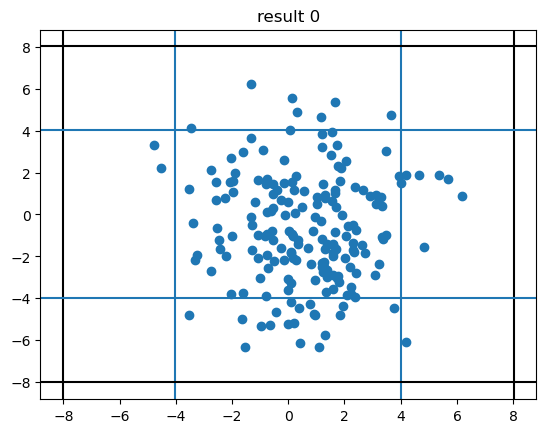

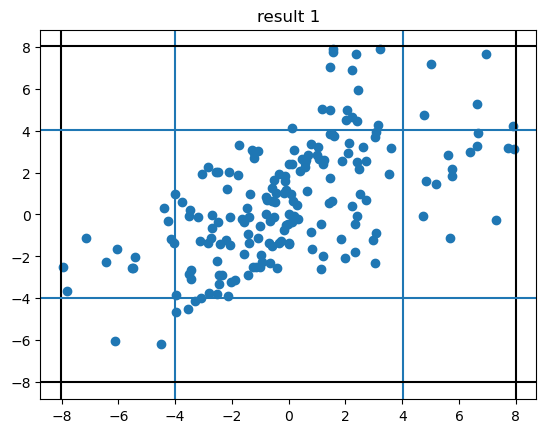

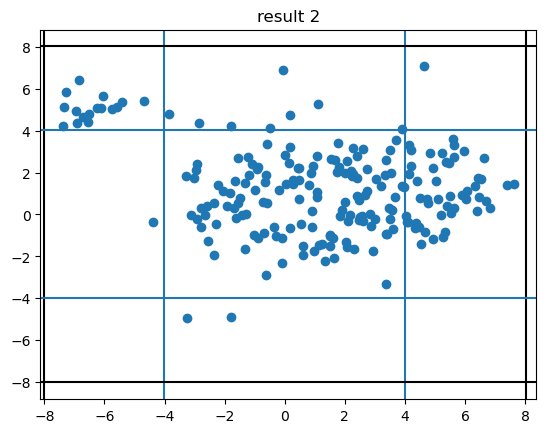

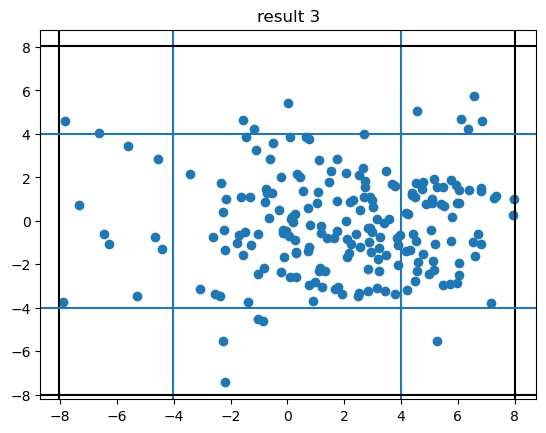

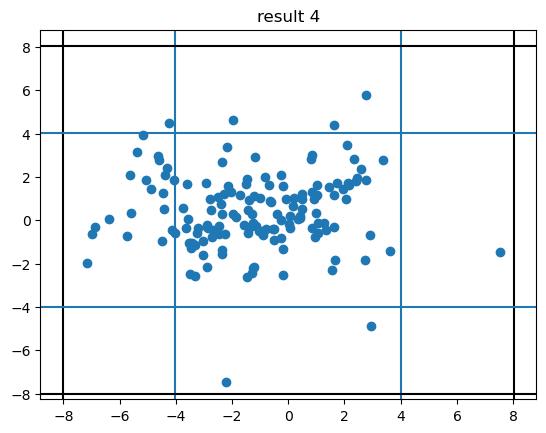

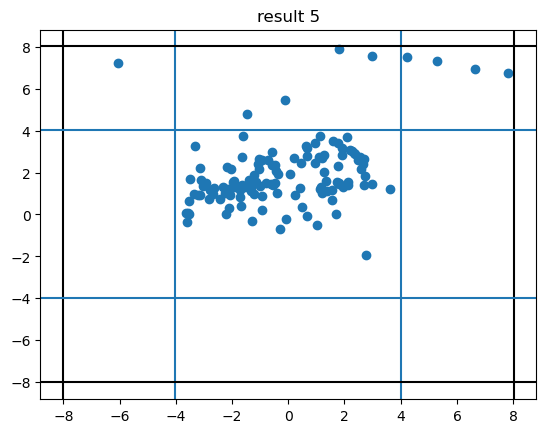

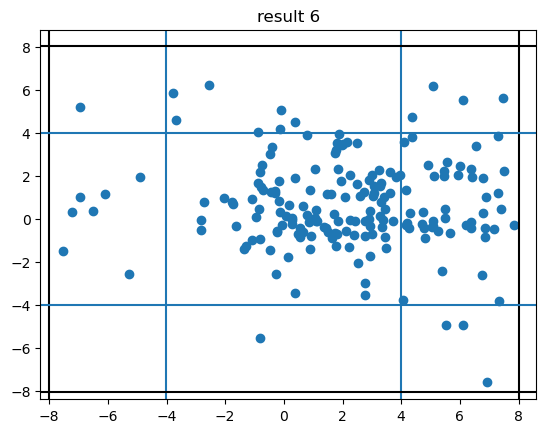

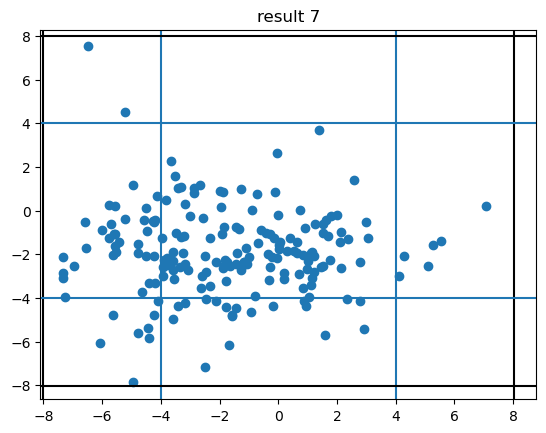

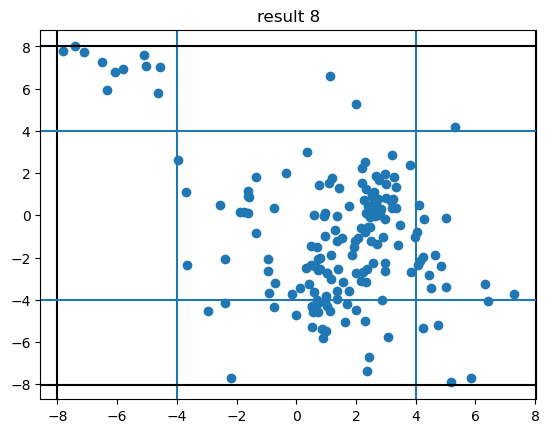

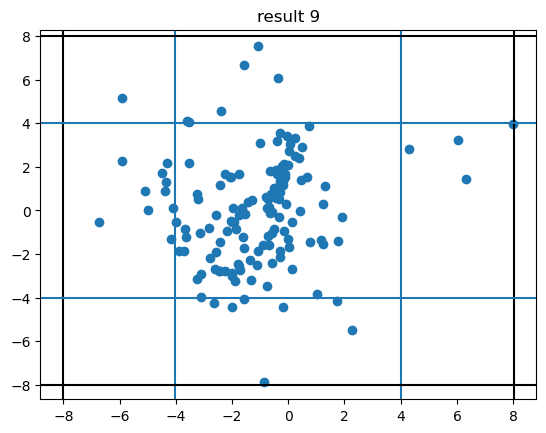

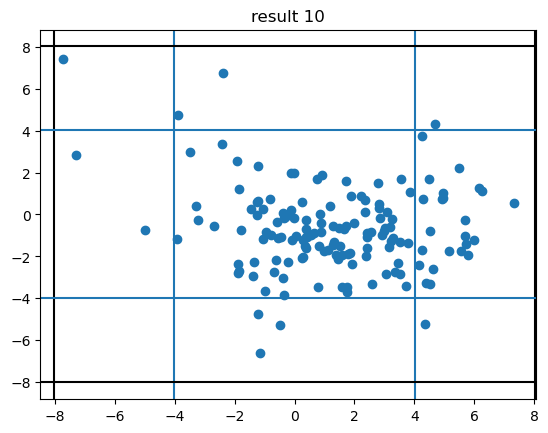

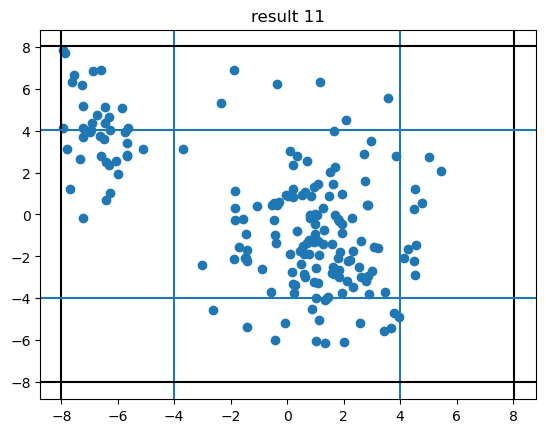

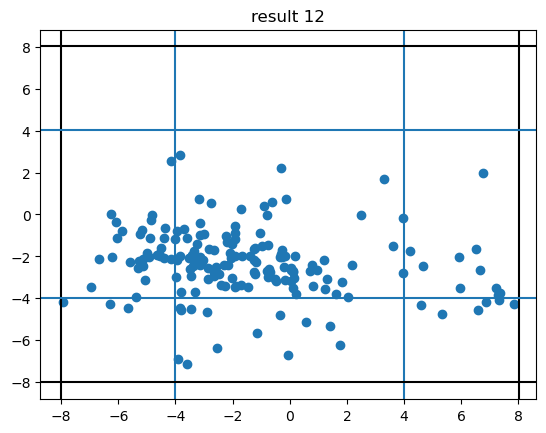

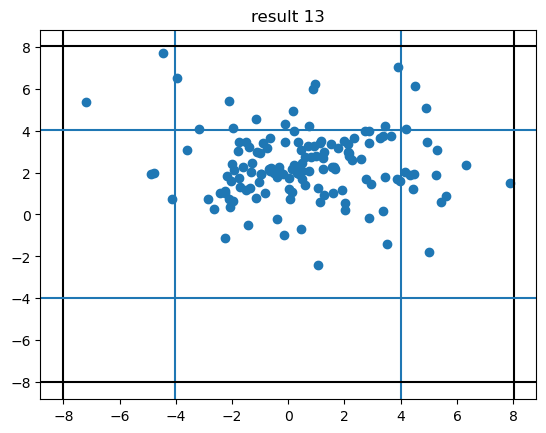

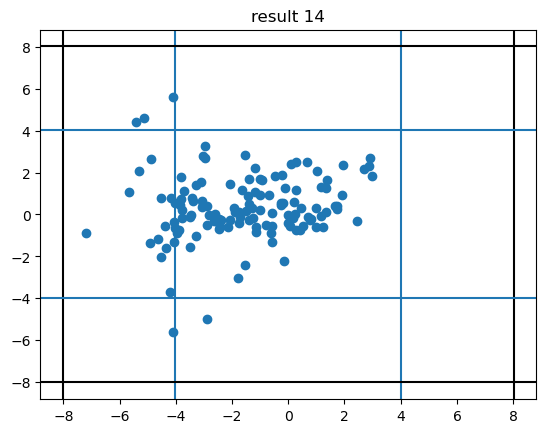

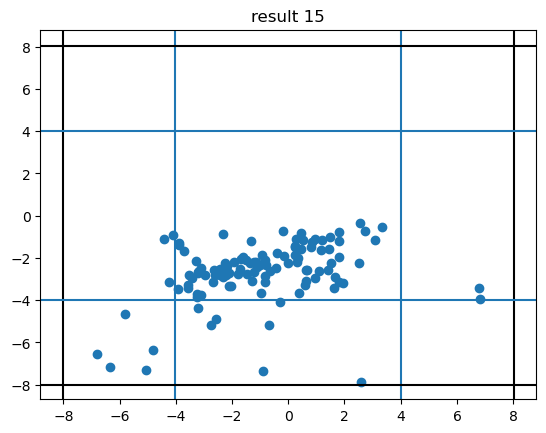

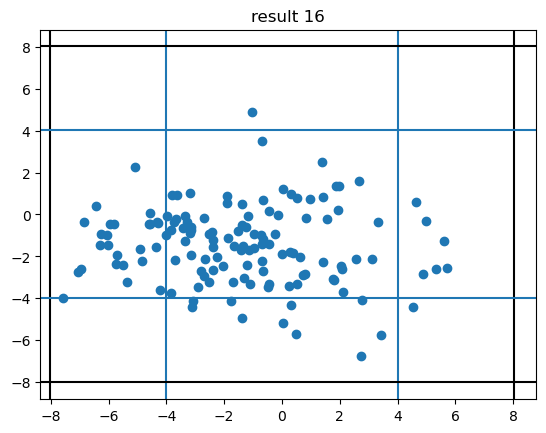

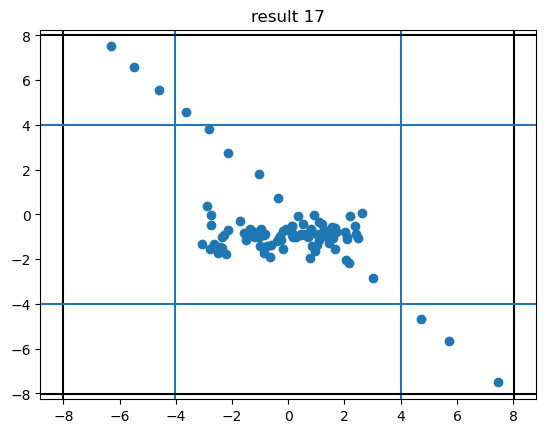

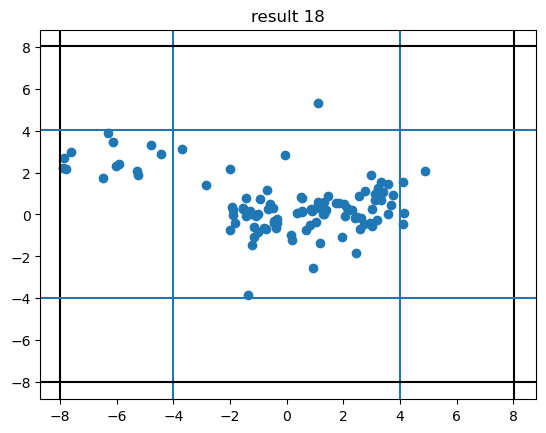

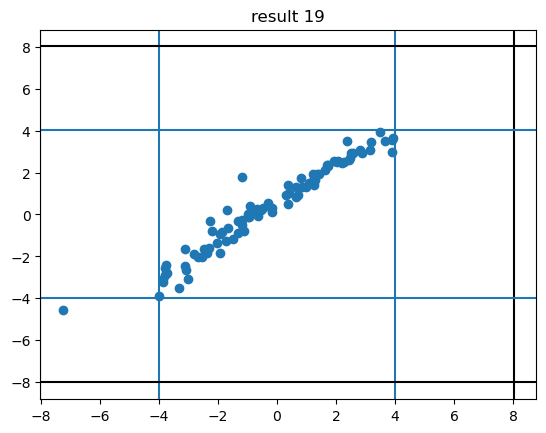

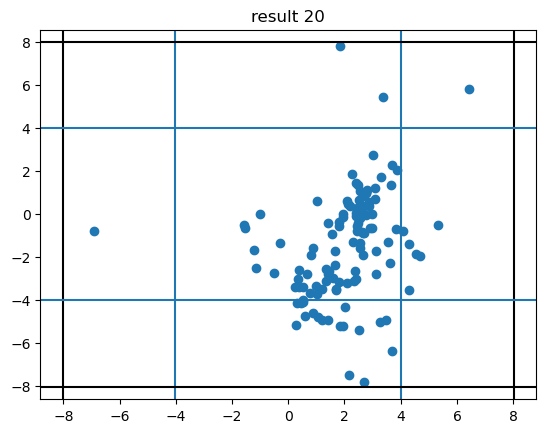

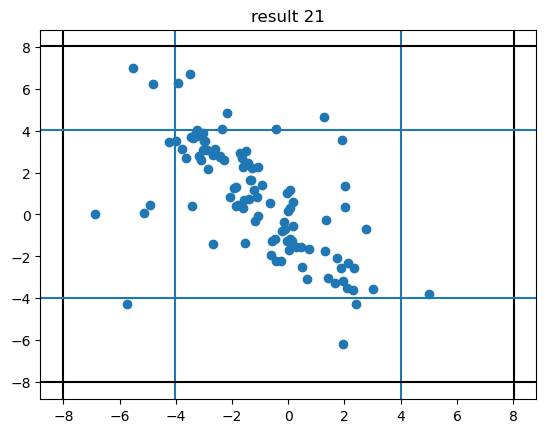

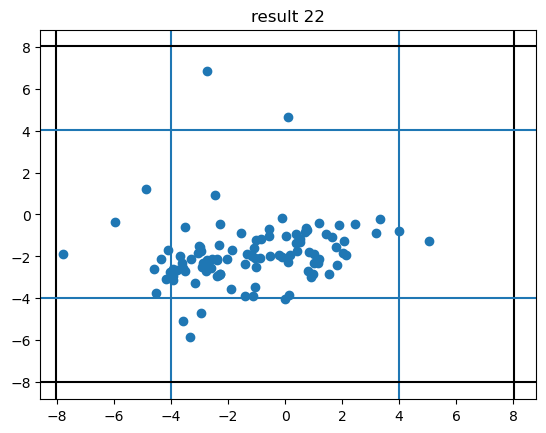

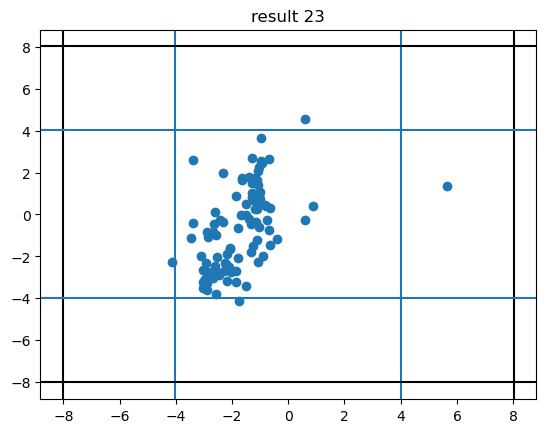

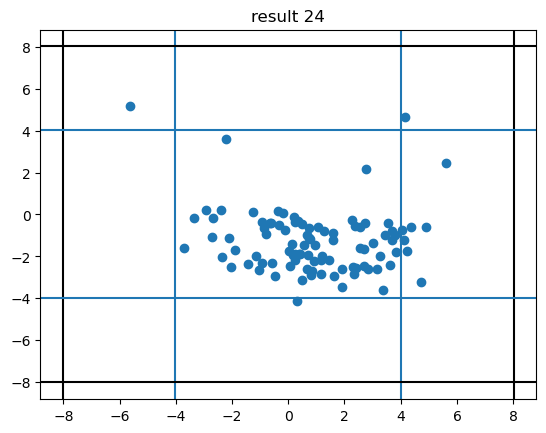

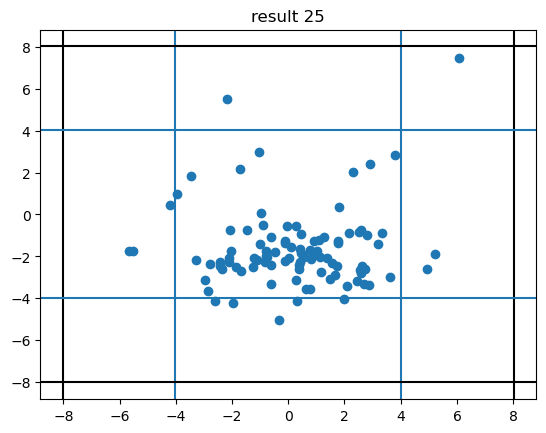

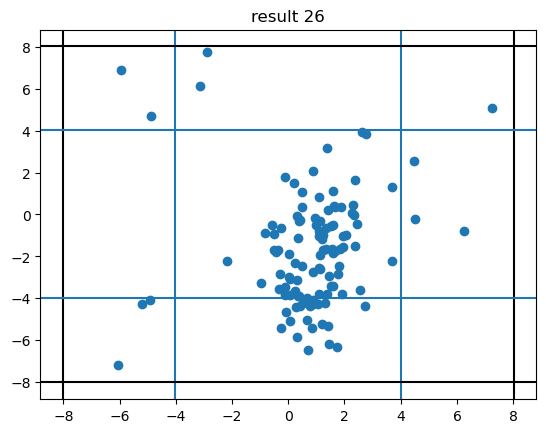

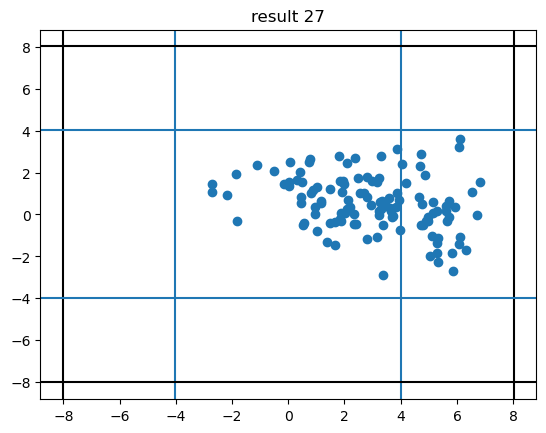

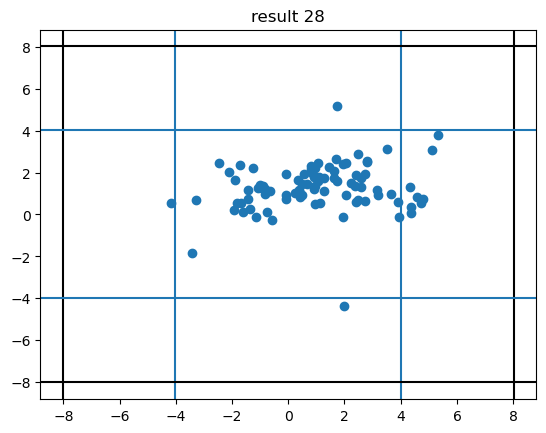

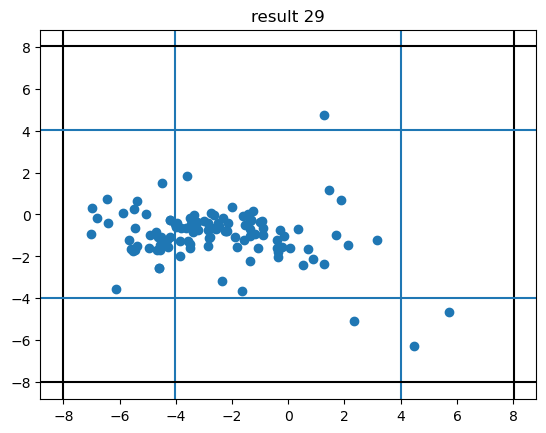

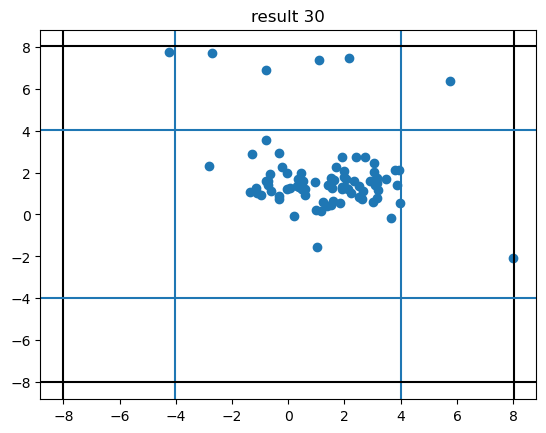

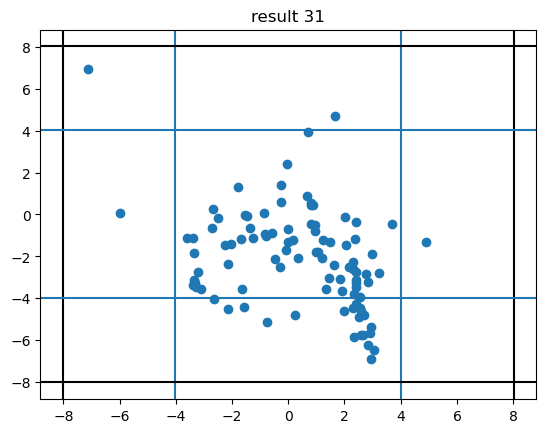

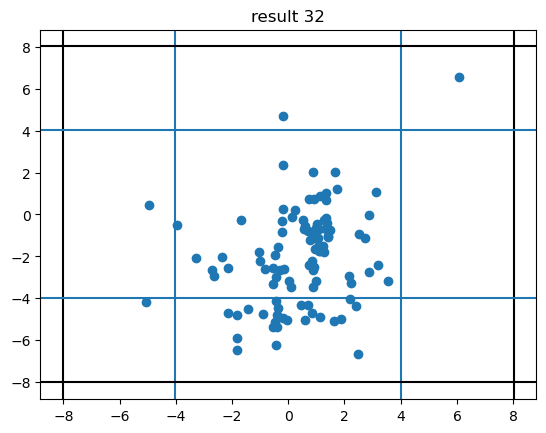

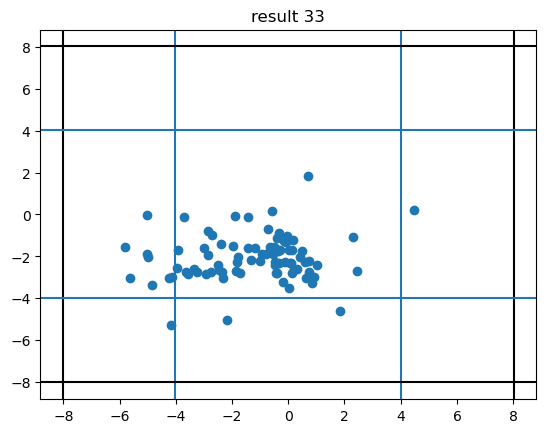

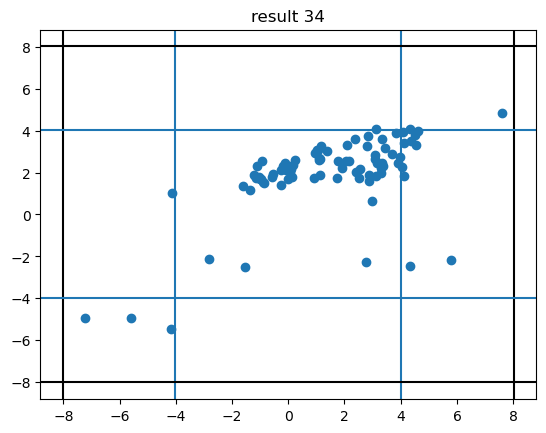

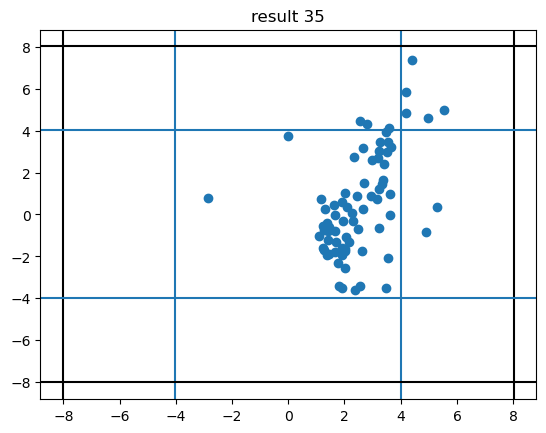

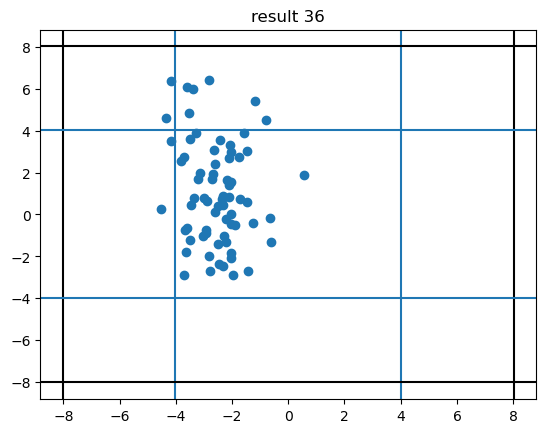

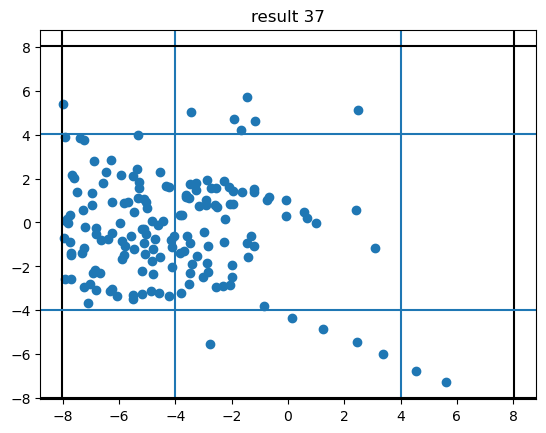

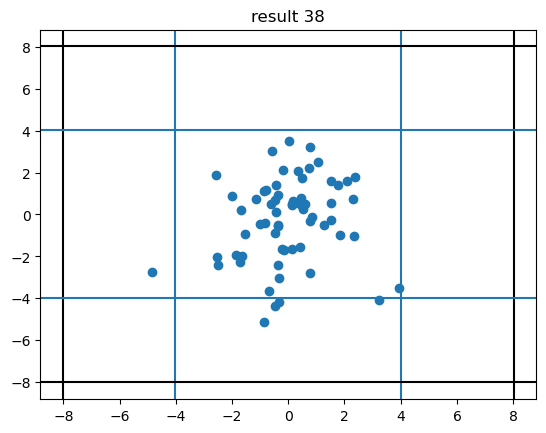

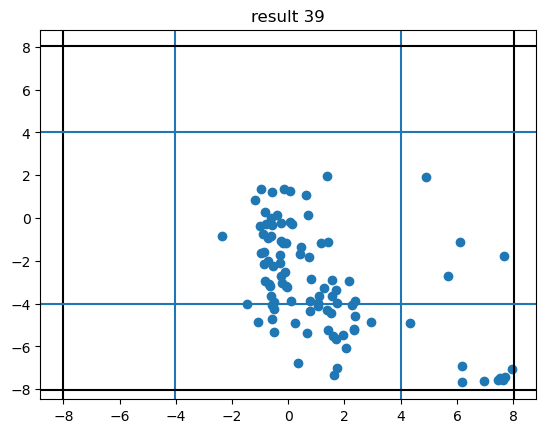

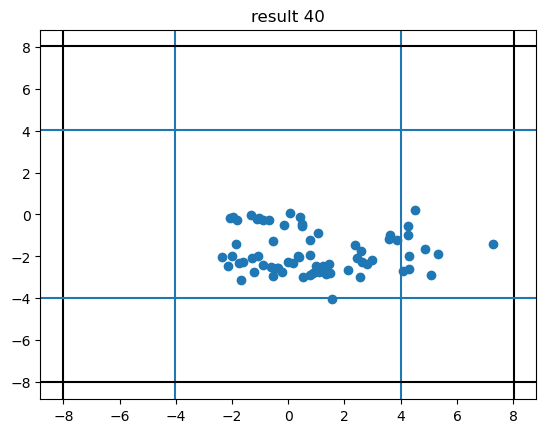

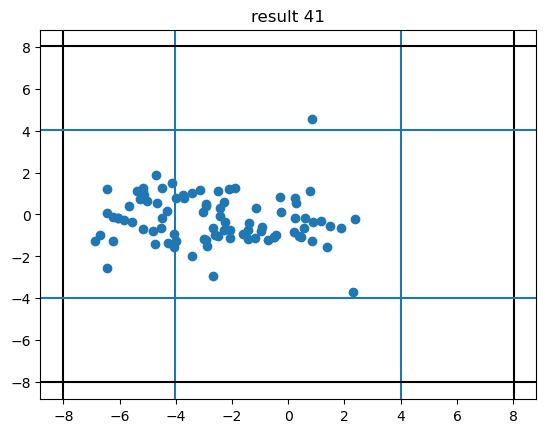

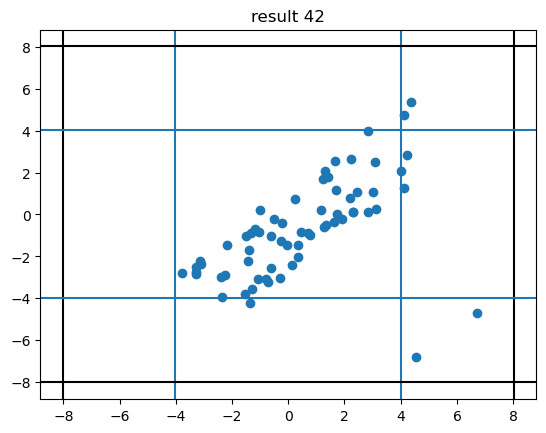

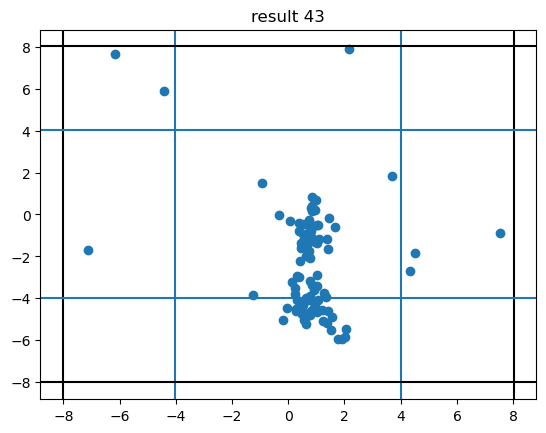

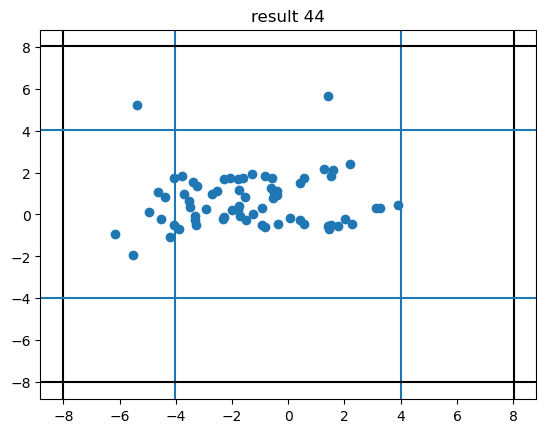

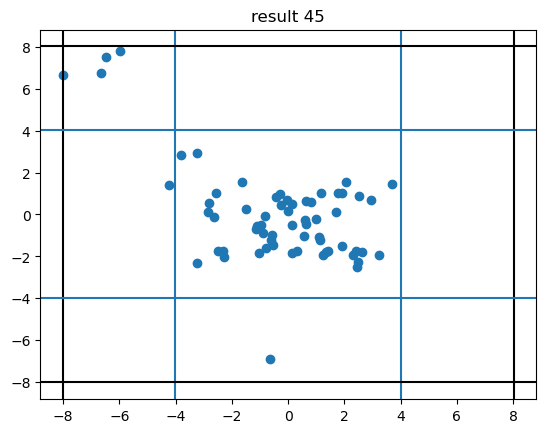

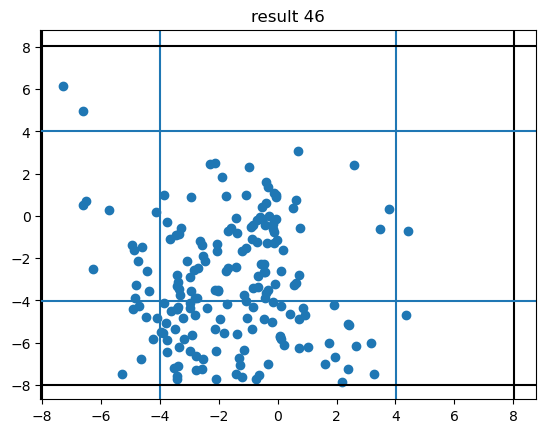

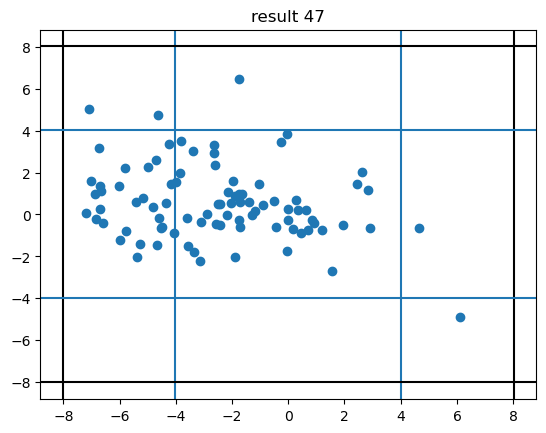

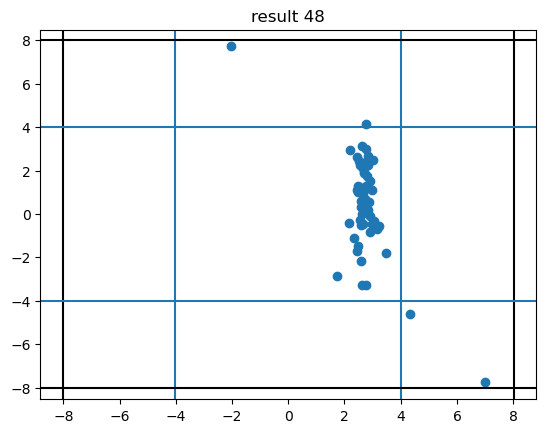

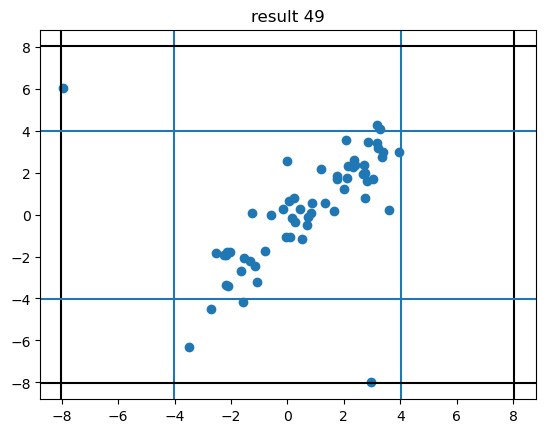

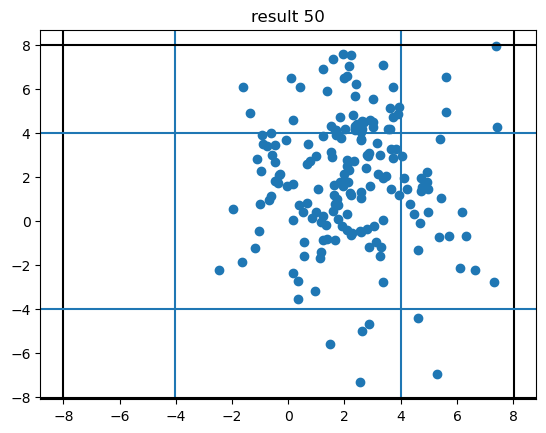

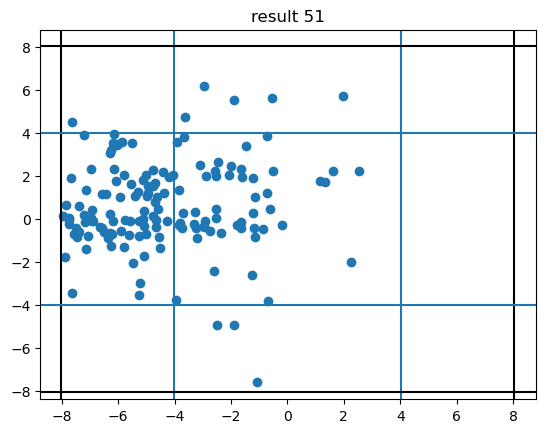

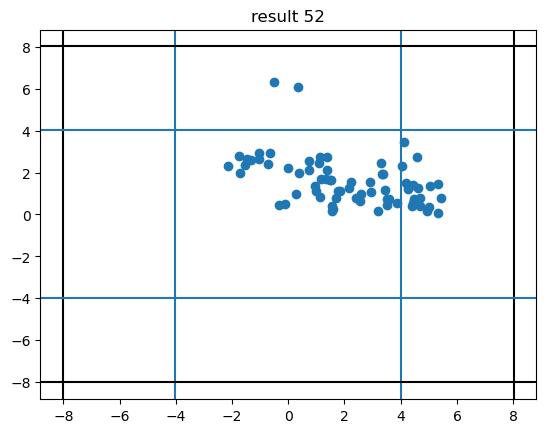

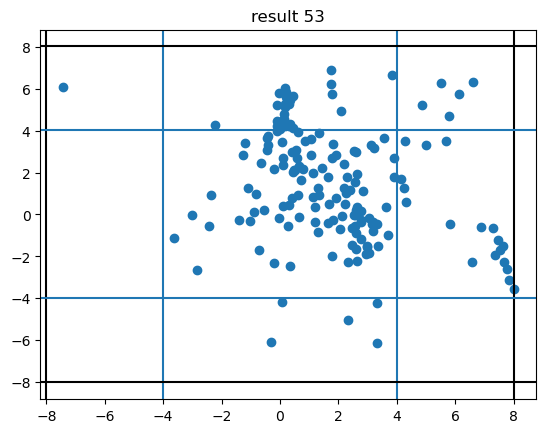

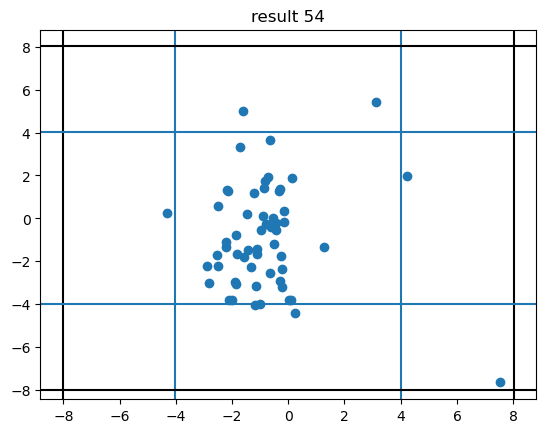

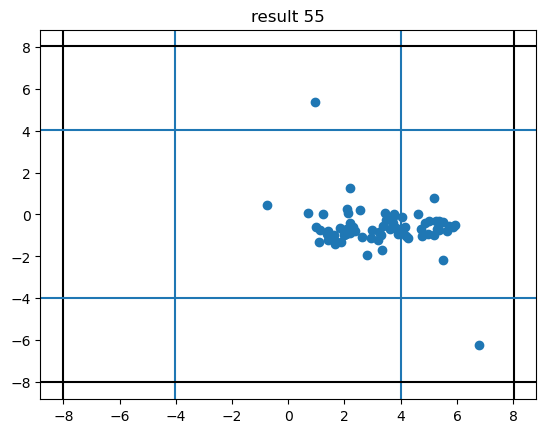

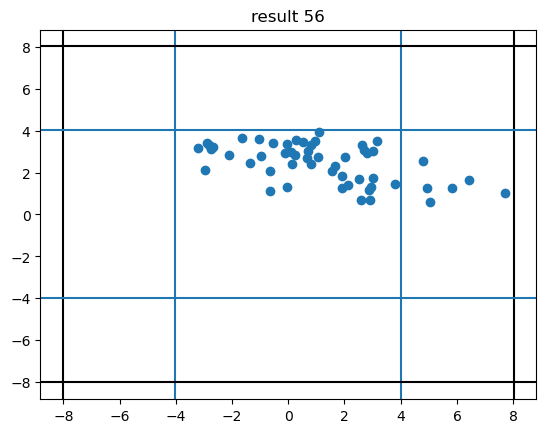

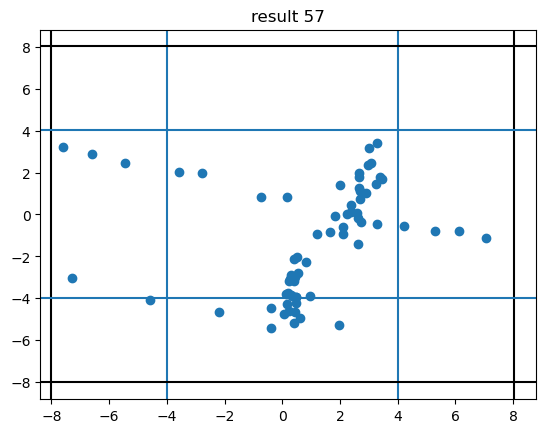

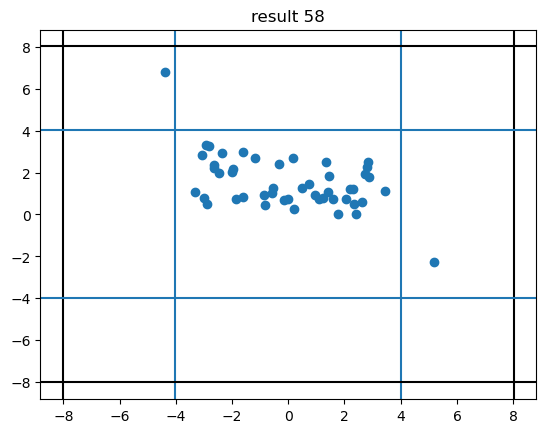

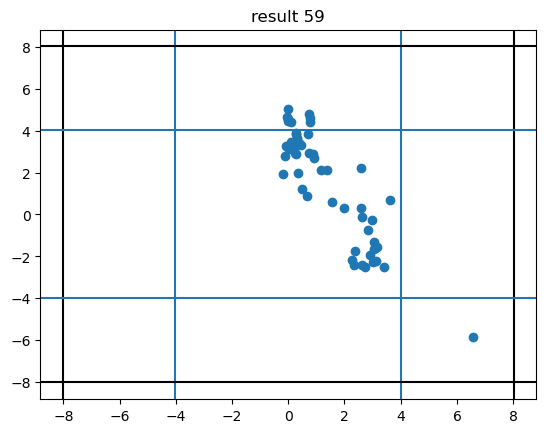

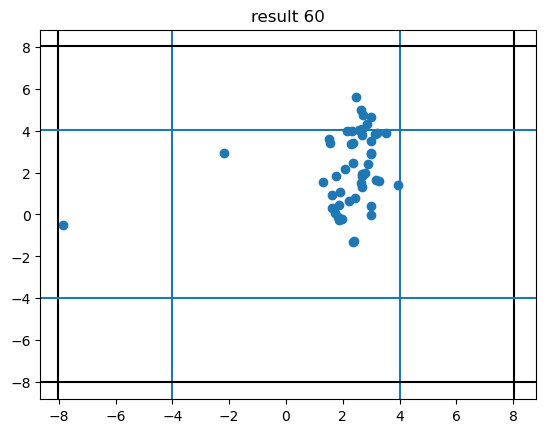

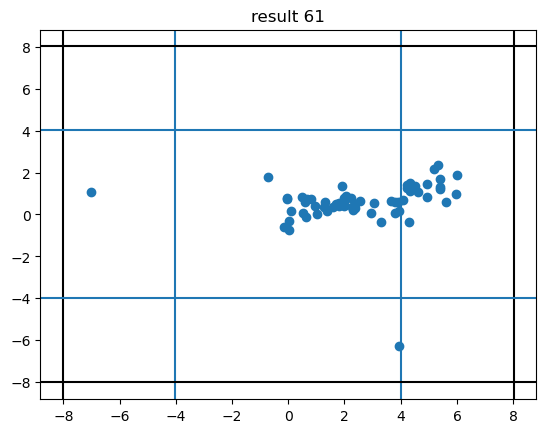

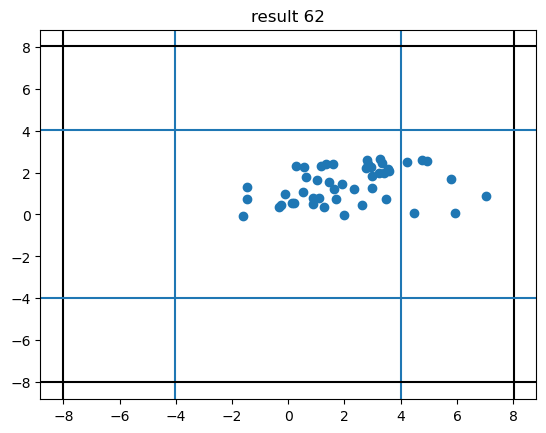

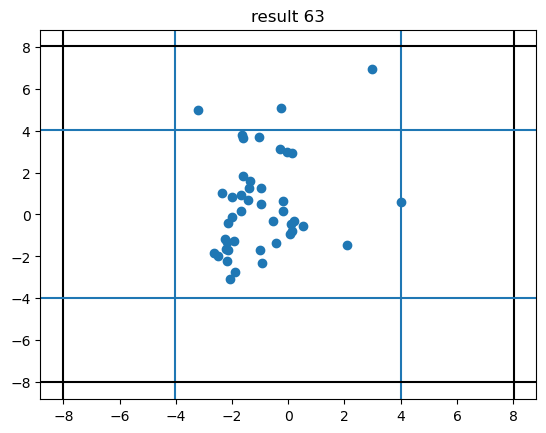

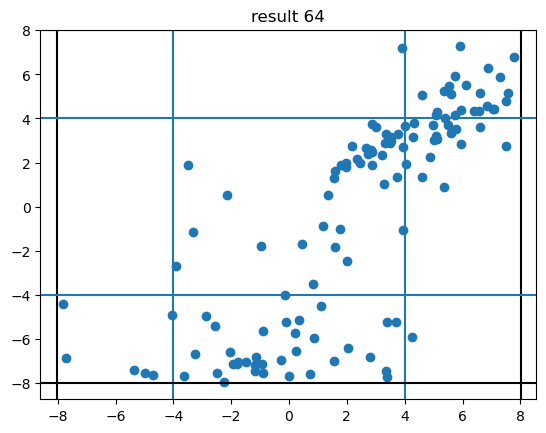

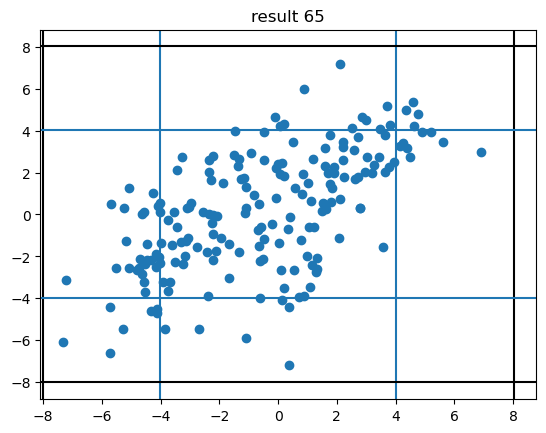

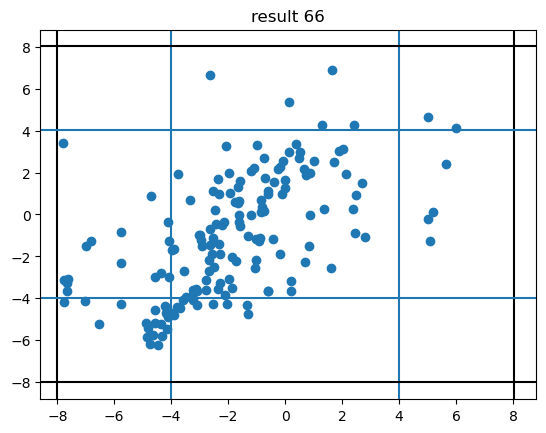

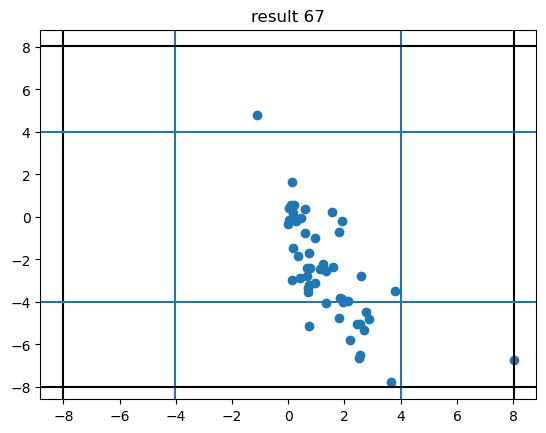

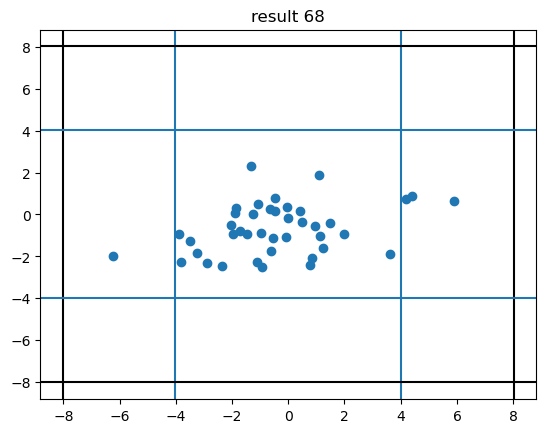

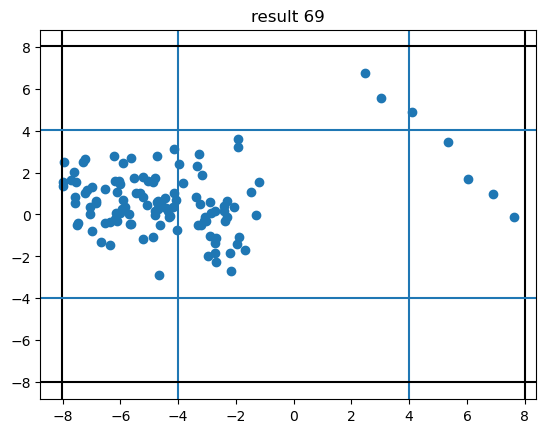

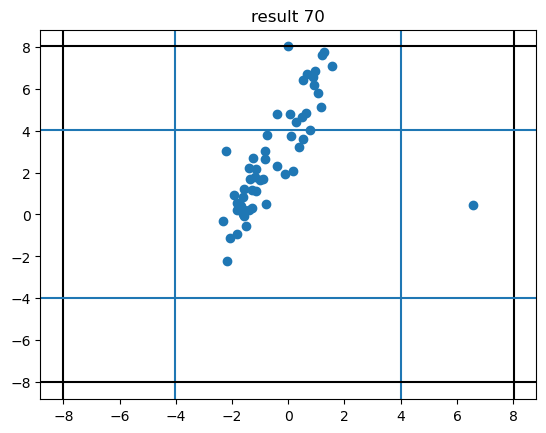

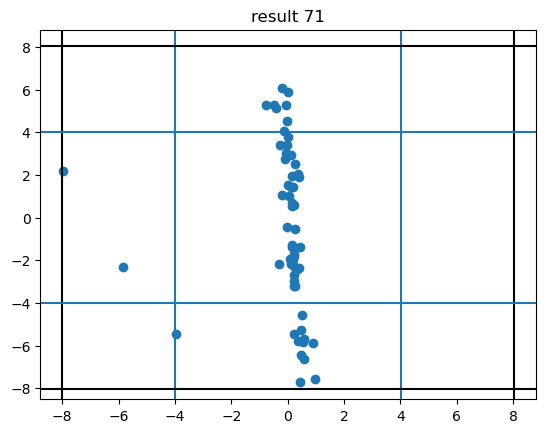

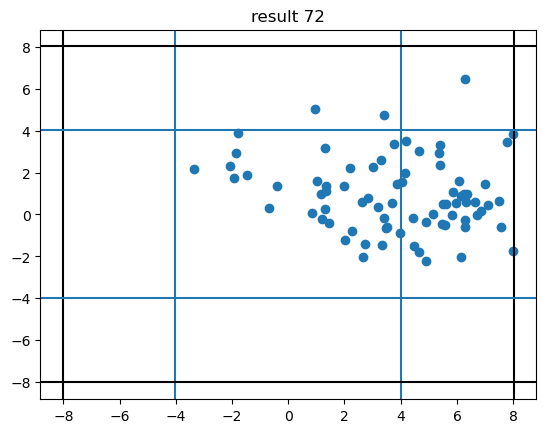

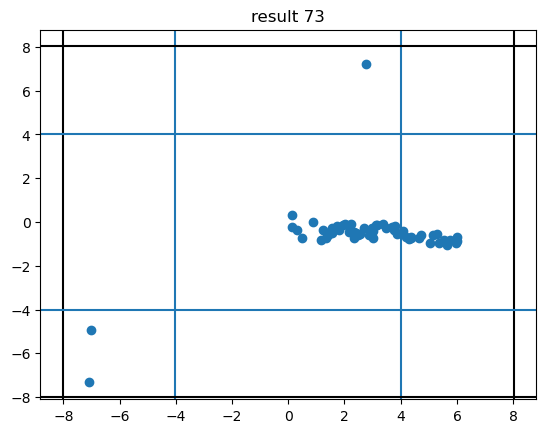

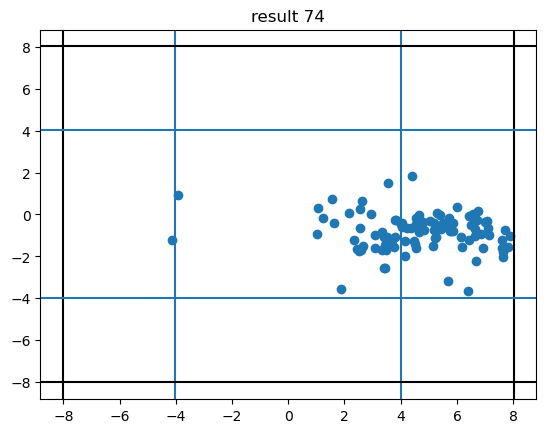

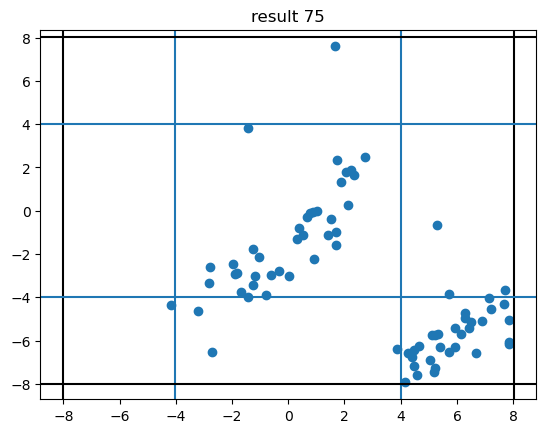

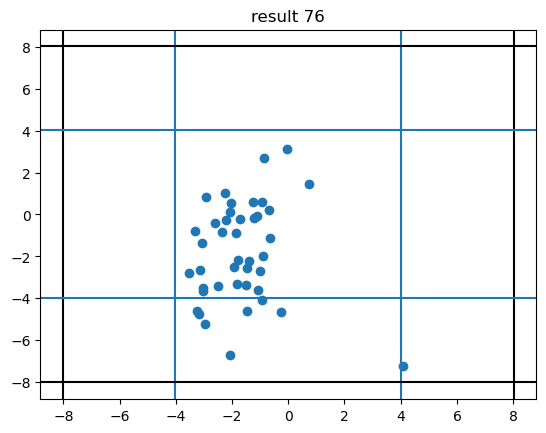

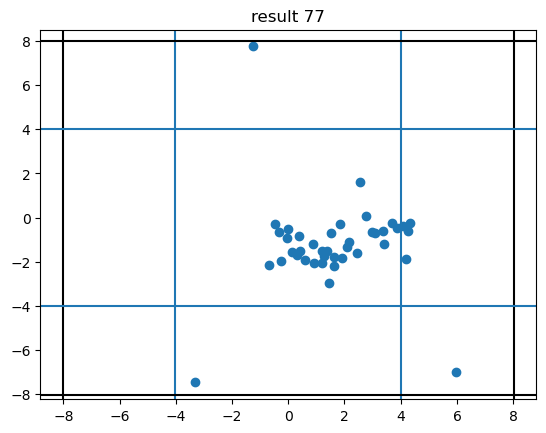

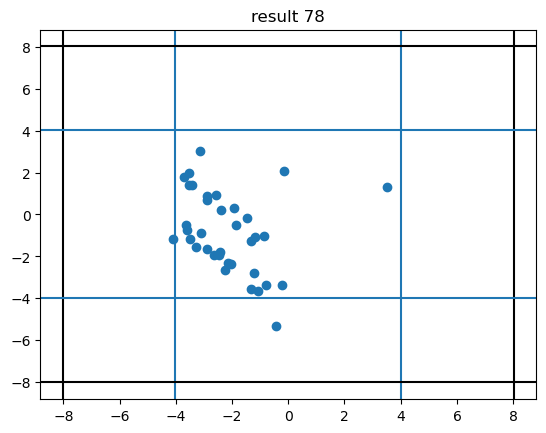

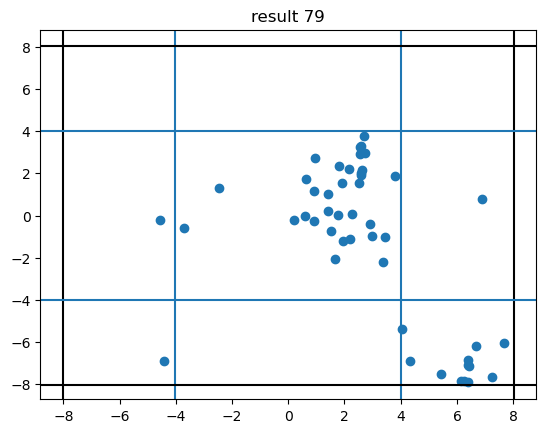

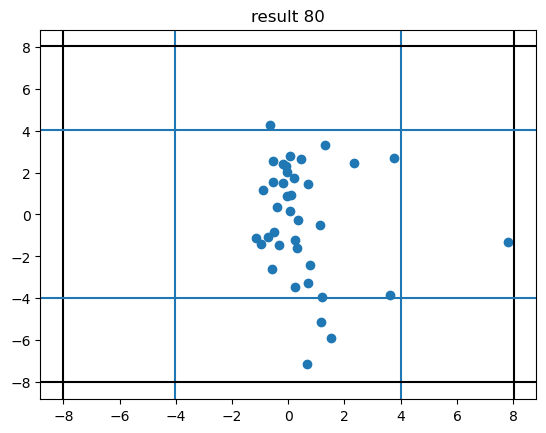

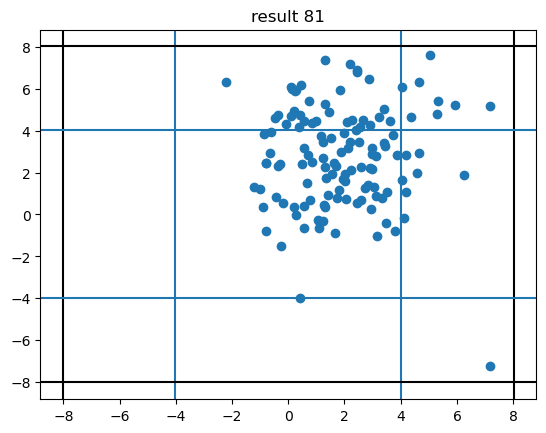

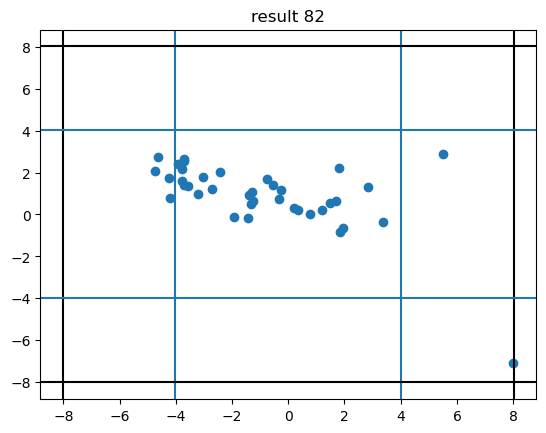

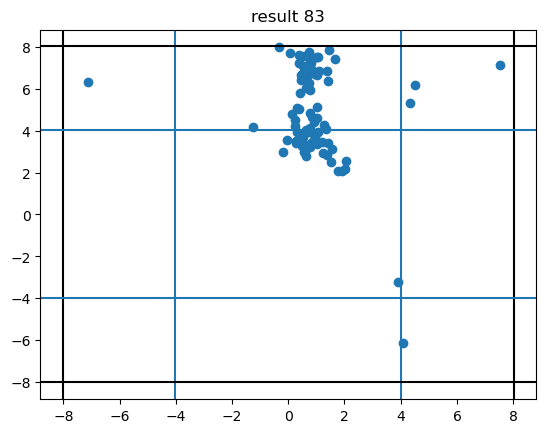

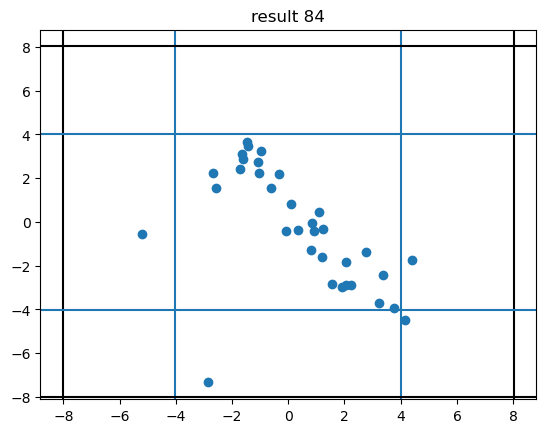

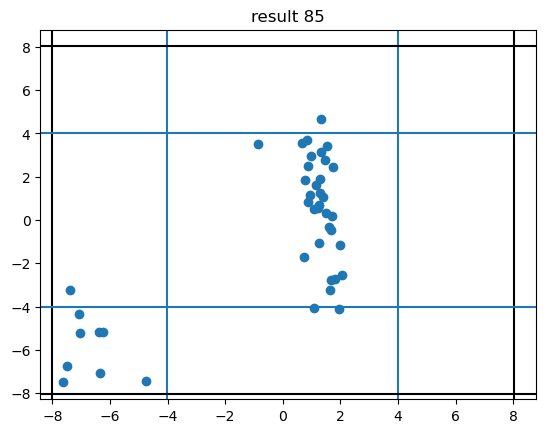

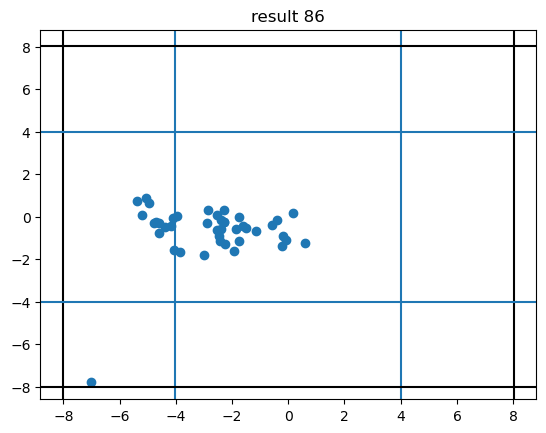

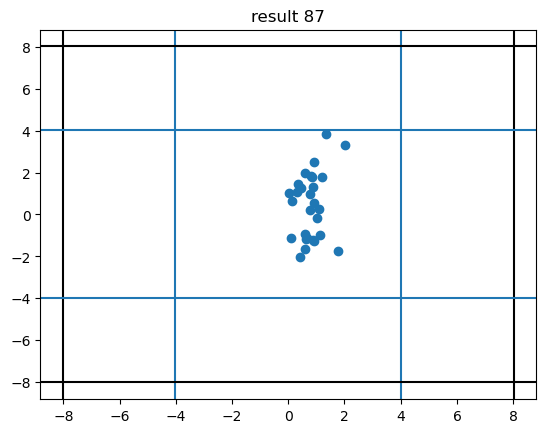

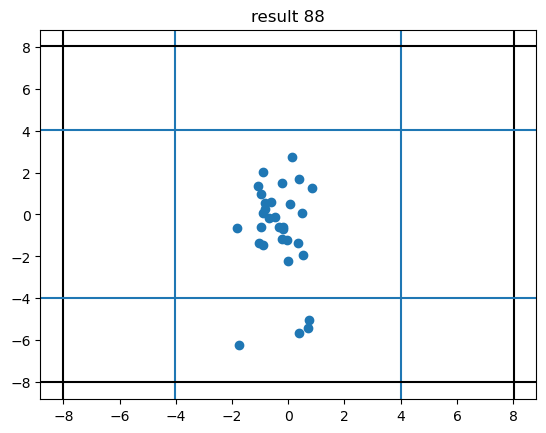

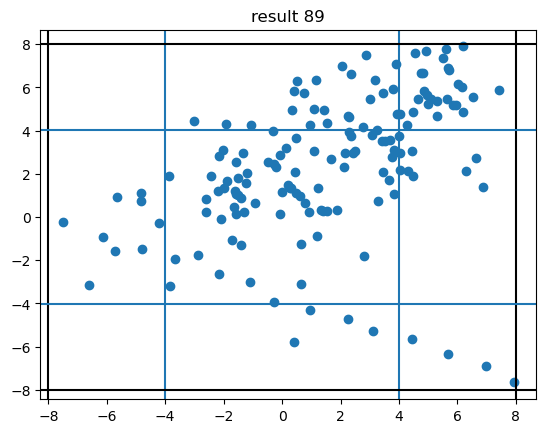

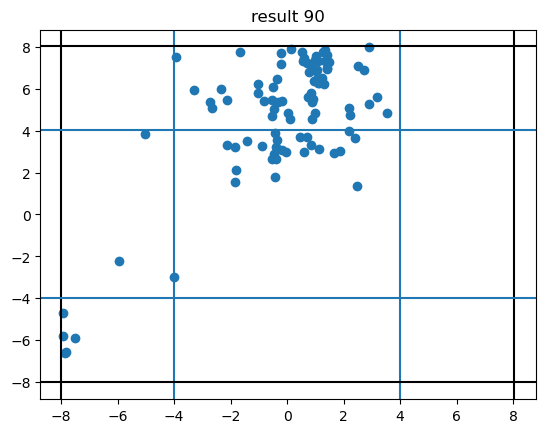

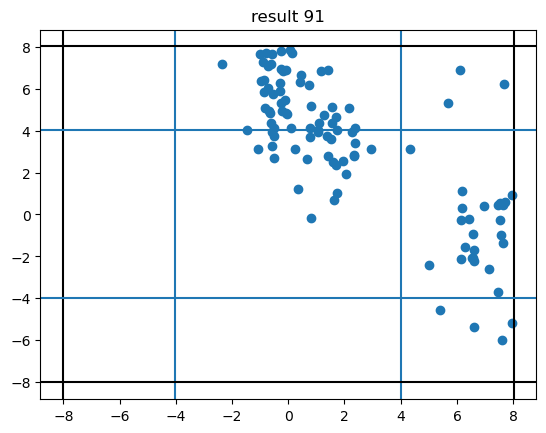

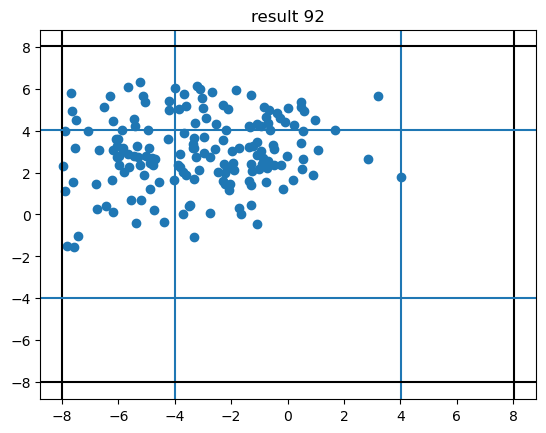

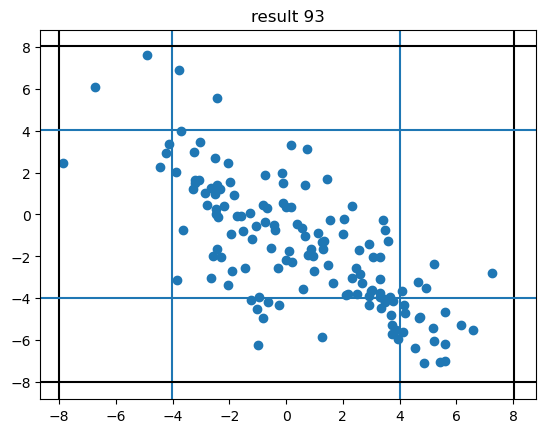

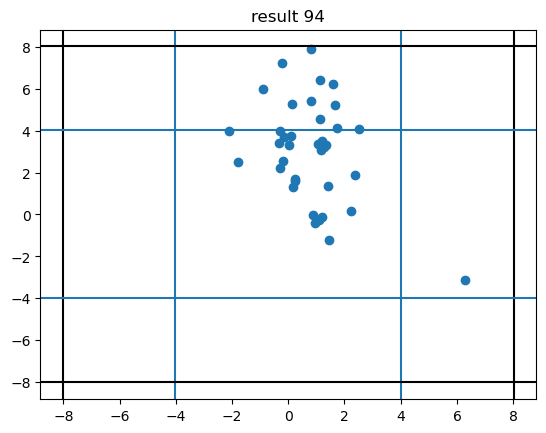

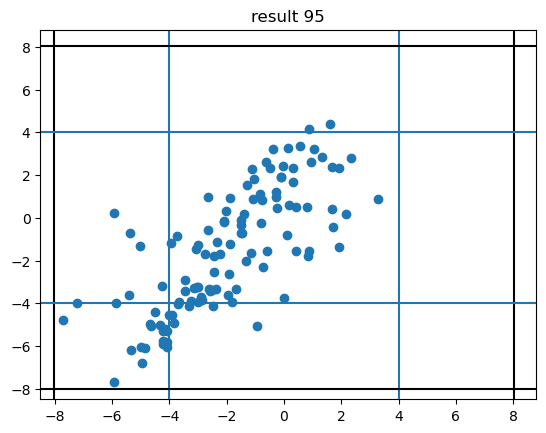

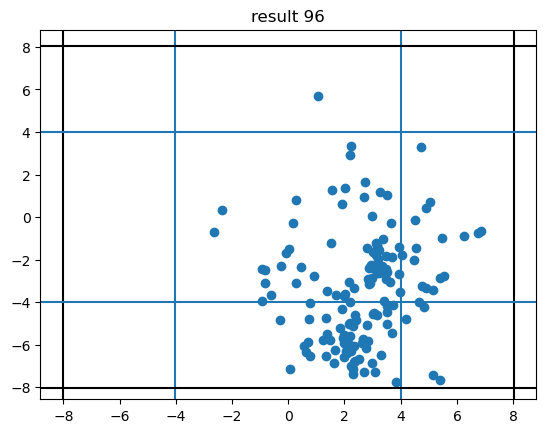

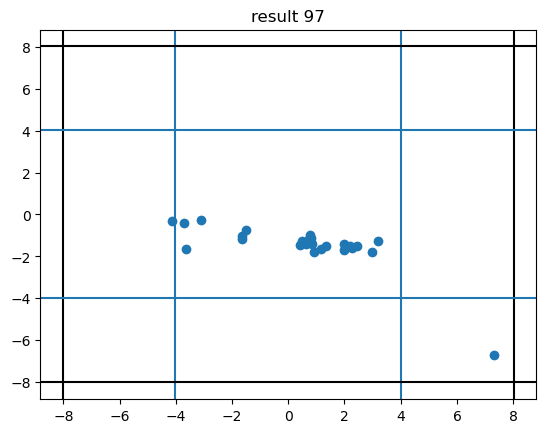

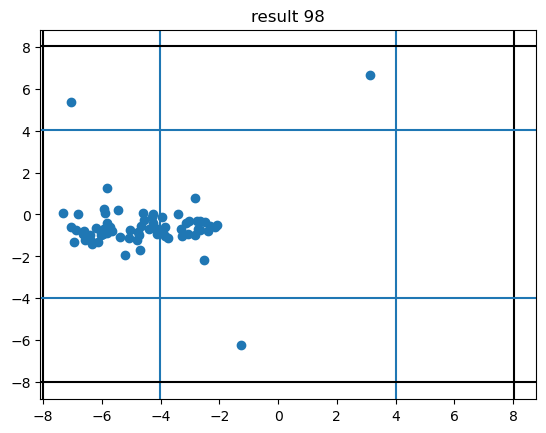

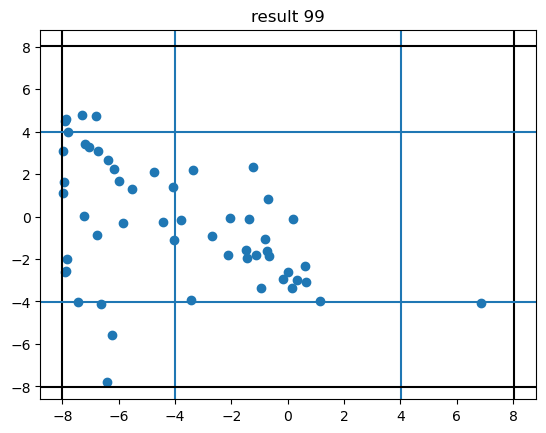

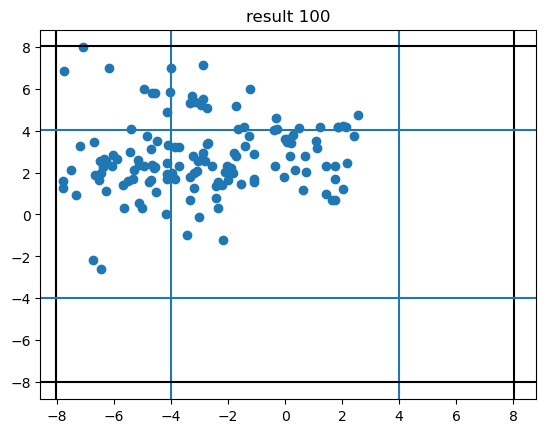

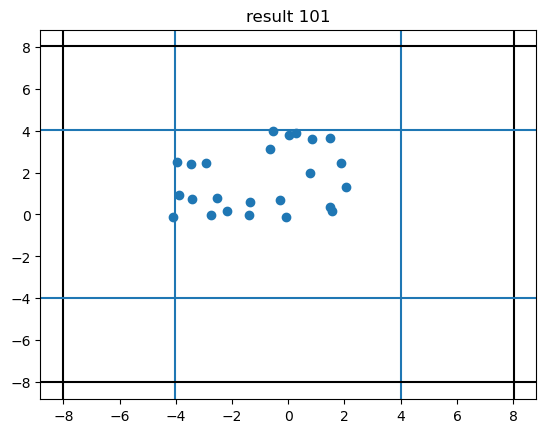

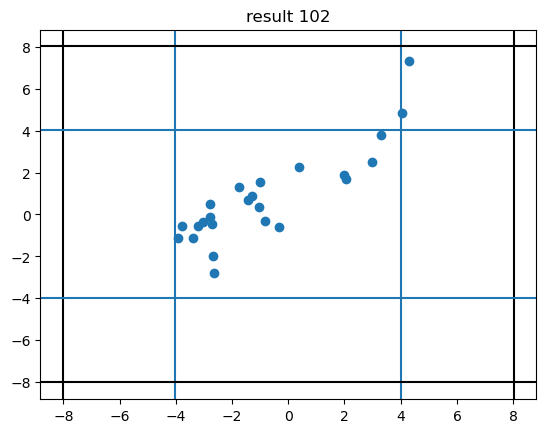

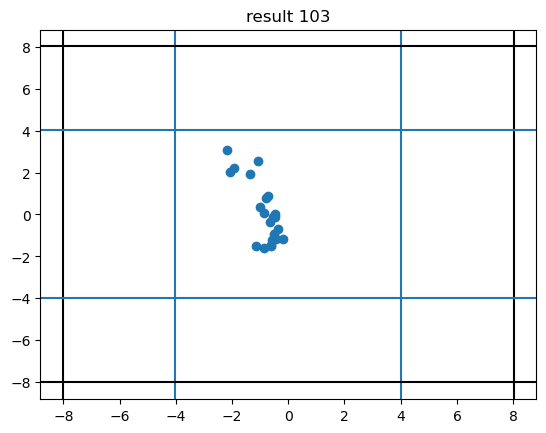

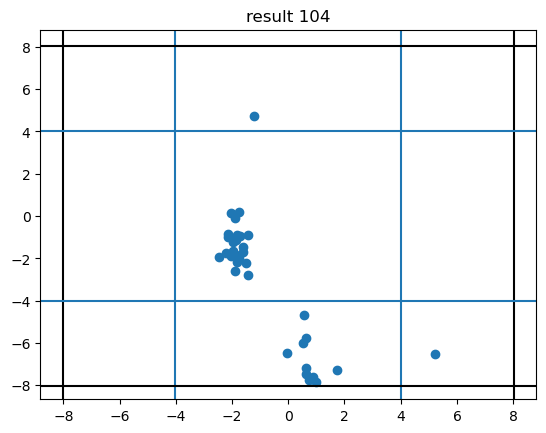

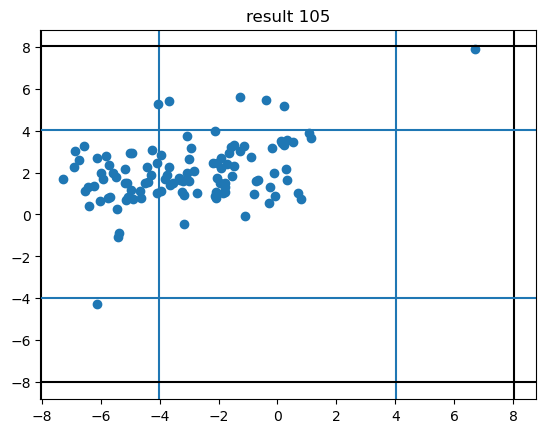

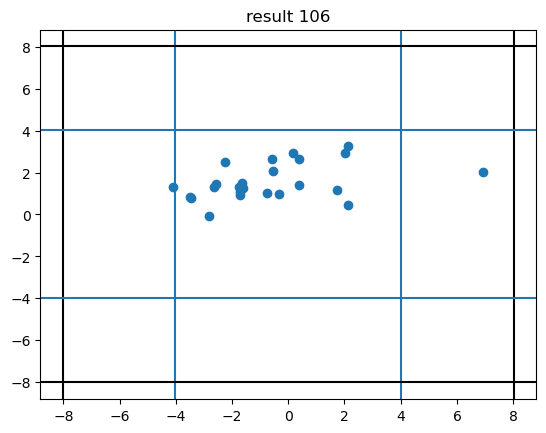

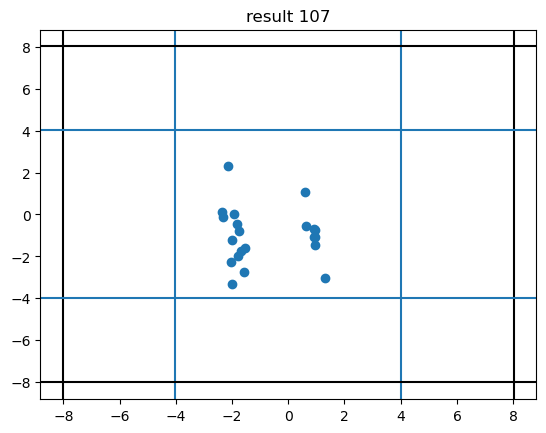

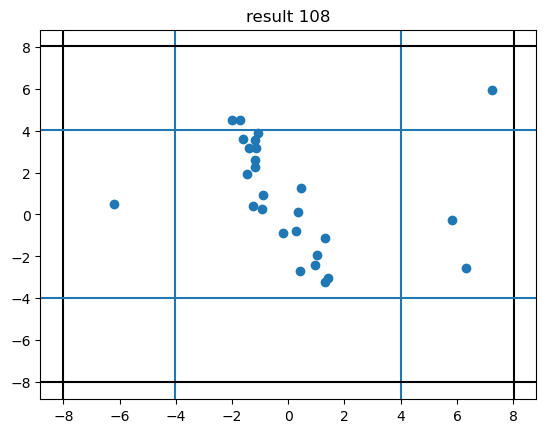

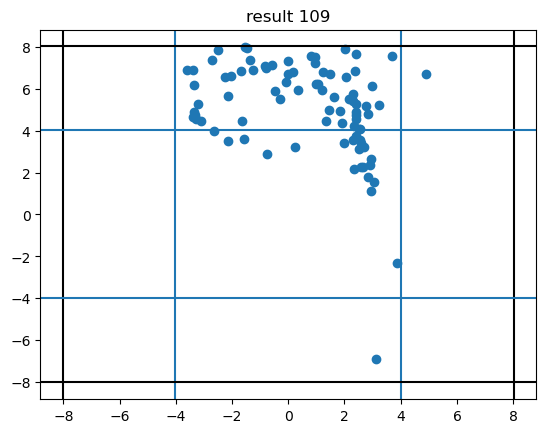

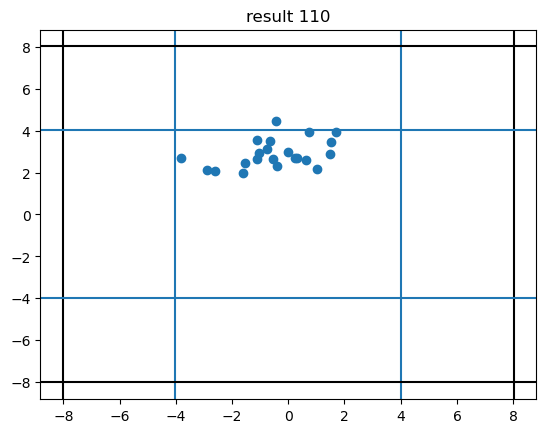

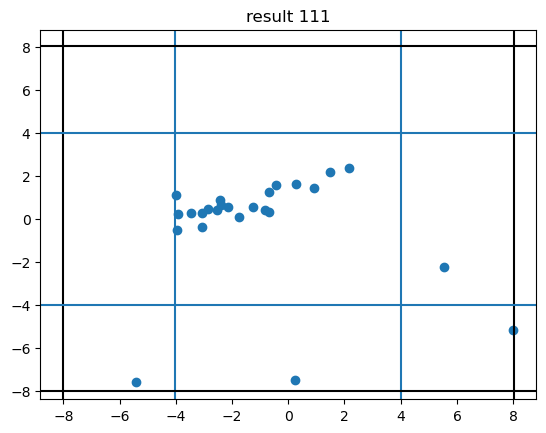

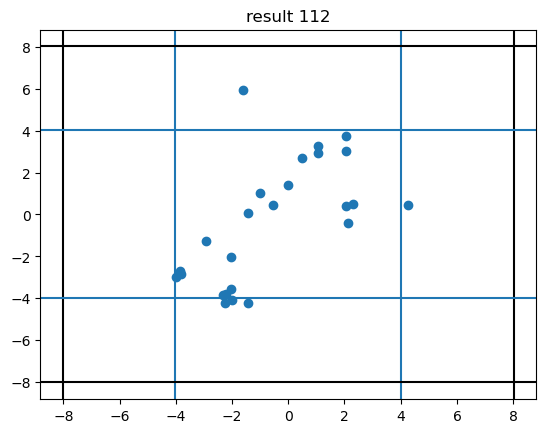

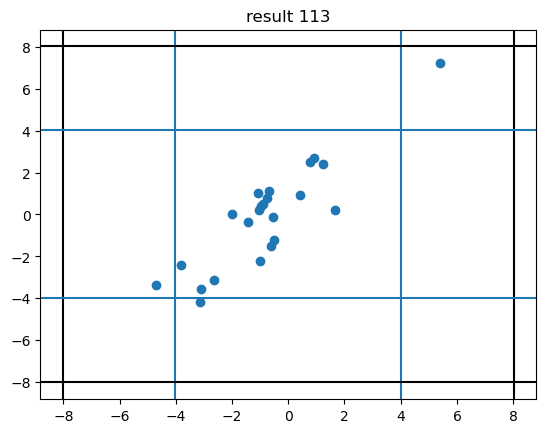

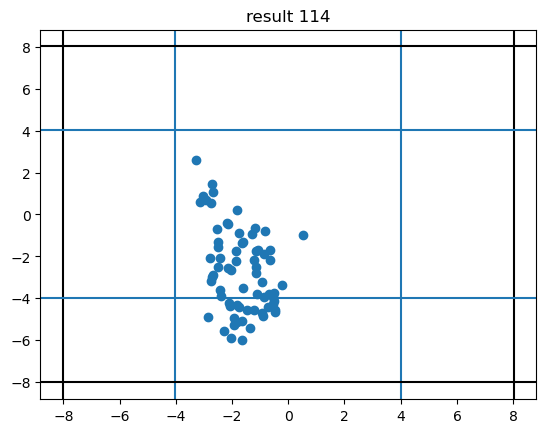

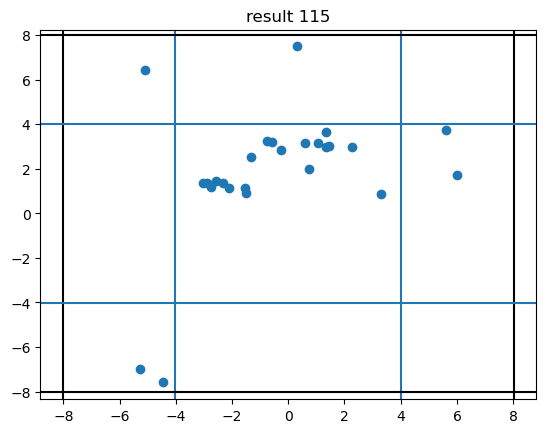

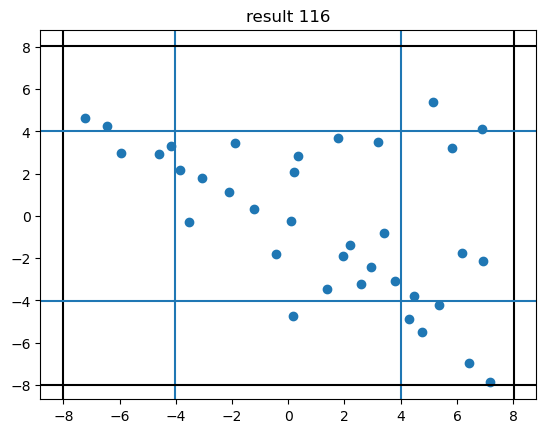

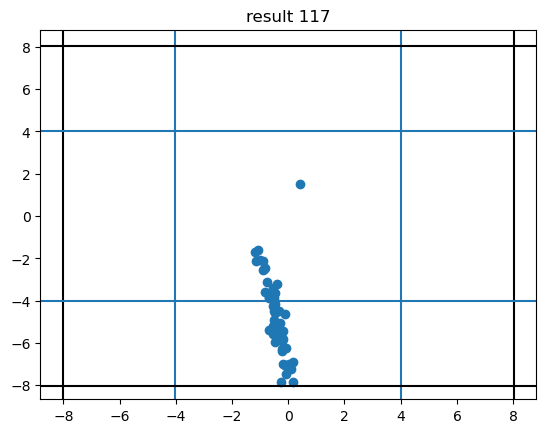

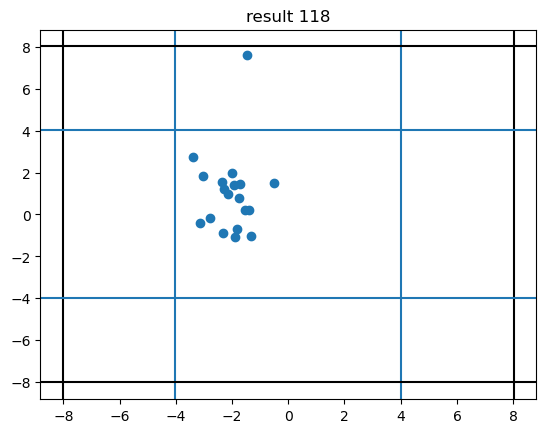

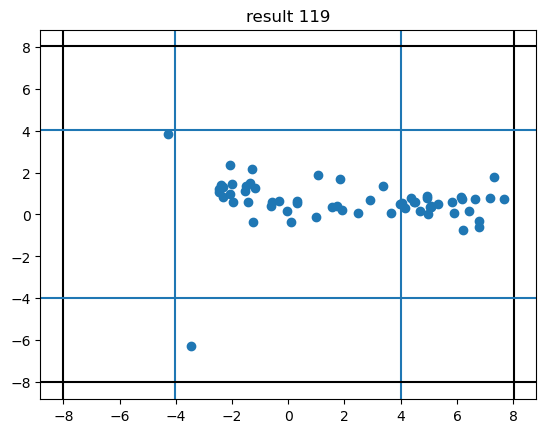

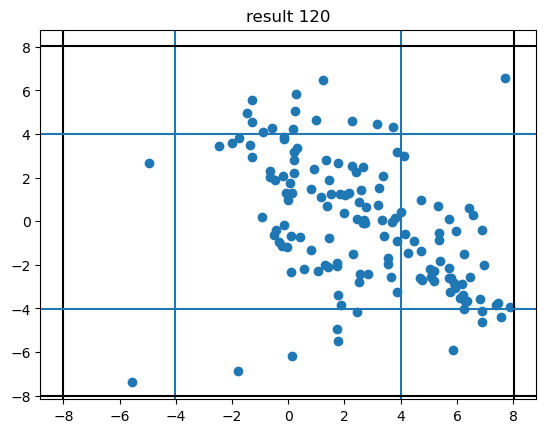

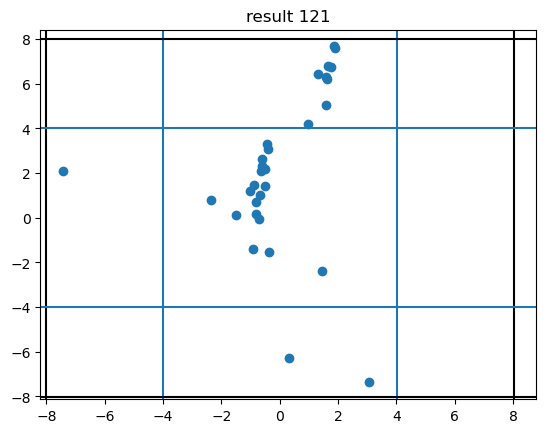

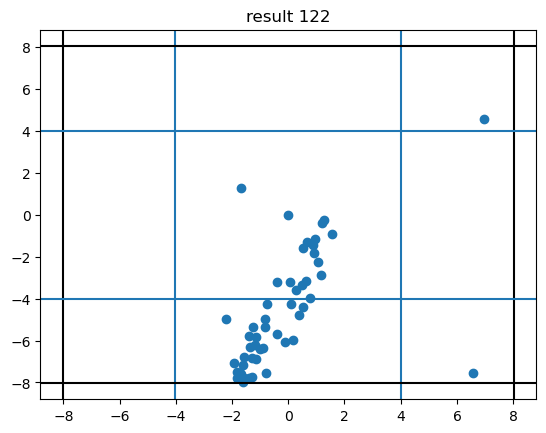

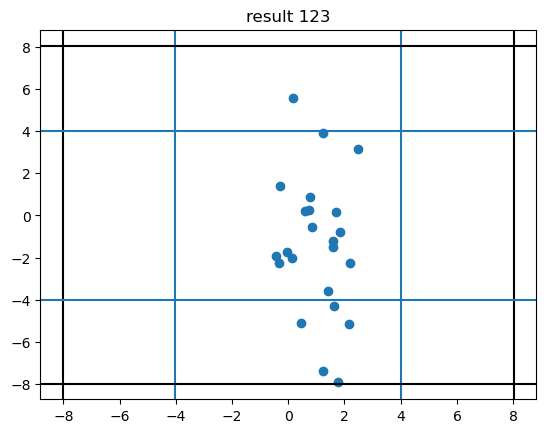

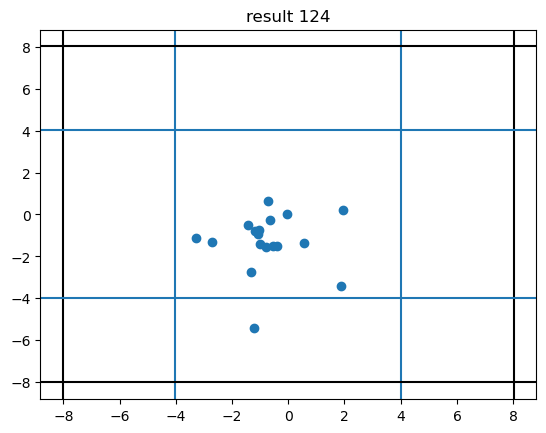

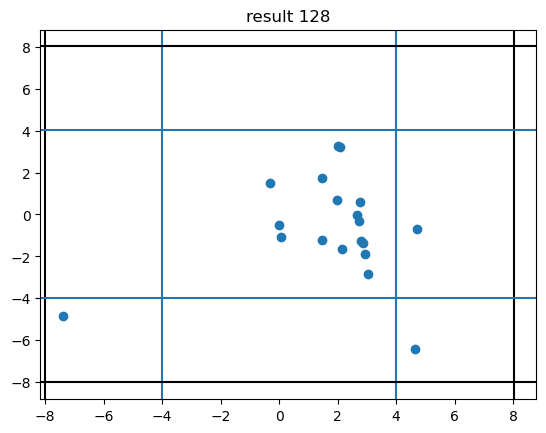

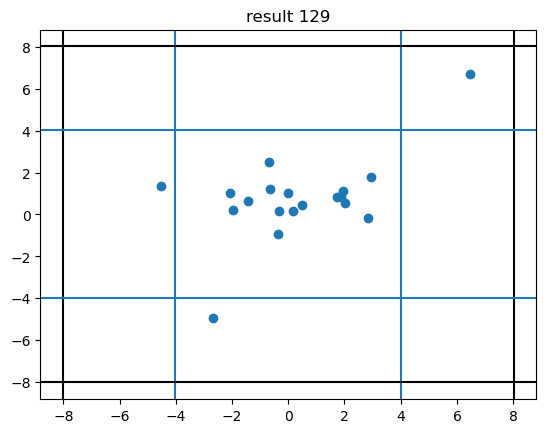

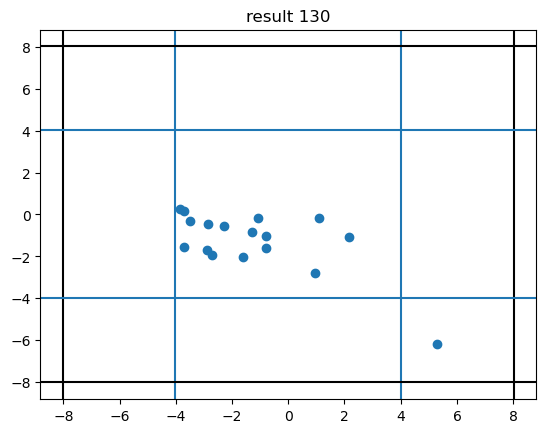

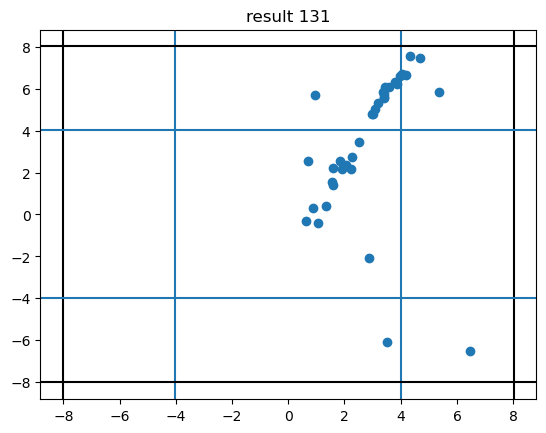

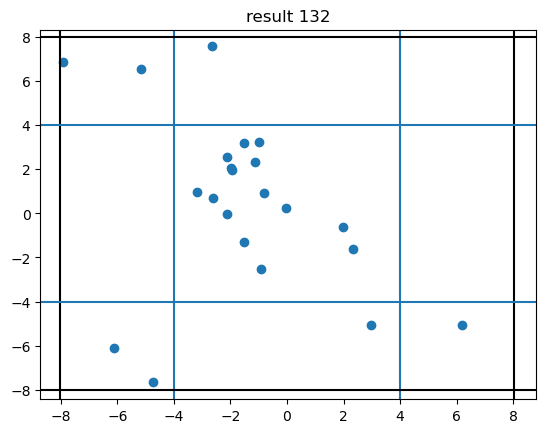

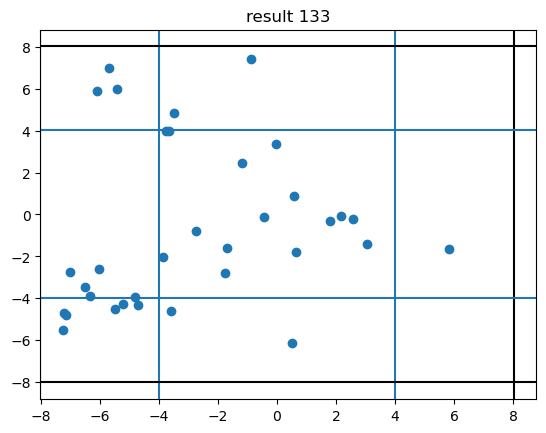

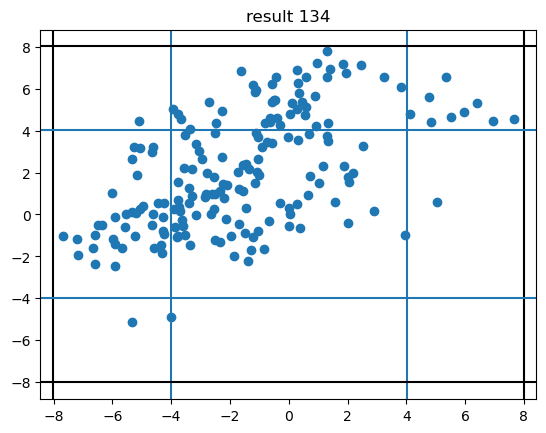

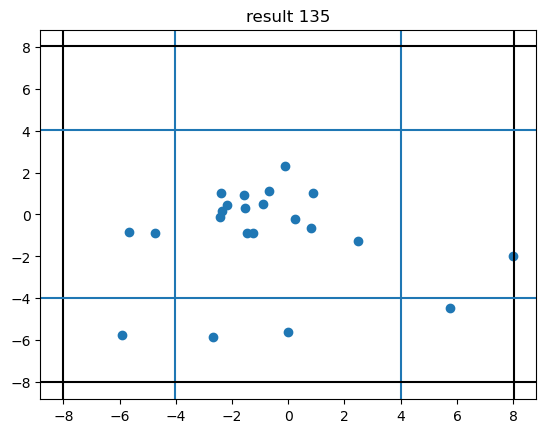

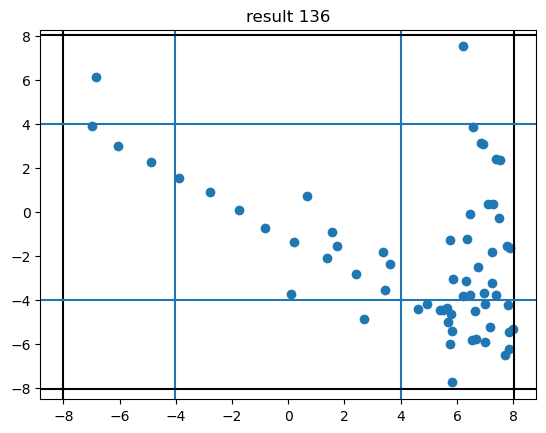

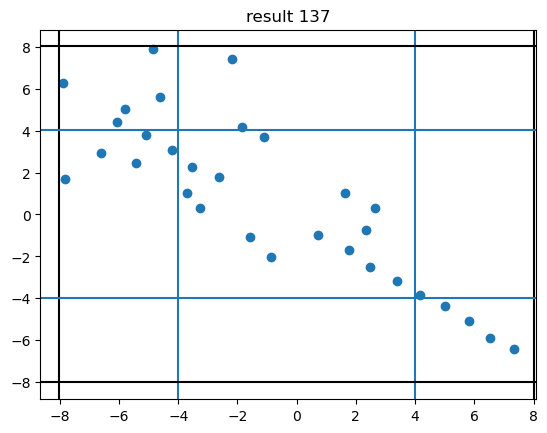

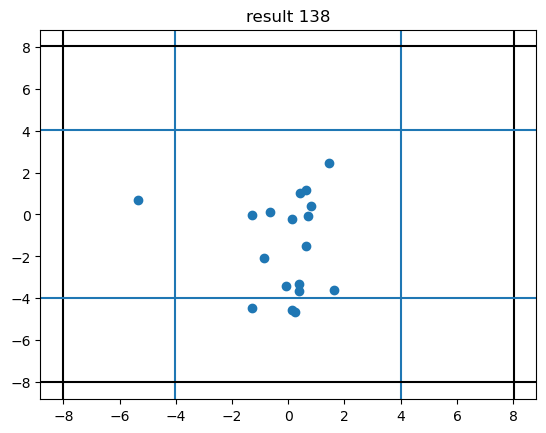

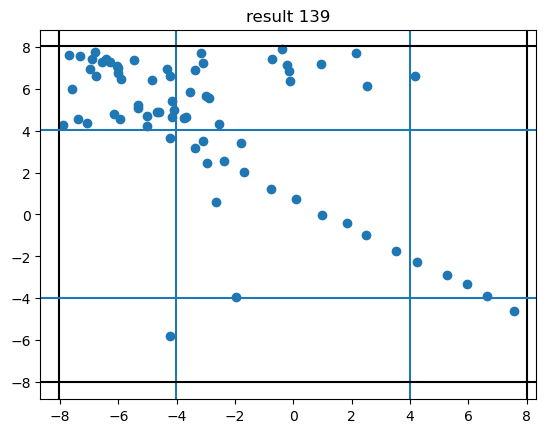

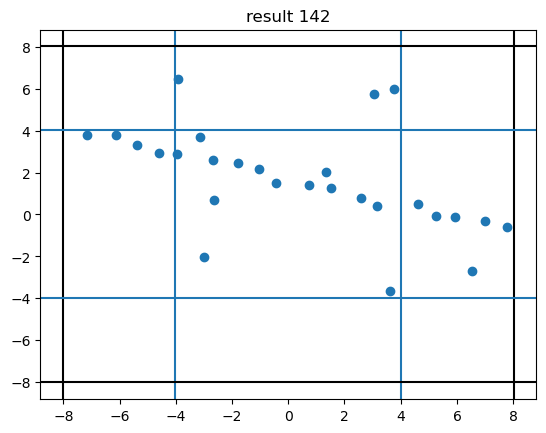

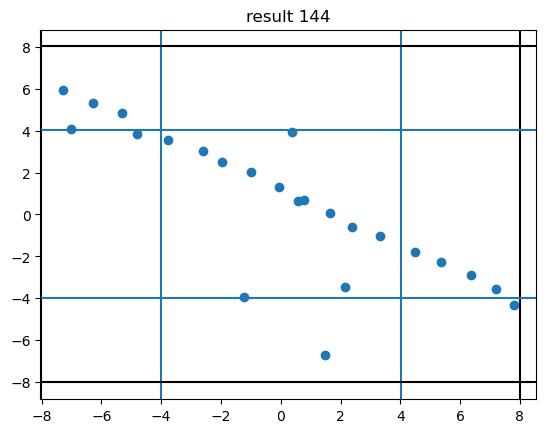

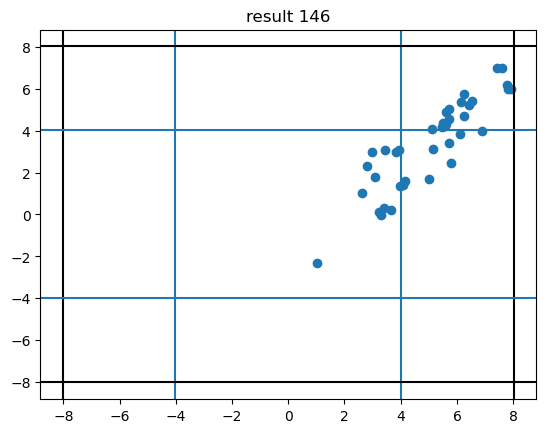

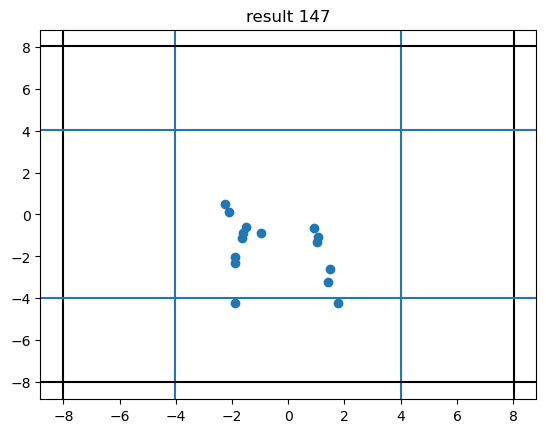

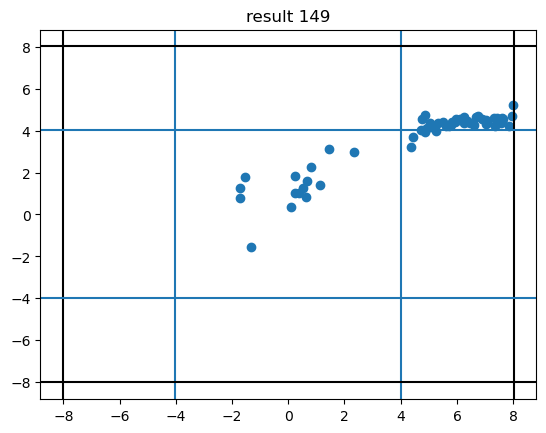

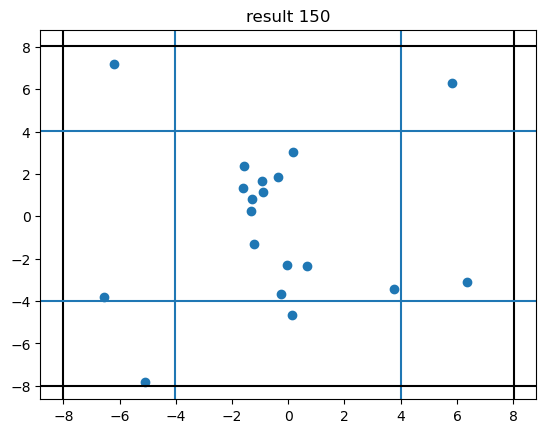

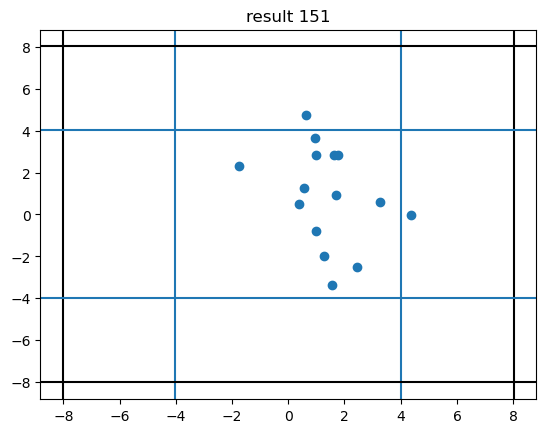

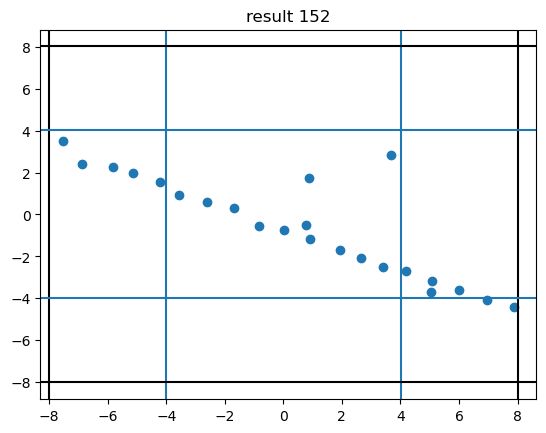

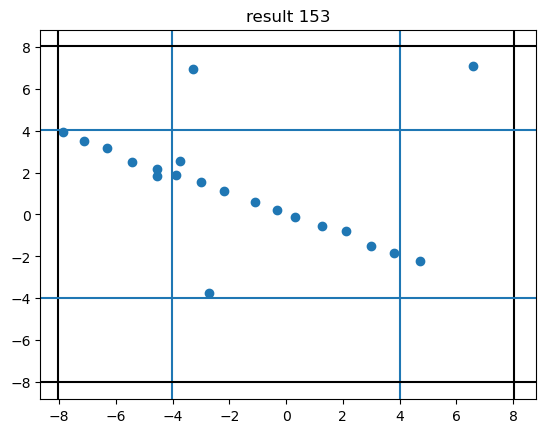

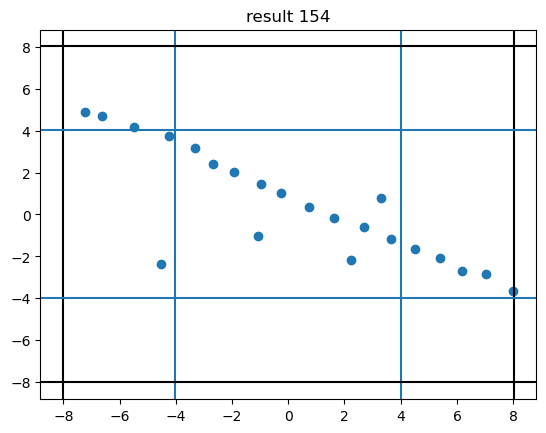

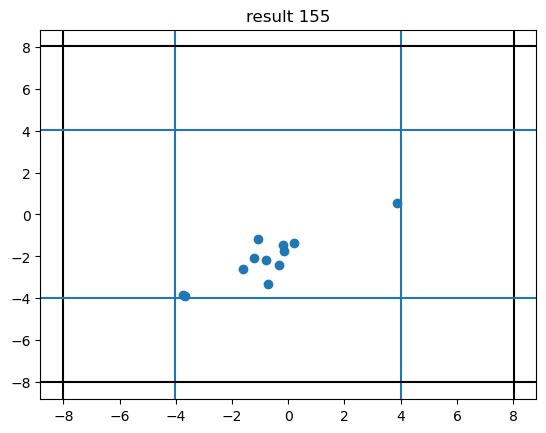

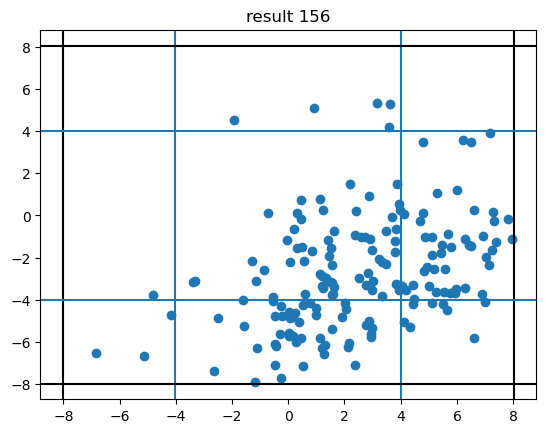

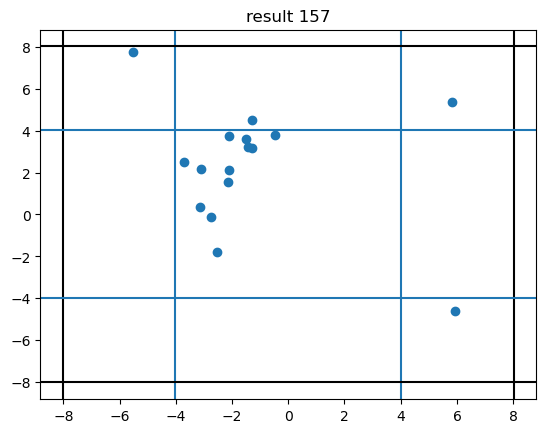

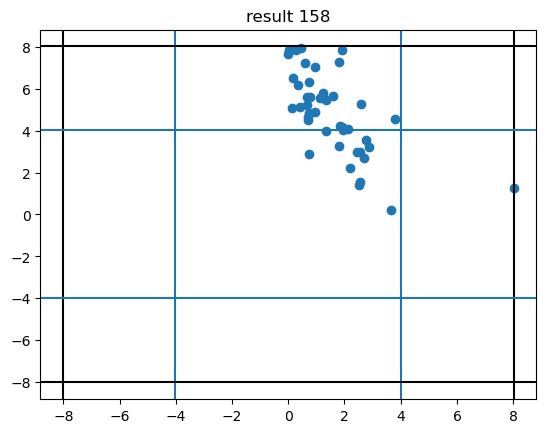

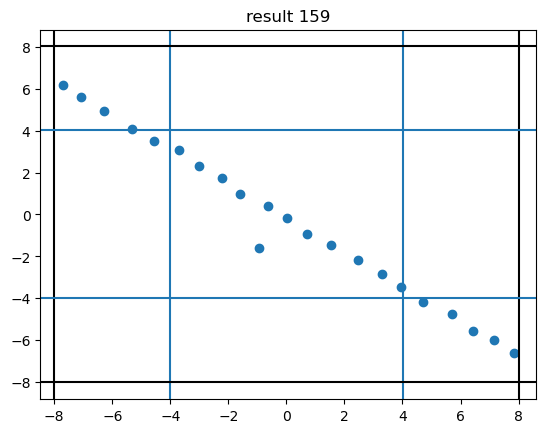

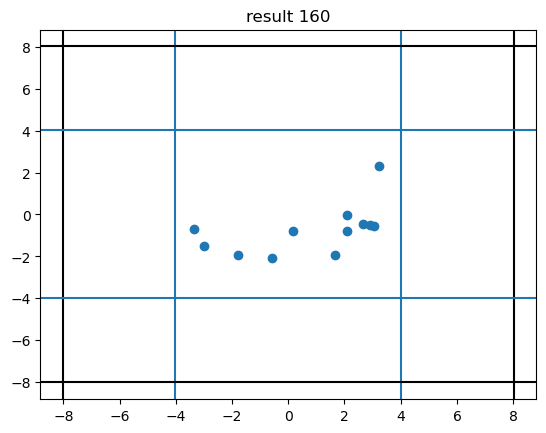

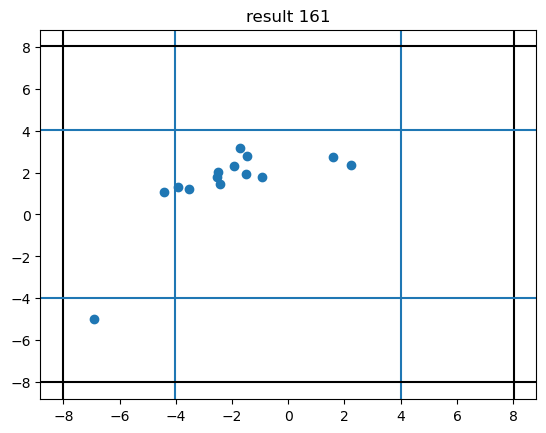

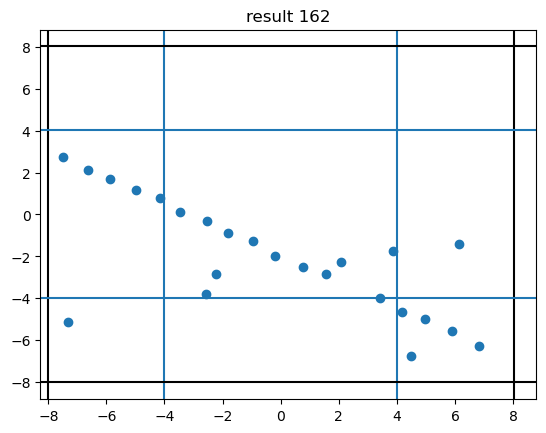

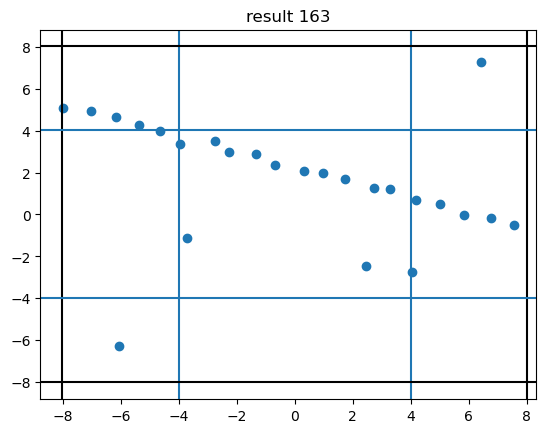

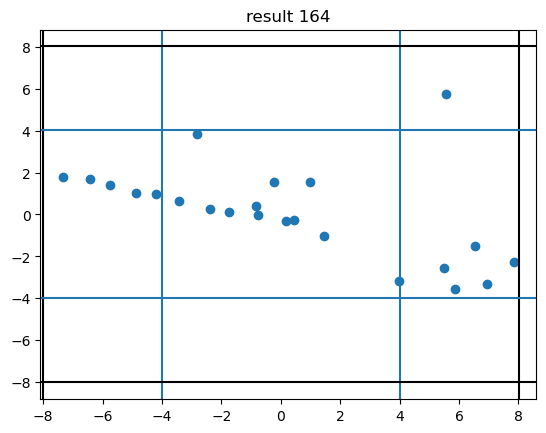

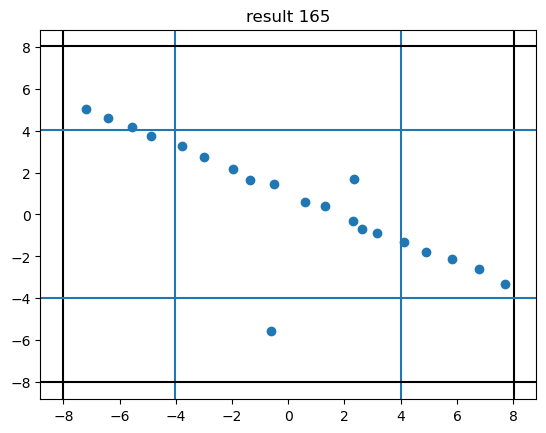

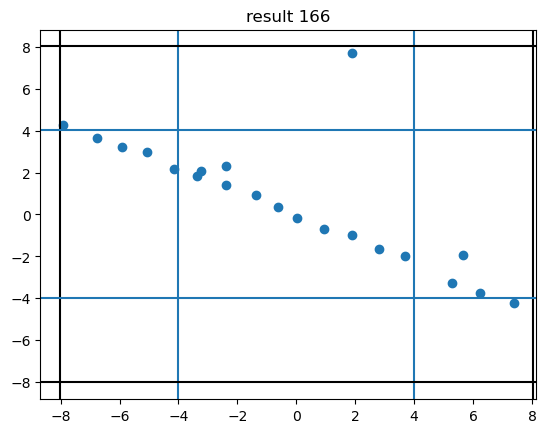

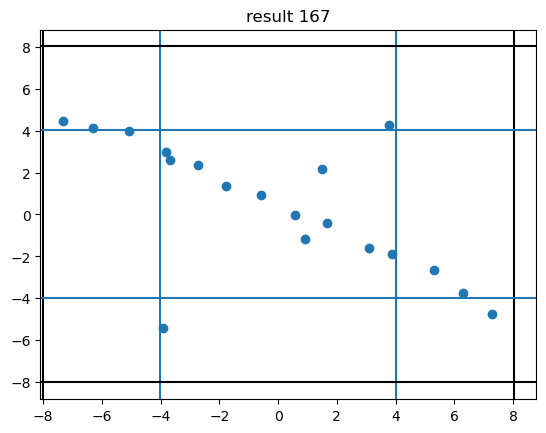

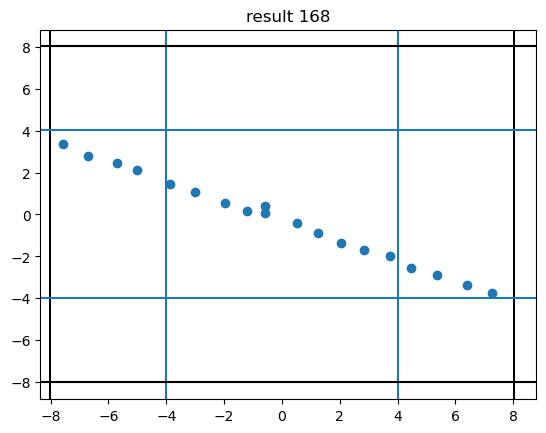

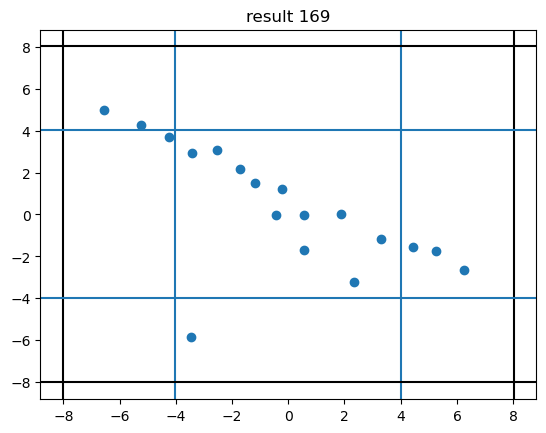

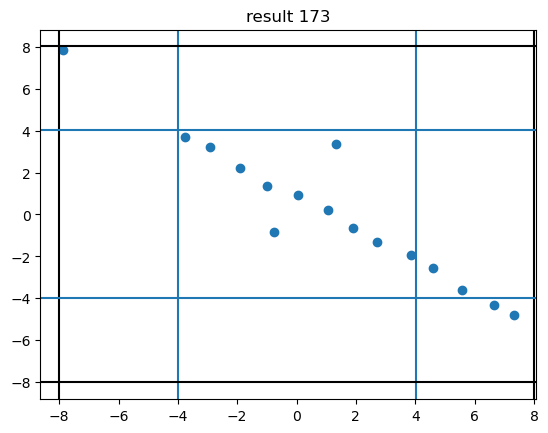

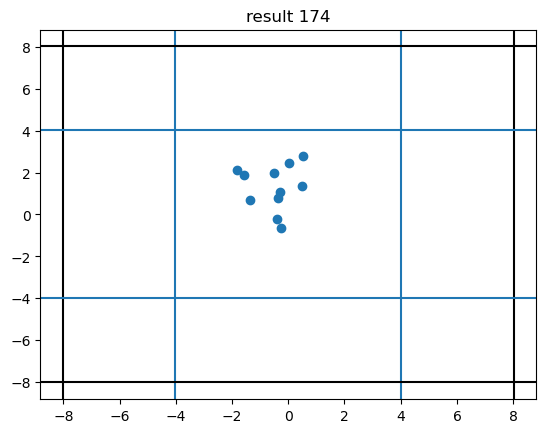

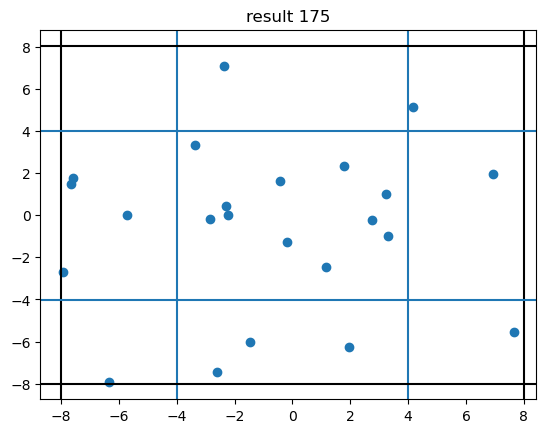

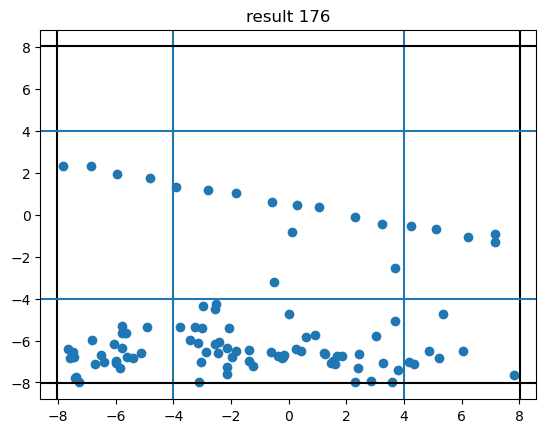

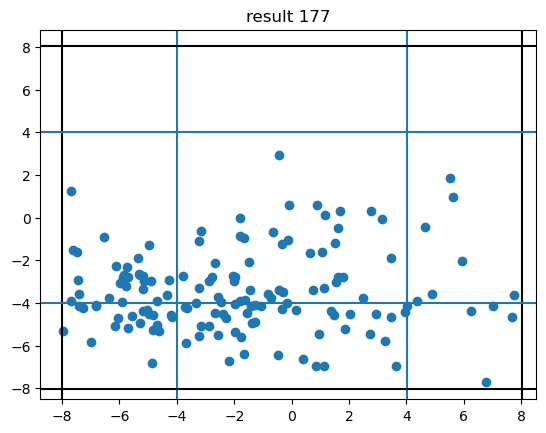

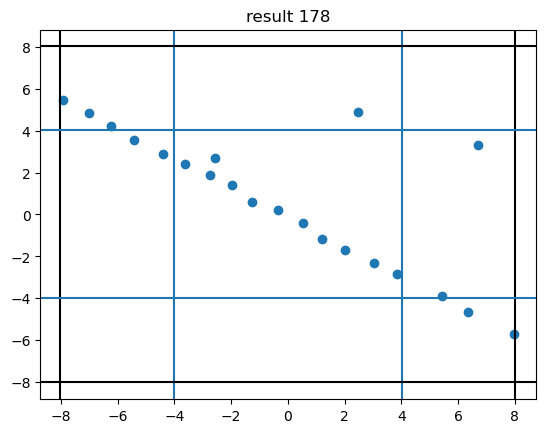

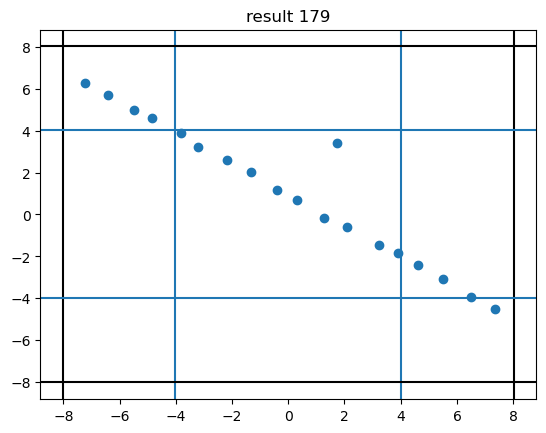

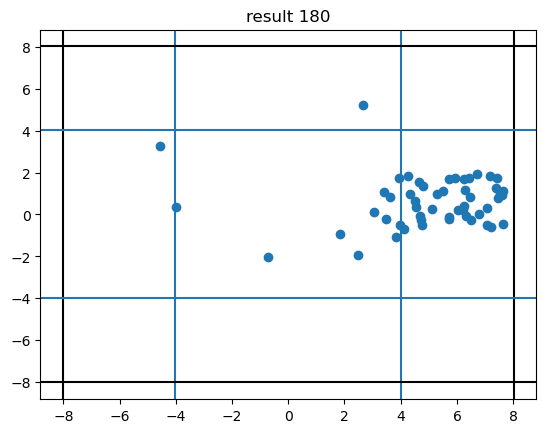

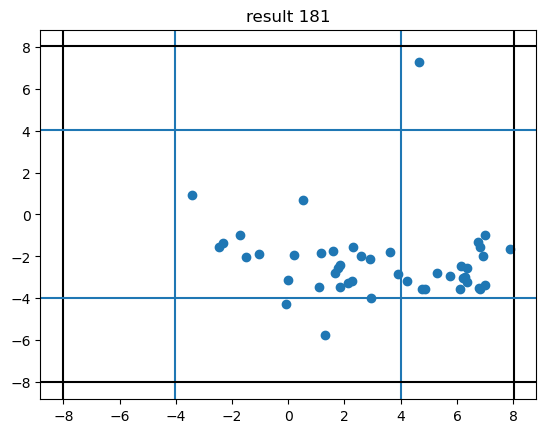

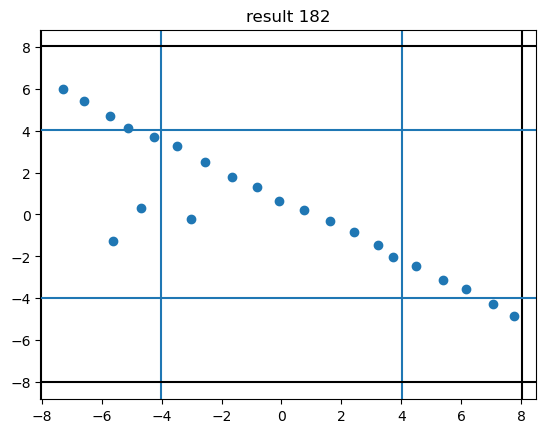

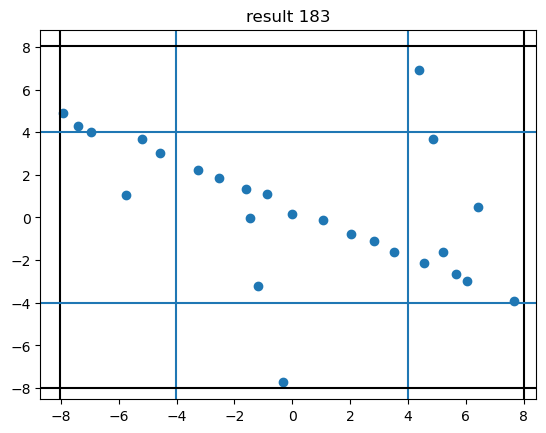

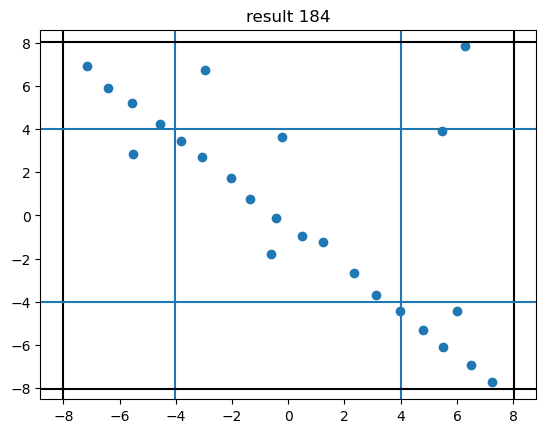

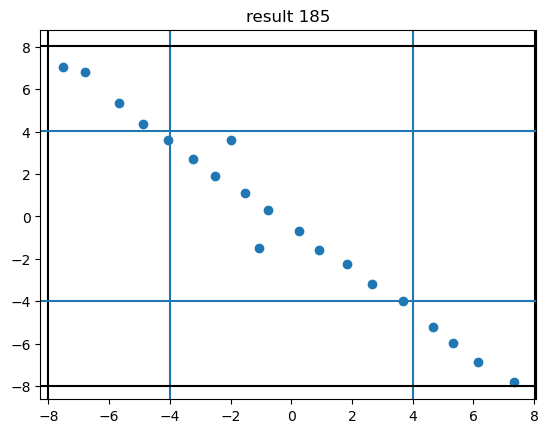

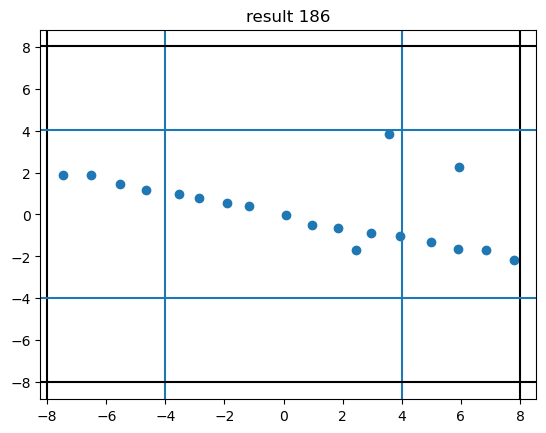

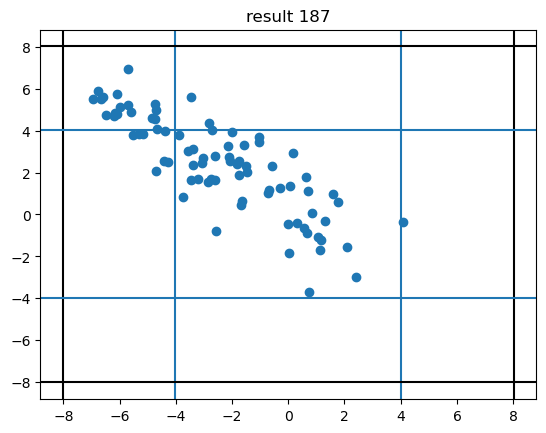

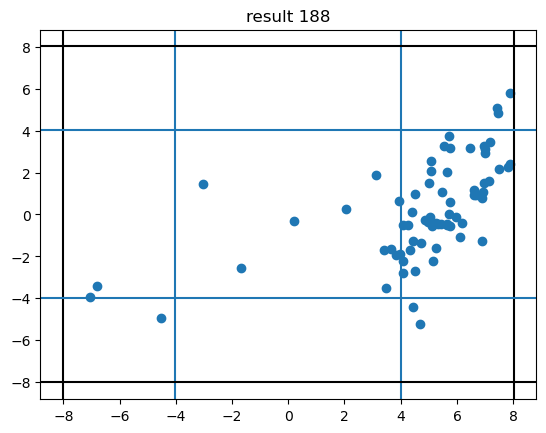

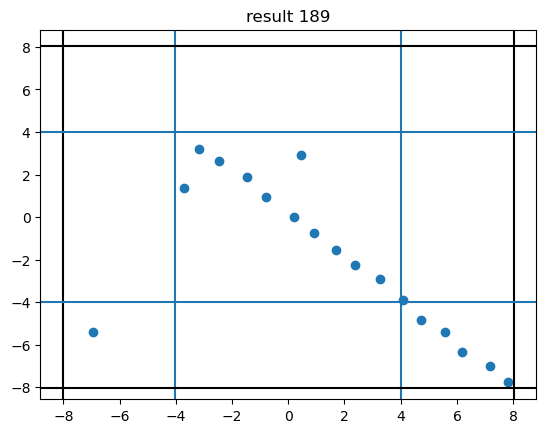

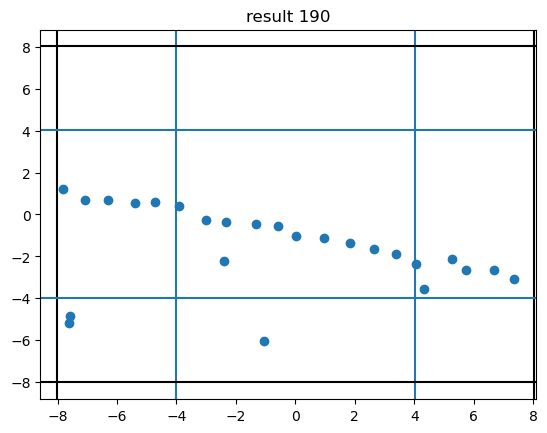

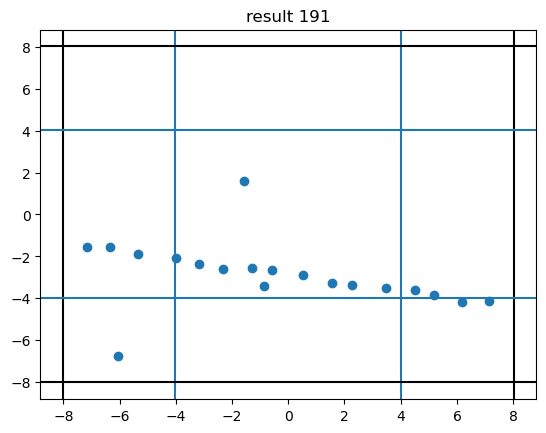

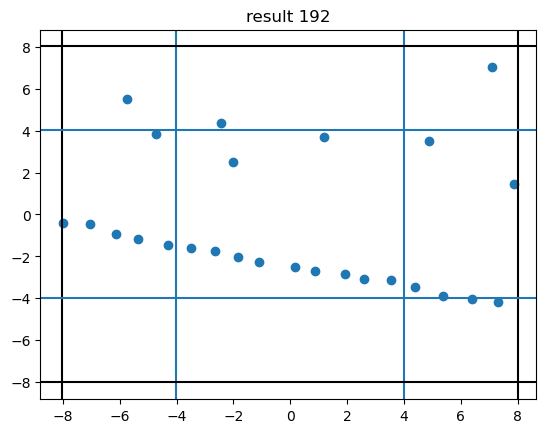

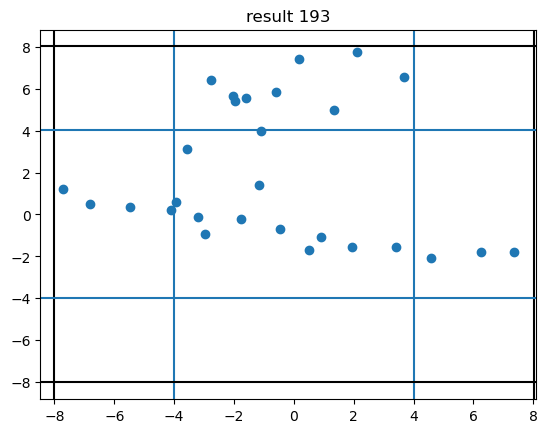

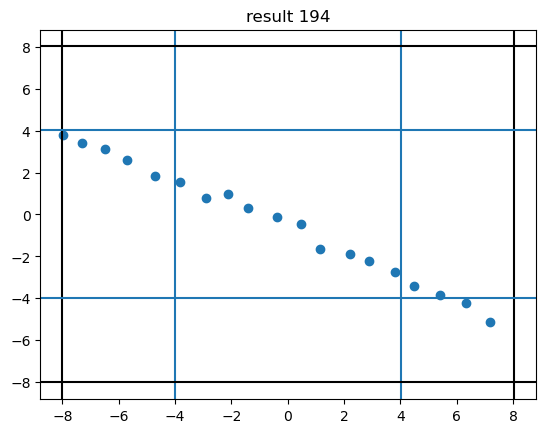

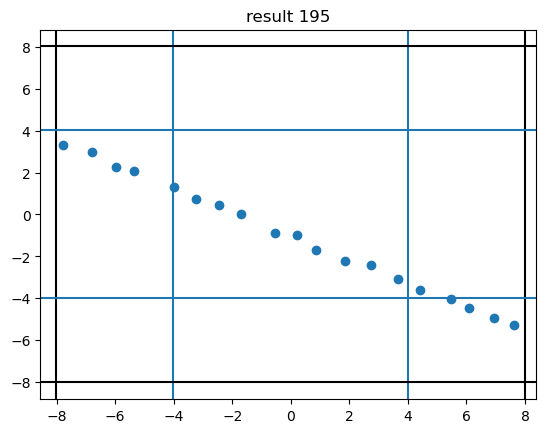

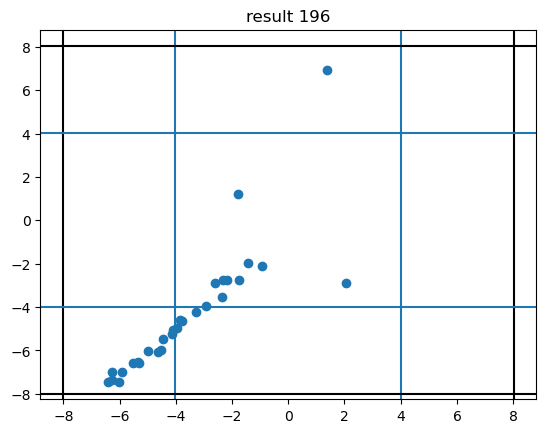

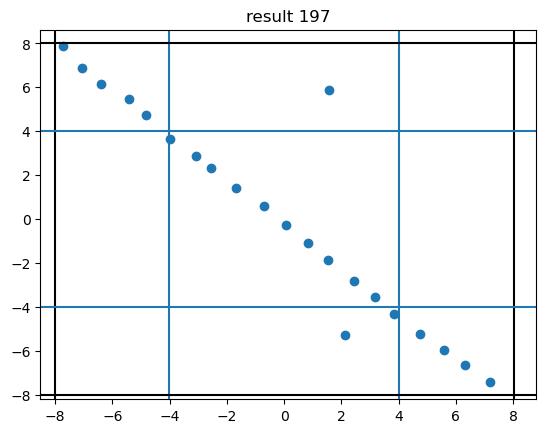

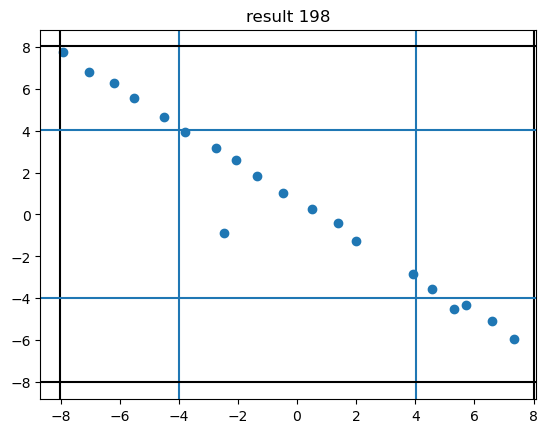

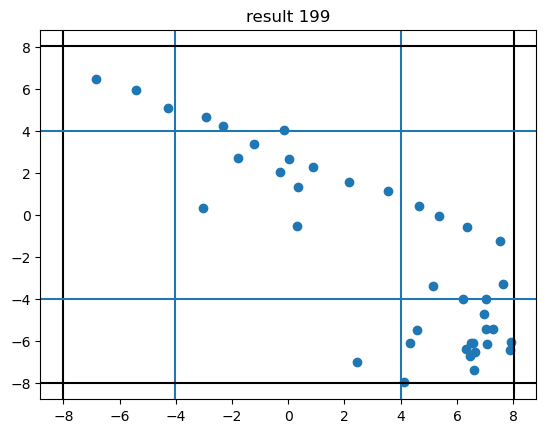

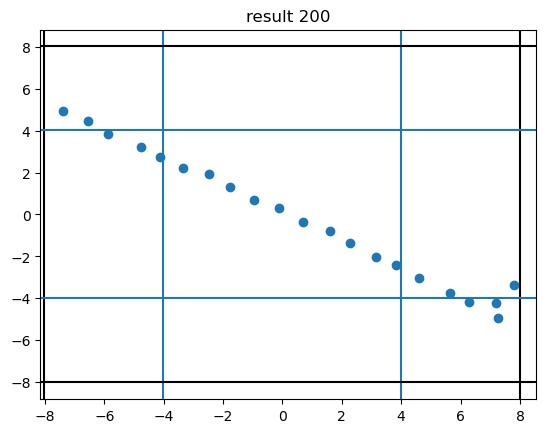

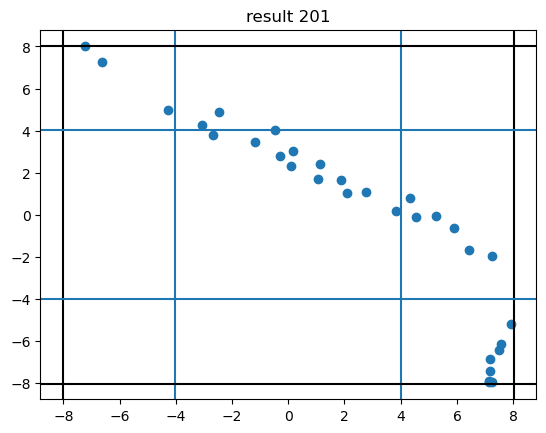

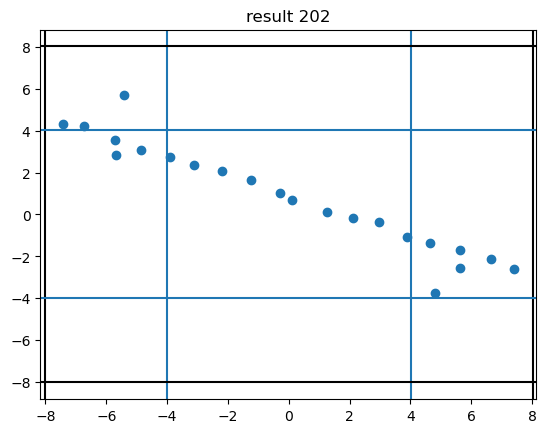

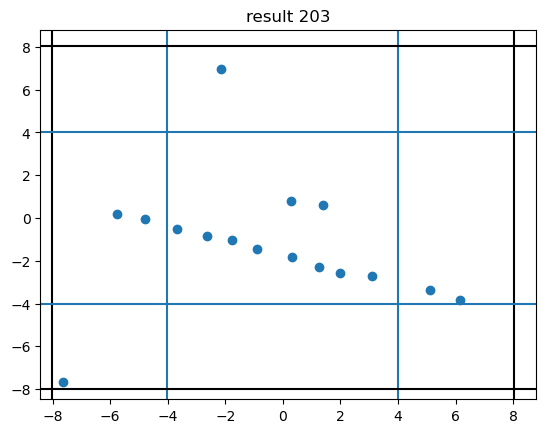

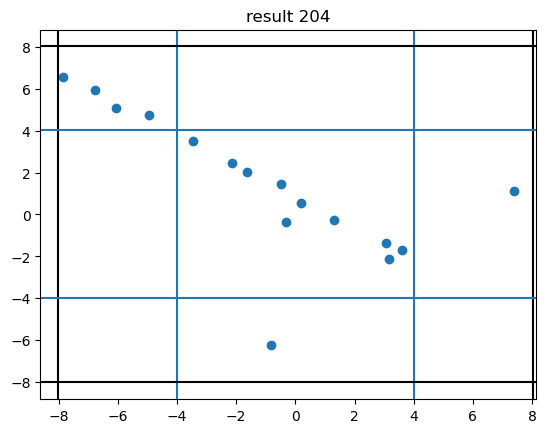

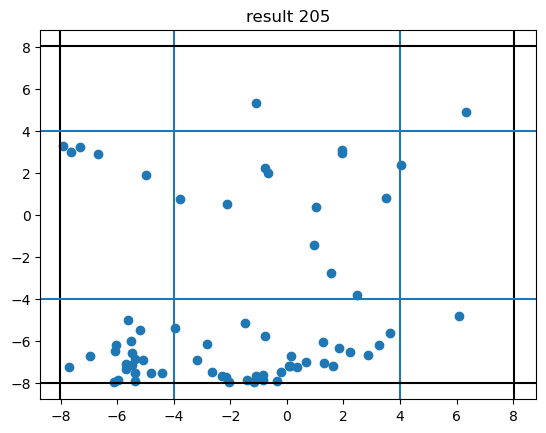

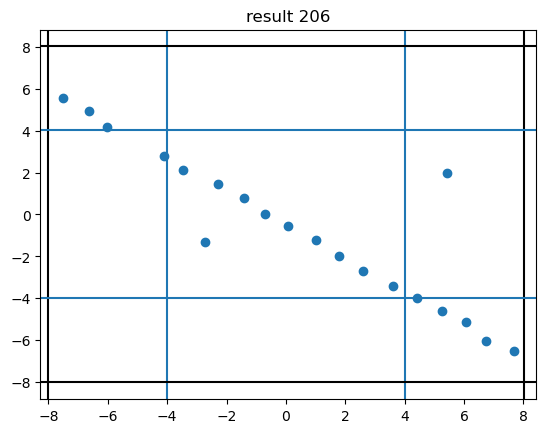

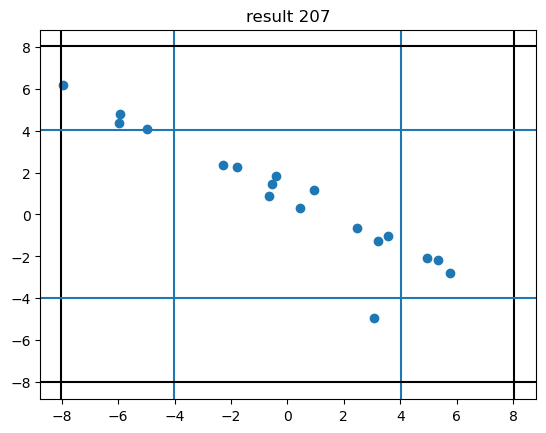

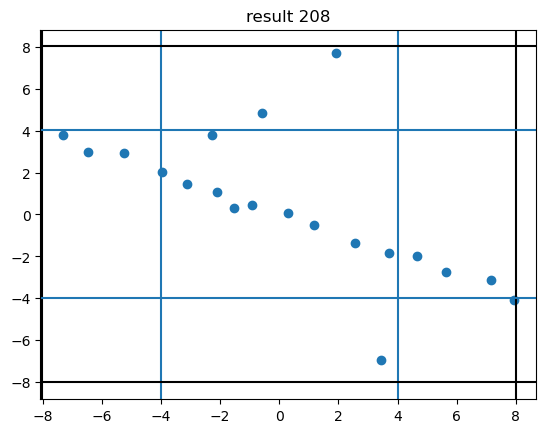

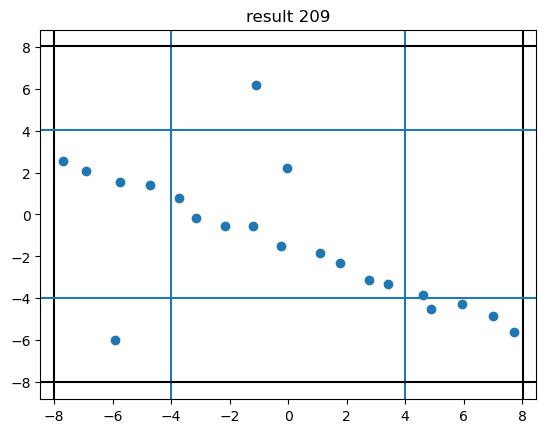

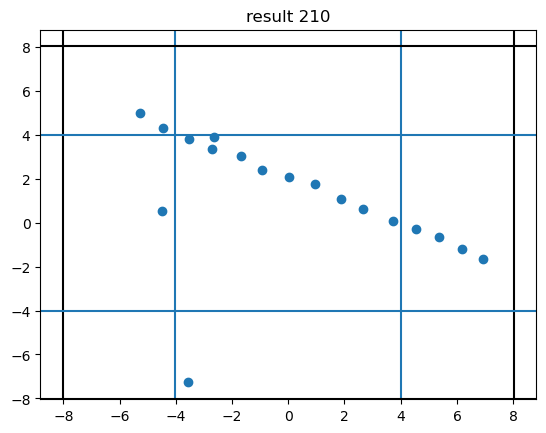

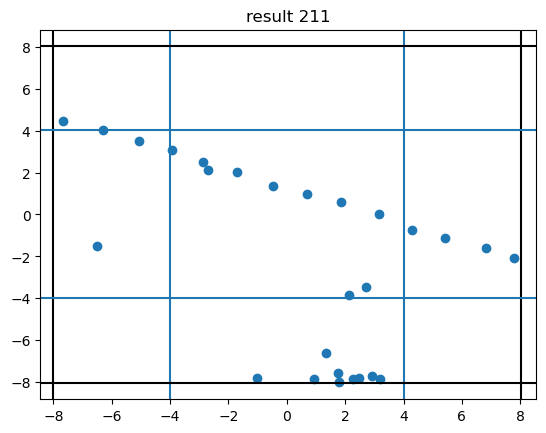

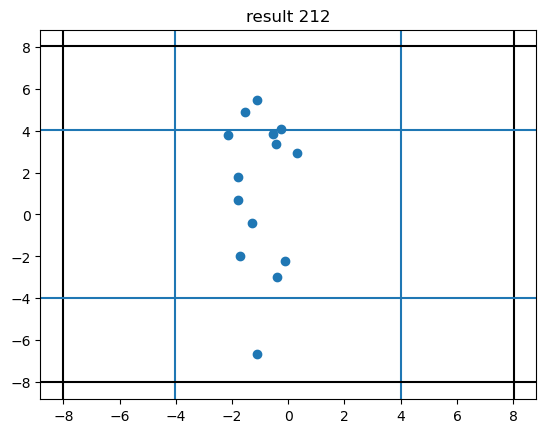

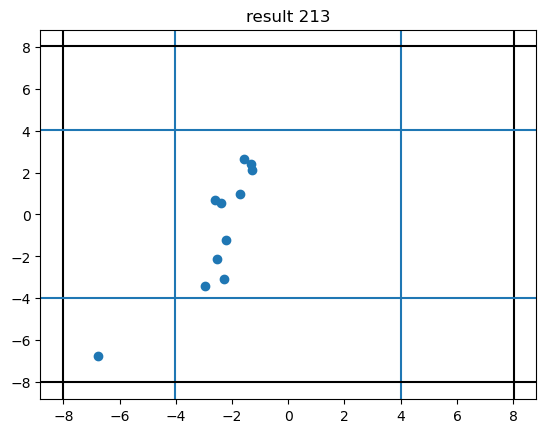

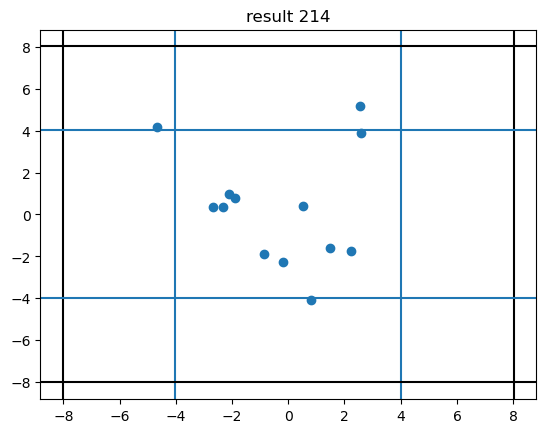

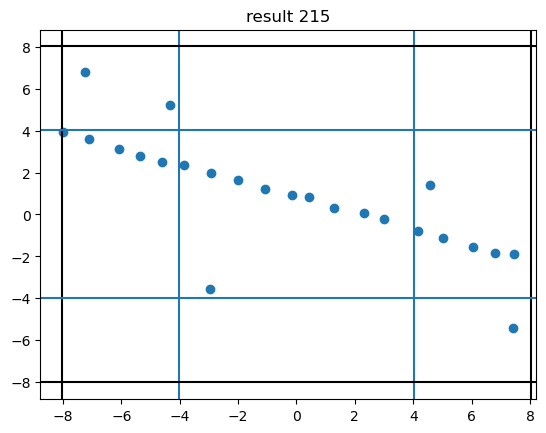

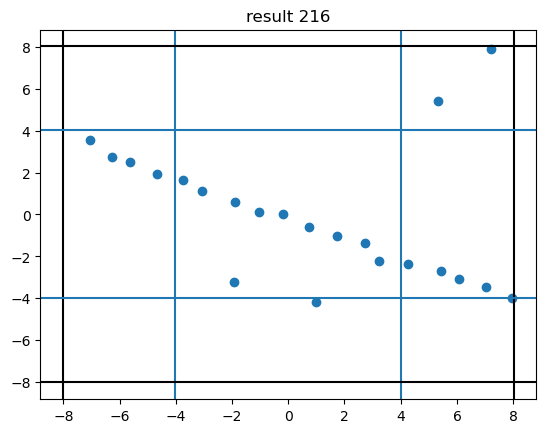

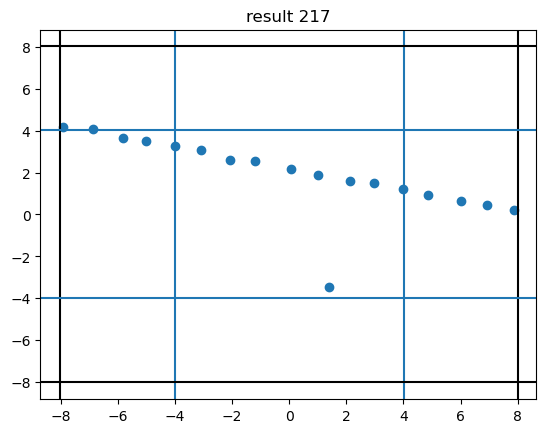

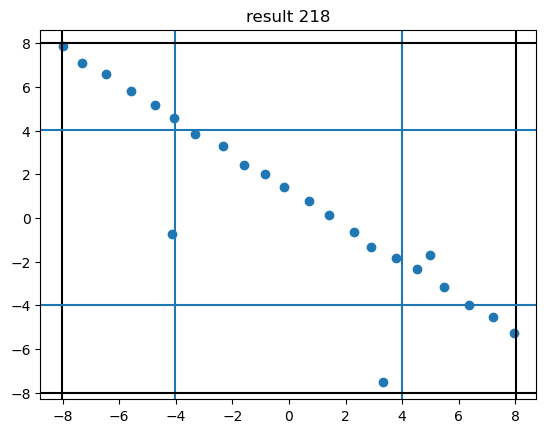

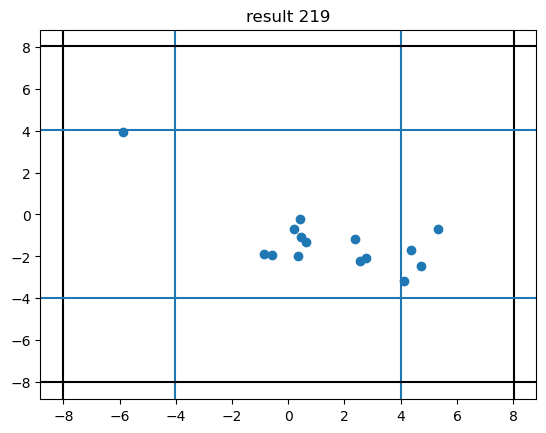

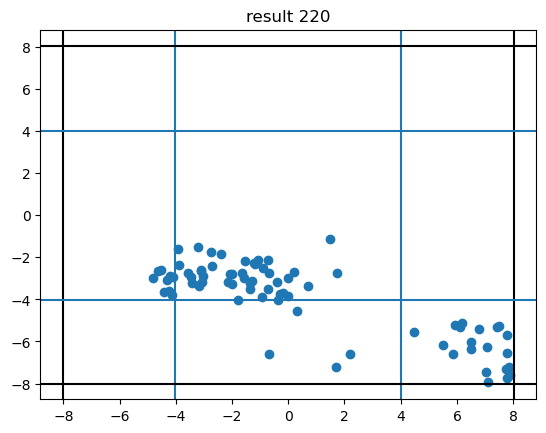

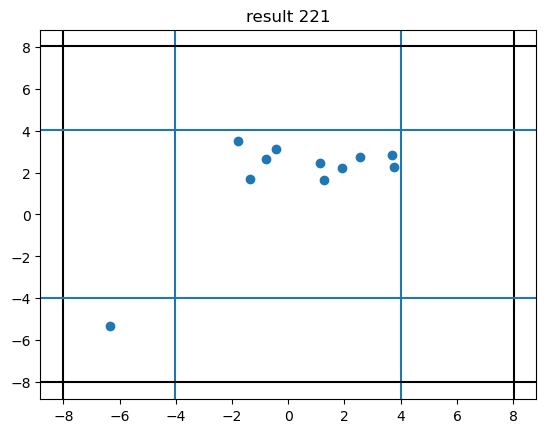

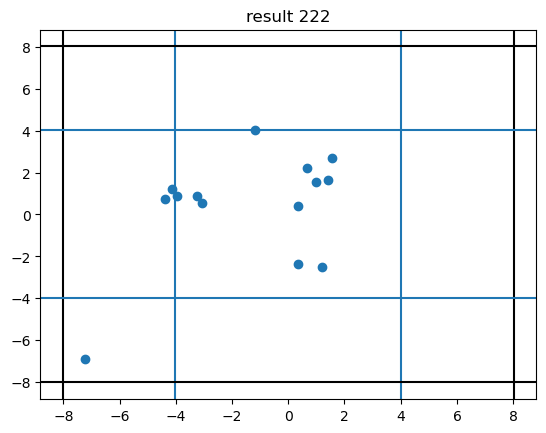

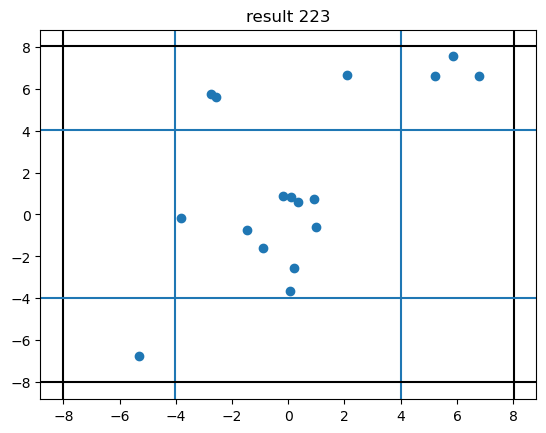

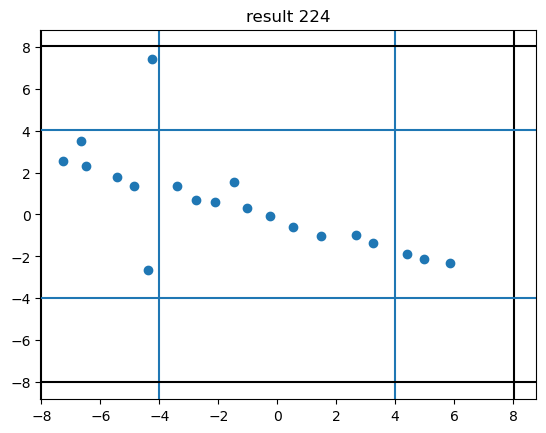

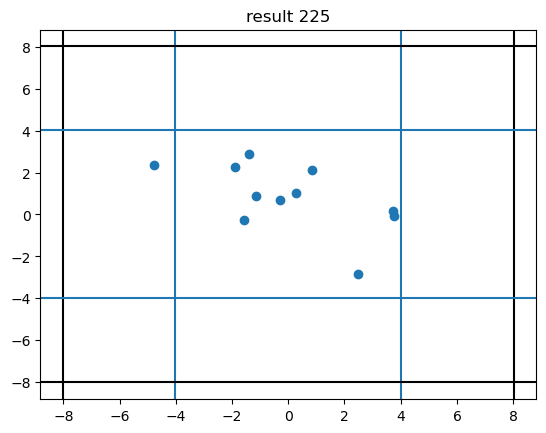

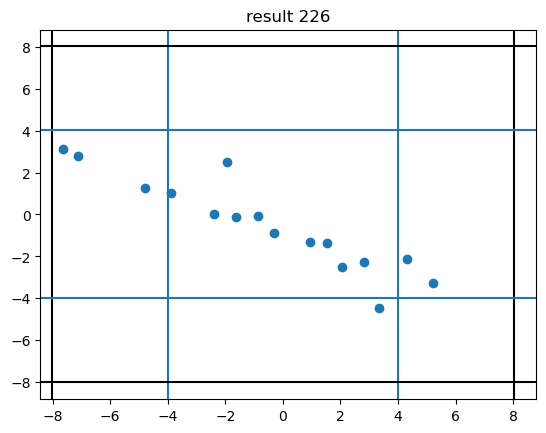

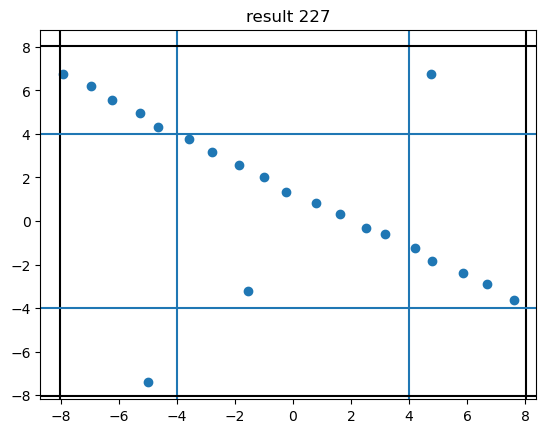

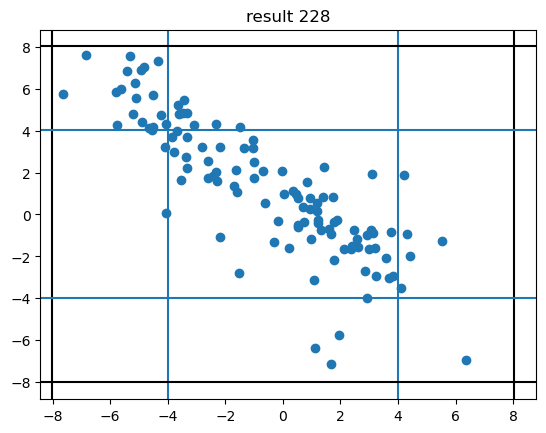

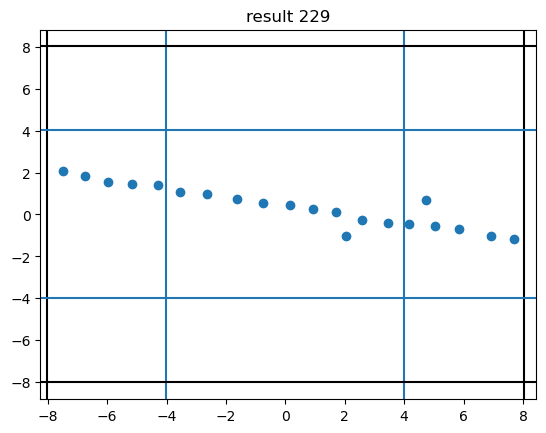

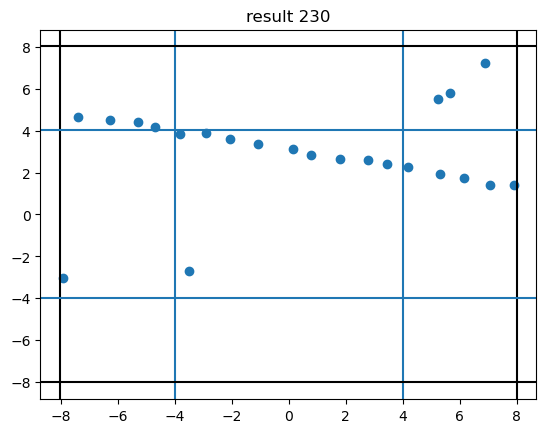

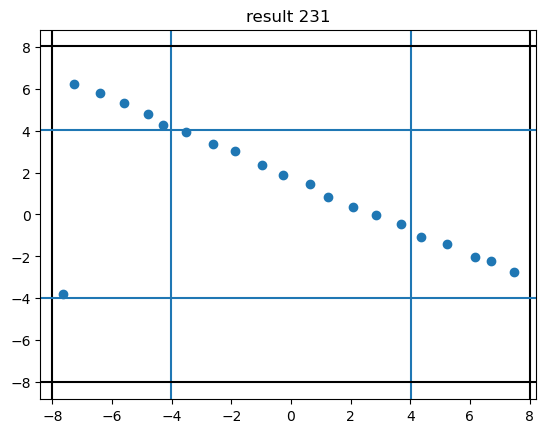

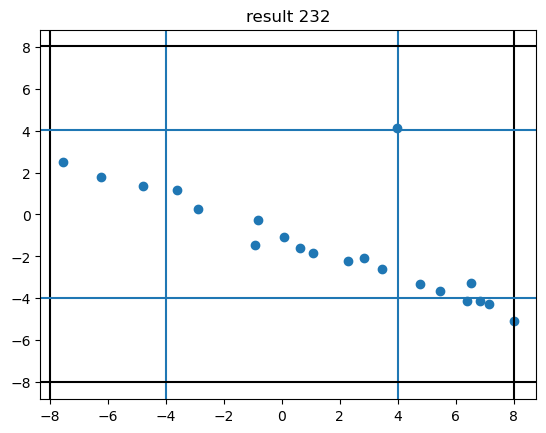

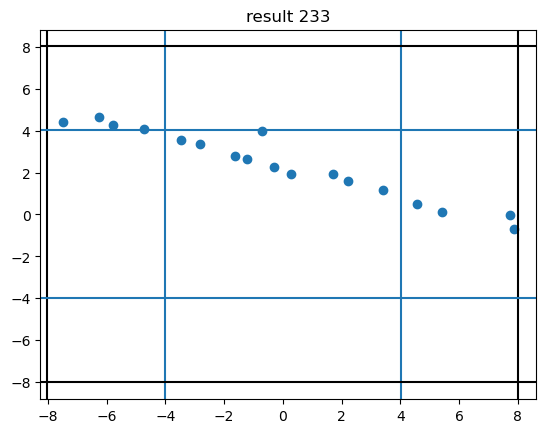

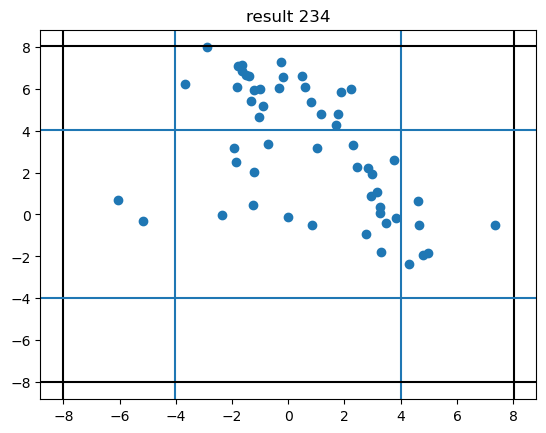

In [13]:
for i in results[nu_th]:
    g = results[nu_th][i].extra['in_range']
    plt.scatter(
        (g[:, 0]*u.deg - results[nu_th][i].line.alpha[0]).to(u.arcsec), 
        (g[:, 1]*u.deg - results[nu_th][i].line.alpha[1]).to(u.arcsec)
    )
    
#     plt.scatter(results[i].line.alpha[0], results[i].line.alpha[1])
    plt.axvline(( + dx/2).value)
    plt.axvline(( + dx).value, color='k')
    plt.axvline(( - dx/2).value)
    plt.axvline(( - dx).value, color='k')
    plt.axhline(( + dx/2).value)
    plt.axhline(( + dx).value, color='k')
    plt.axhline(( - dx/2).value)
    plt.axhline(( - dx).value, color='k')
    plt.title(f"result {i}")
    plt.show()

In [98]:
n = 50
r = {}
for i in results:
    if results[i].extra['votes'] > n:
        r[i] = results[i]


In [17]:
catalog = read(f"../search/tno_search/DEEP/20190403/A0c/detector_1/snr_4.0/regular/catalog.pkl")
recovery = {}
for nu_th in results:
    print(nu_th)
    recovery[nu_th] = recover(
        fakes, 
        results[nu_th], 
        catalog
    )

4
3
2
1
0


In [18]:
recovery_results = {}
for nu_th in recovery:
    recovery_results[nu_th] = make_results(
        fakes, 
        recovery[nu_th], 
        vmin, vmax, 
        0*u.deg, 359*u.deg, 
        metric='points', 
    )
    

In [32]:
for nu_th in recovery_results:
    print(nu_th)
    r = recovery_results[nu_th][recovery_results[nu_th]['findable']]
    r.sort("mag")
    print(r[['orbit', 'v', 'phi', 'mag', 'found', 'votes']])

4
 orbit           v                  phi                mag         found votes
              deg / d               deg                                       
------- -------------------- ------------------ ------------------ ----- -----
5962014 0.013612382654722257 163.04163601016464 24.547227600193064 False    -1
2405372 0.019558461629477754 168.39825700754162 24.573885428055313 False    -1
4279478 0.012096529156942875 155.47319226296221  24.78000547555636 False    -1
2732908 0.012082481222041624 161.52027795964636  25.68617649738313 False    -1
5182786  0.00814373039496204 154.64506986598138 26.158283666804156 False    -1
3881210 0.009545628956146747  161.1472486254834 26.306819324841076 False    -1
3898678 0.014735776461058392  162.3771570720673  26.47601778348476 False    -1
6009903 0.014750418844791795 167.89854794126813 26.851329609695888 False    -1
3
 orbit           v                  phi                mag         found votes
              deg / d               deg         

In [30]:
recovery[4][2405372]['catalog']['snr']

<Column name='significance' dtype='float64' length=6>
4.030031681060791
4.089725494384766
4.416759490966797
4.071824550628662
4.257692337036133
4.300143241882324

In [130]:
v = 0.014735776461058392 * u.deg/u.day
phi = 162.3771570720673 * u.deg
vx = np.cos(phi) * v
vy = np.sin(phi) * v

# print(vx, vy)
directions = SearchDirections(None, None, dx, dt, b=np.array([[vx.value, vy.value]]) * u.deg/u.day)
projection = project(X, directions, reference_epoch)
hough = Hough(projection, dx, dx)
r = {}
for i, cluster in enumerate(hough):
    n = cluster.extra['votes'] 
    if n < 40:
        break
    r[i] = cluster
# plt.hist(hough.array.flatten())
# plt.show()

In [148]:
rec = recover(fakes, r, catalog)
make_results(
    fakes, 
    rec, 
    vmin, vmax, 
    0*u.deg, 359*u.deg, 
    metric='points'
)

<Table length=16>
 orbit             v                   phi         ... detected binary votes
                deg / d                deg         ...                      
 int64          float64              float64       ...  int64    bool  int64
-------- --------------------- ------------------- ... -------- ------ -----
 2405372  0.019558461629477754  168.39825700754162 ...       66  False    56
 2732908  0.012082481222041624  161.52027795964636 ...        0  False    -1
 3881210  0.009545628956146747   161.1472486254834 ...       30  False    -1
 3898678  0.014735776461058392   162.3771570720673 ...        5  False    -1
 4279478  0.012096529156942875  155.47319226296221 ...       52  False    -1
 5182786   0.00814373039496204  154.64506986598138 ...       16  False    -1
 5485151 0.0006330107597850406  160.07987686781578 ...        3  False    -1
 5962014  0.013612382654722257  163.04163601016464 ...       59  False    66
 6009903  0.014750418844791795  167.89854794126813 ...        0  False    -1
10041343   0.30702379948299463 -162.08661737780673 ...      100  False    -1
10053463   0.14824504843072245  178.86702433074228 ...       37  False    -1
10564514   0.16790723638445615  134.47923530608296 ...        0  False    -1
13039521   0.14022415929016016  178.66220420098938 ...       27  False    -1
13776855    0.2224553308107336   124.1708183288143 ...       75  False    -1
14621325   0.21134127320918783   134.2705220870682 ...       83  False    -1
14813564   0.16163564802652916 -173.90971893448446 ...       80  False    -1

In [146]:
23.5 + (5/2) * np.log10(5/1.86)

24.573642650295255

In [145]:
5 / 10**((2/5)*(24.573885428055313 - 23.5))

1.8595841382567386

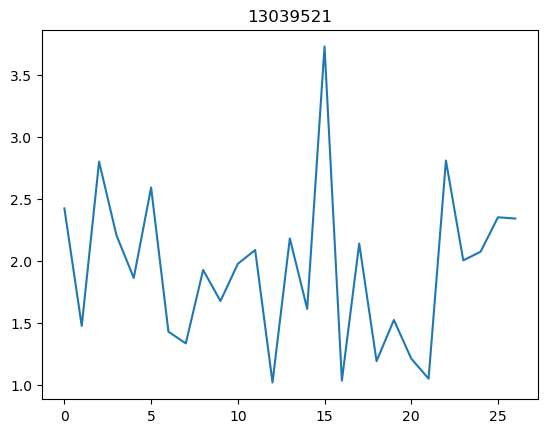

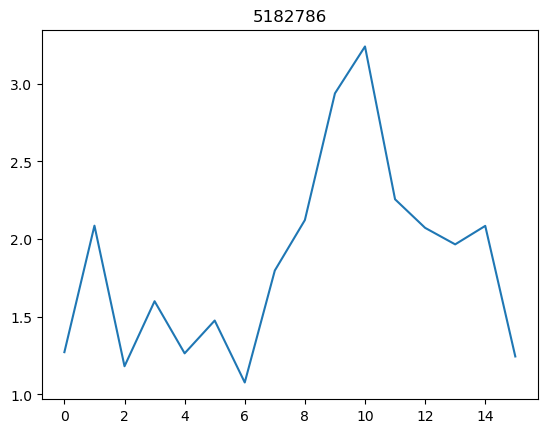

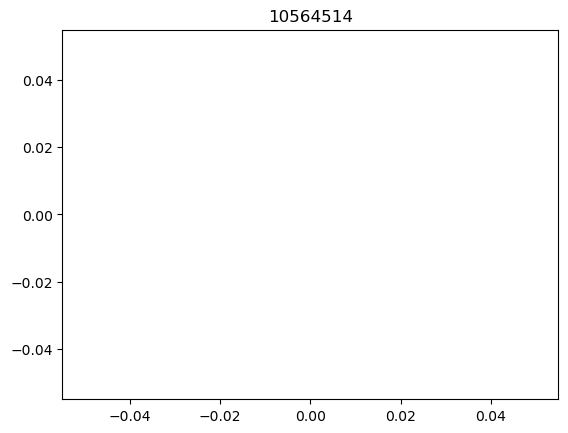

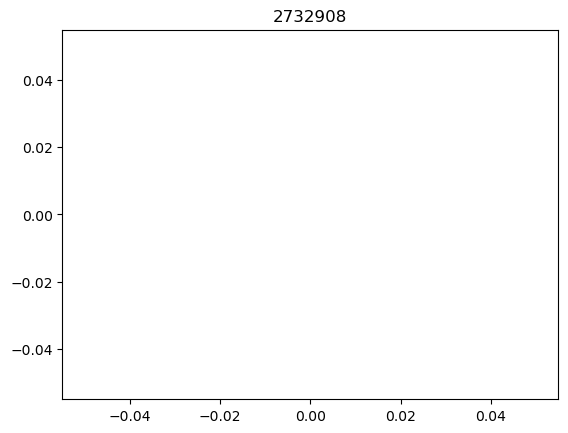

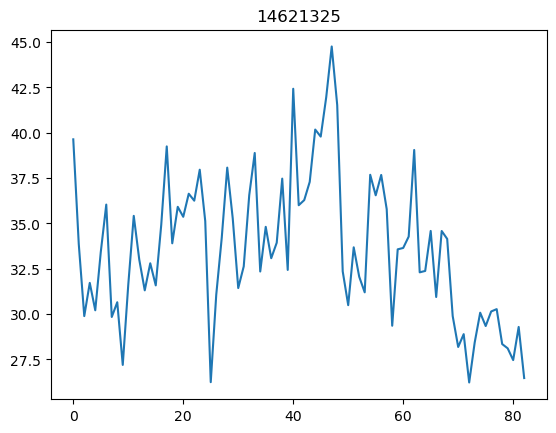

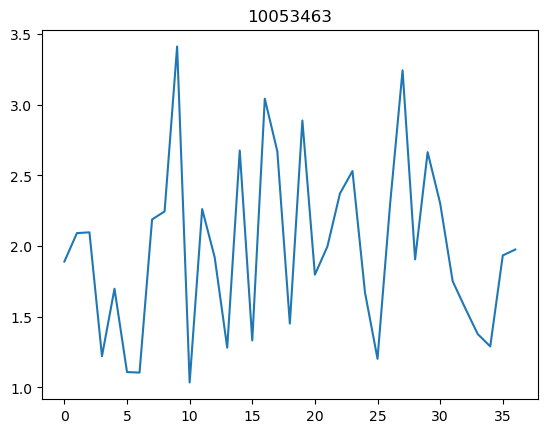

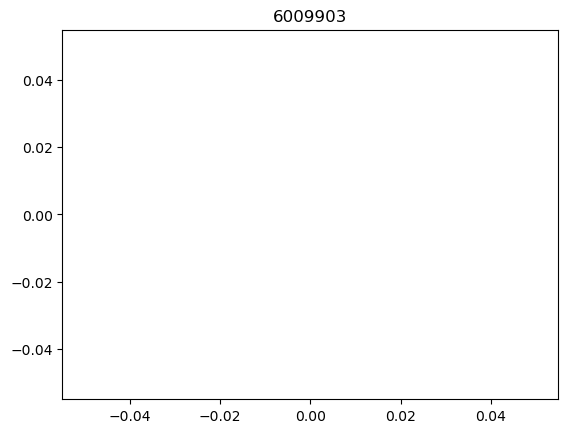

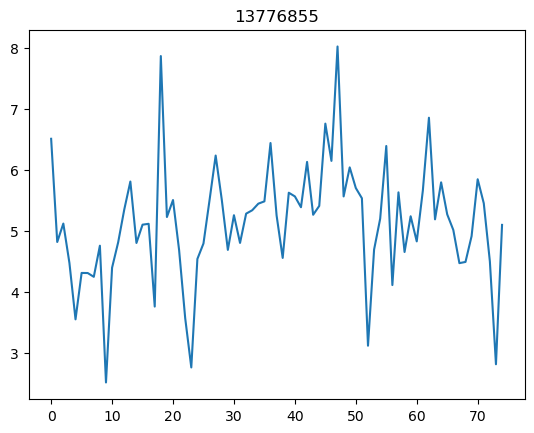

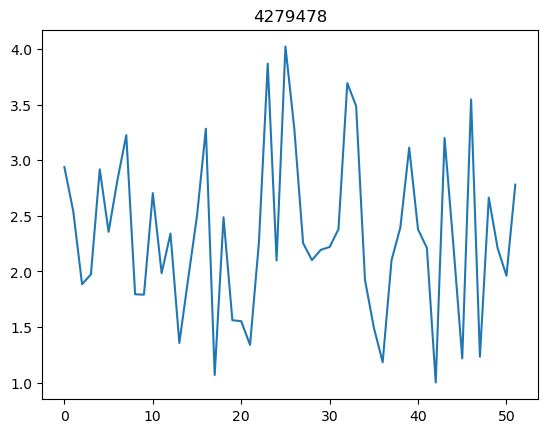

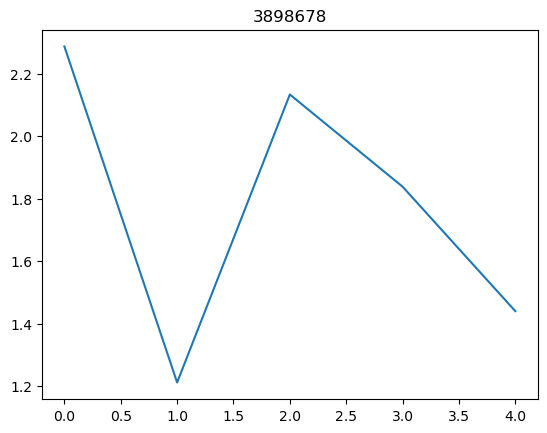

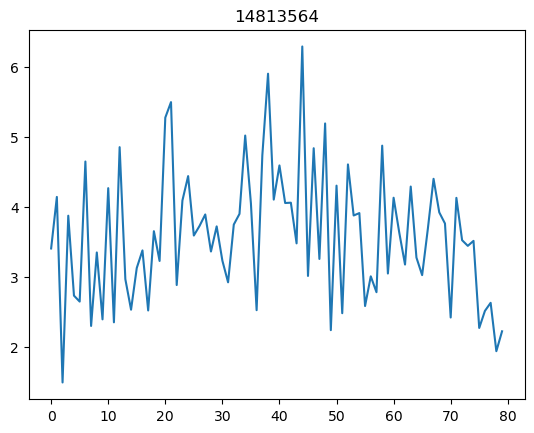

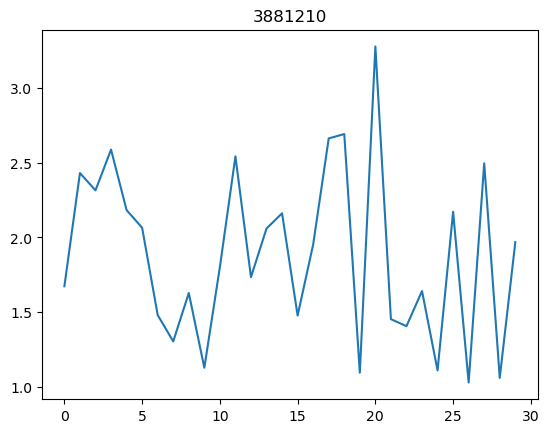

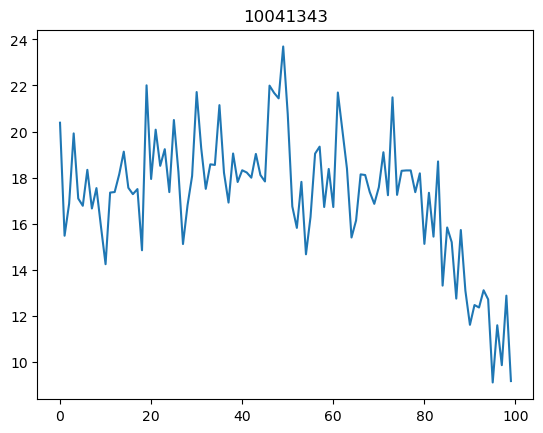

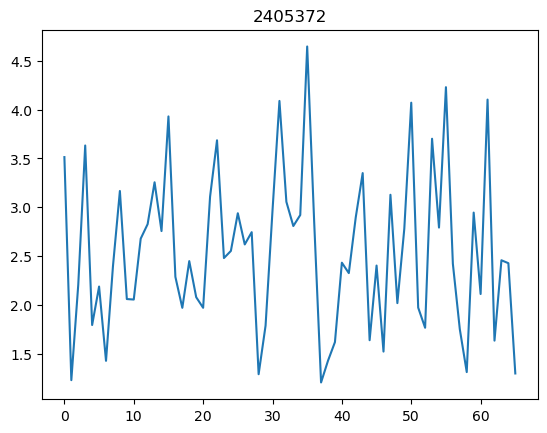

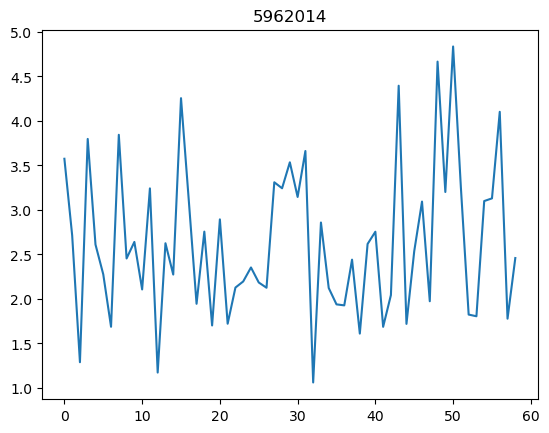

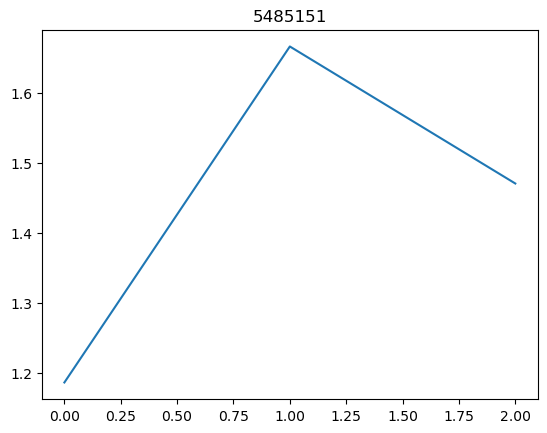

In [154]:
for k in rec:
    plt.plot(rec[k]['catalog']['snr'])
    plt.title(k)
    plt.show()

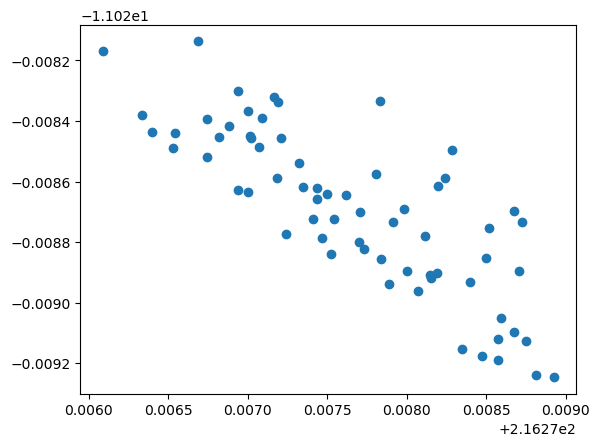

In [150]:
plot_cluster(r[0])

In [24]:
from salad.primitives import transform_to_xy_prime

In [54]:
from salad.analysis.plot import plot_cluster

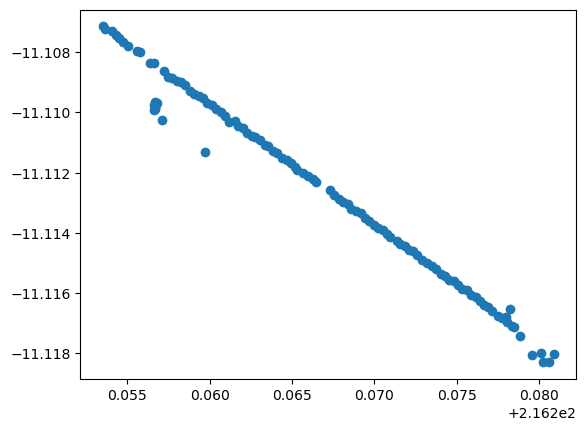

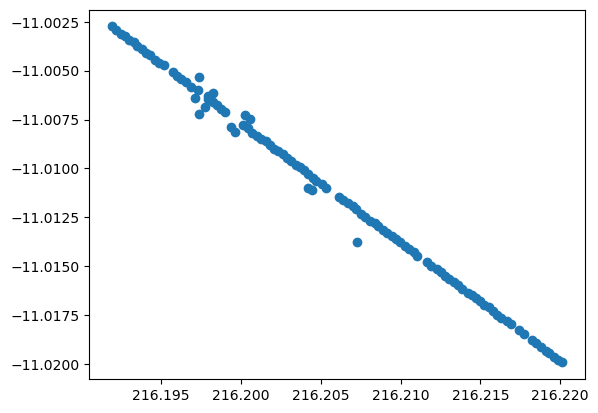

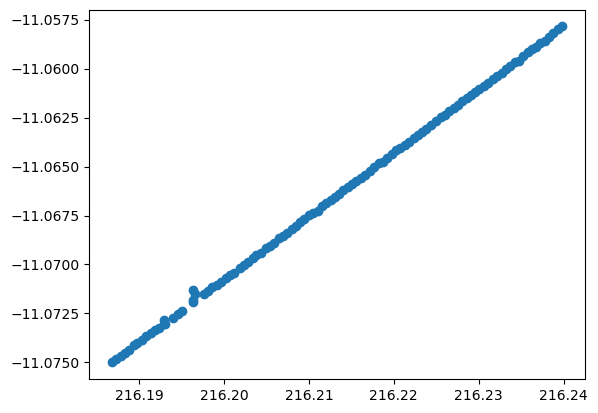

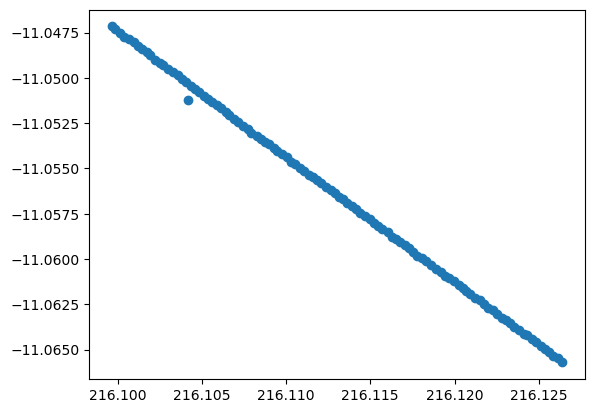

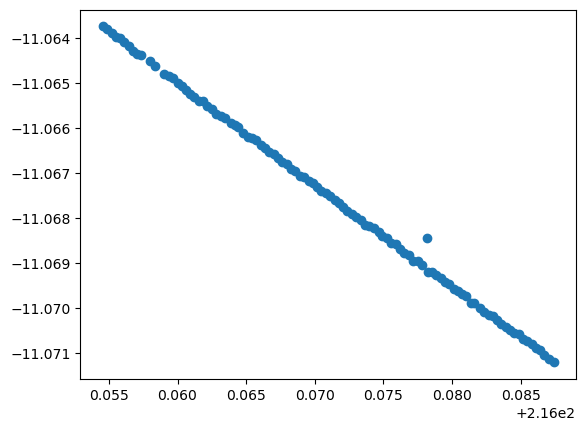

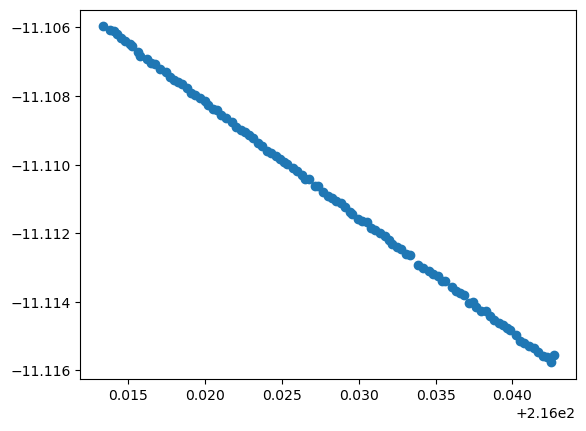

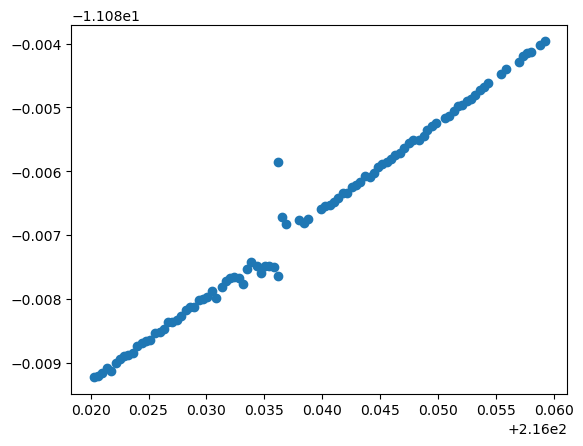

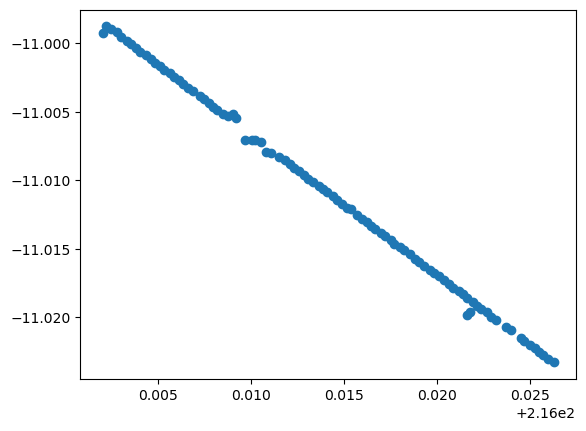

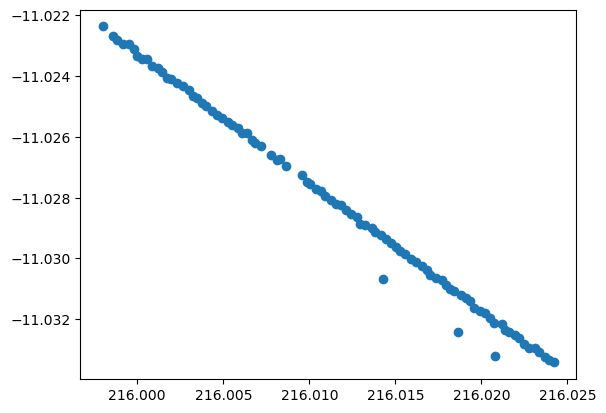

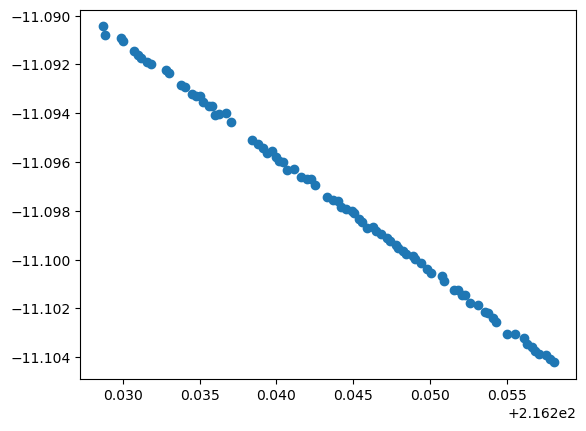

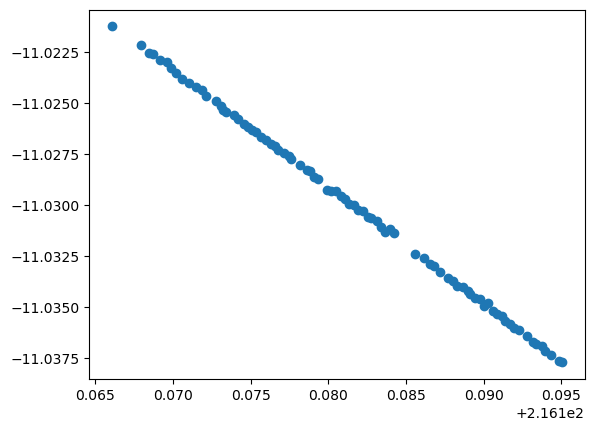

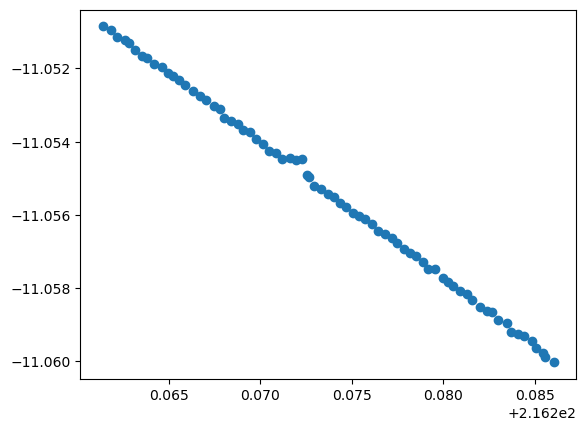

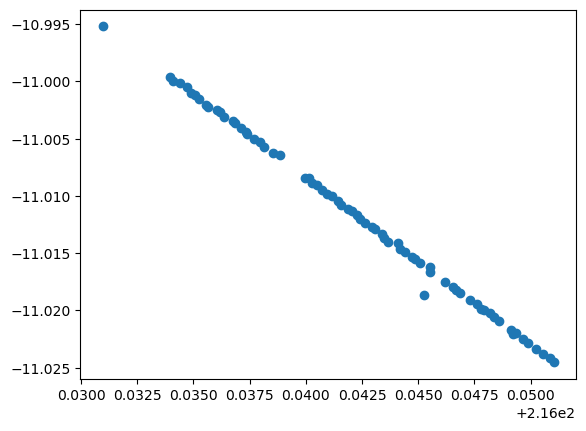

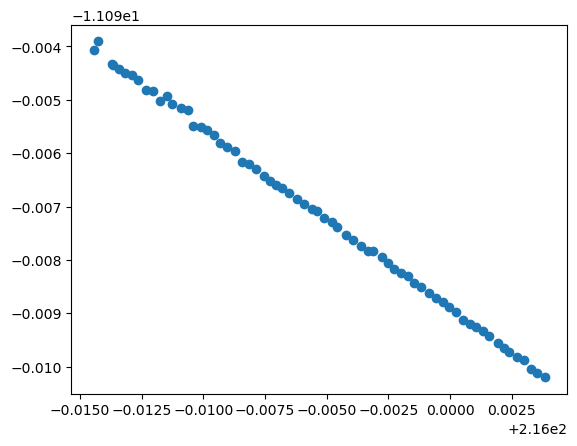

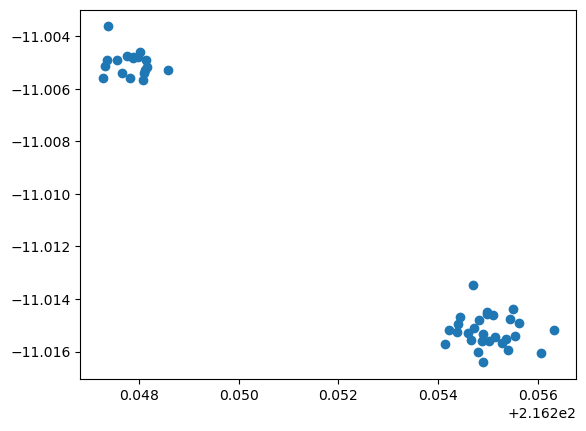

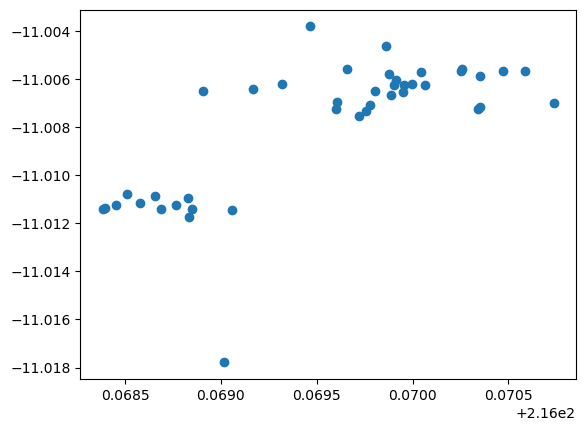

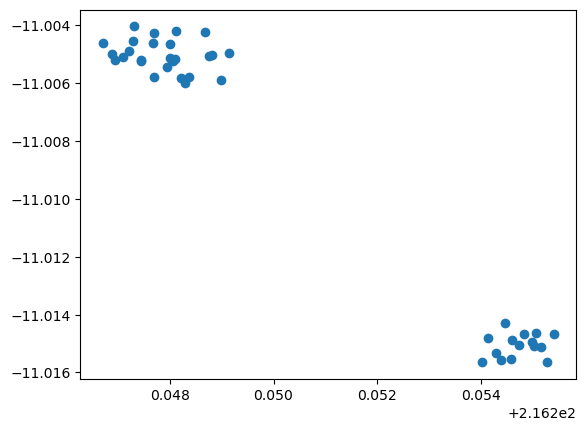

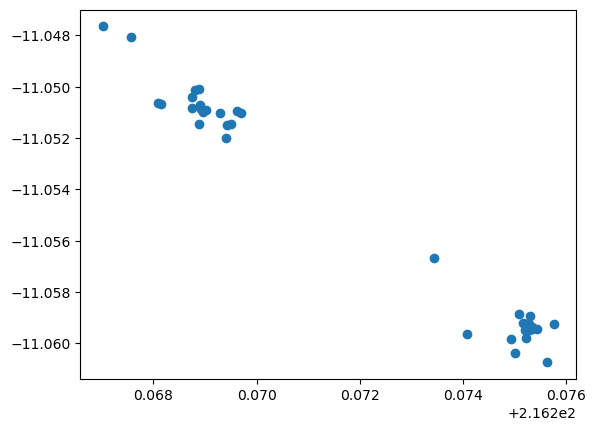

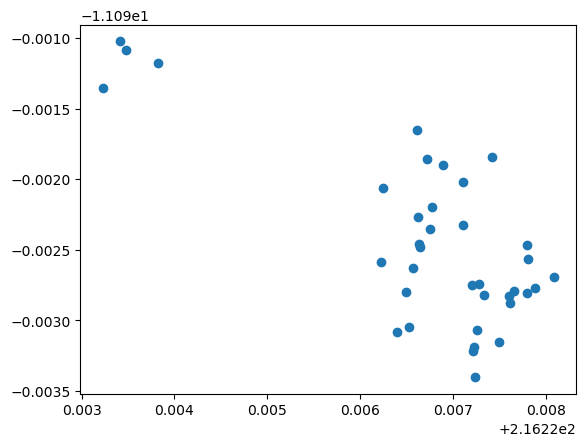

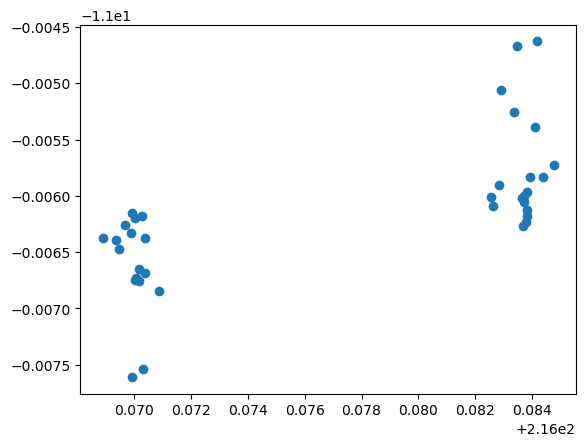

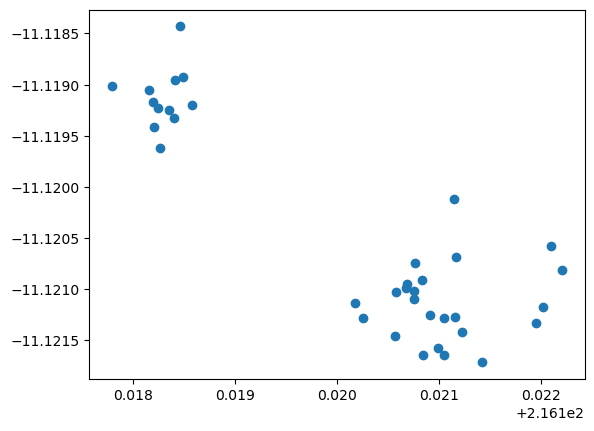

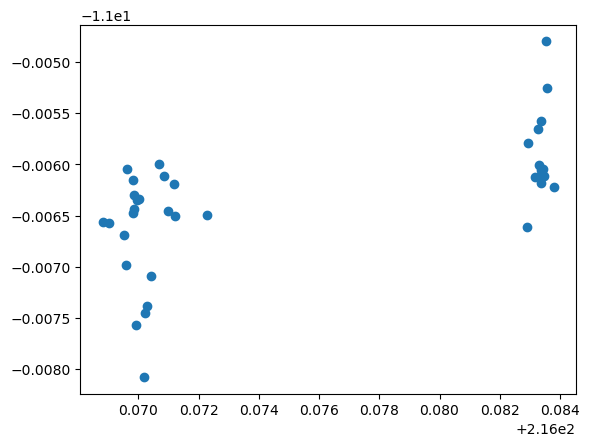

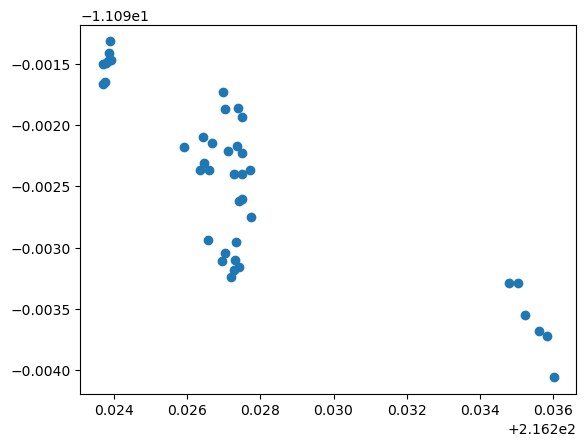

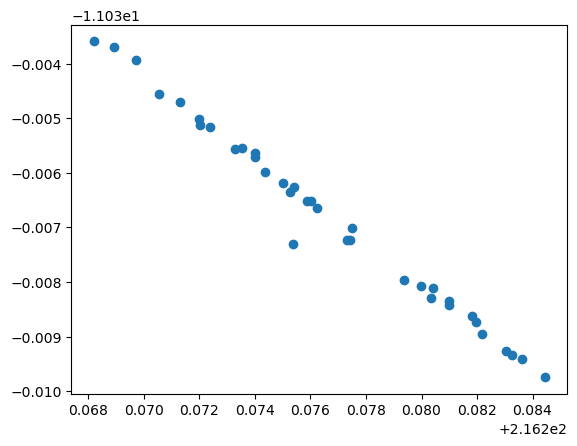

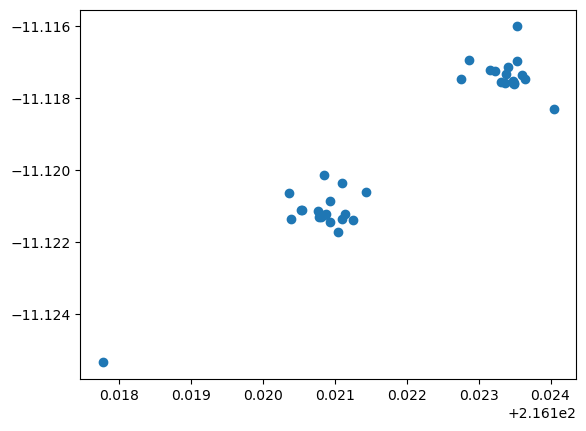

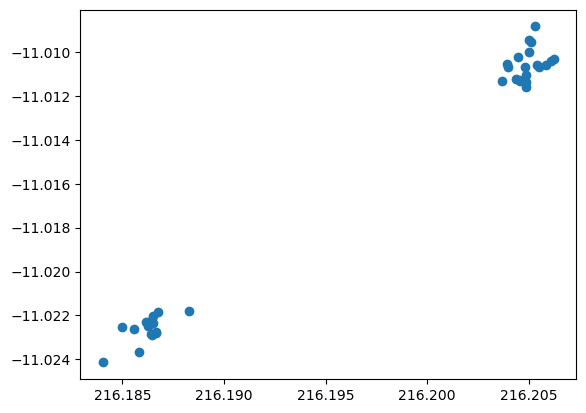

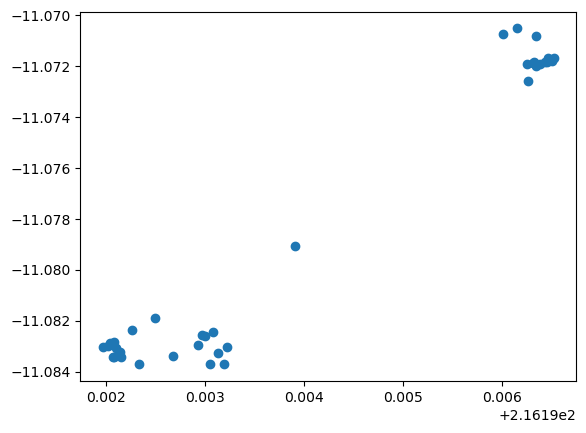

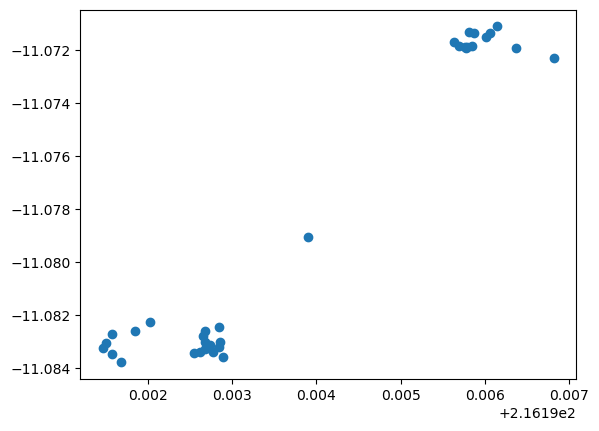

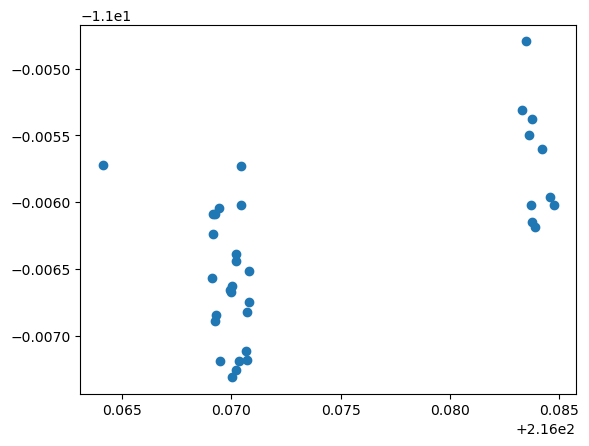

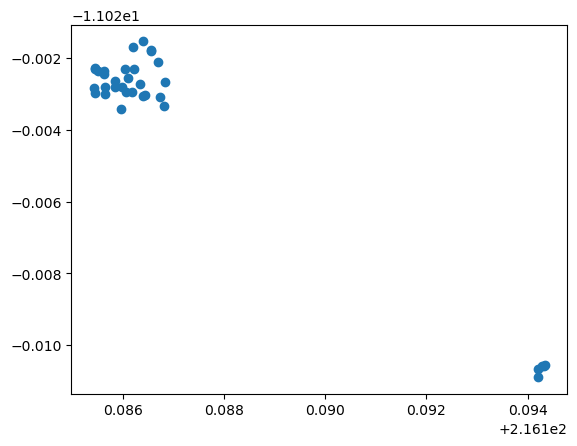

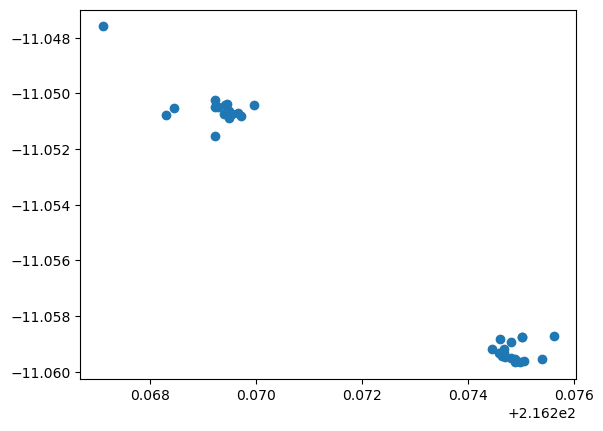

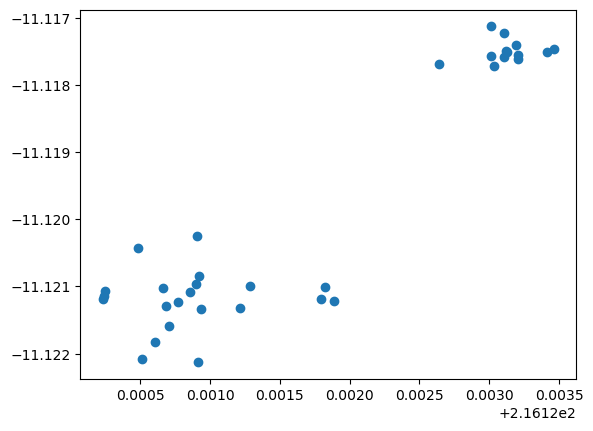

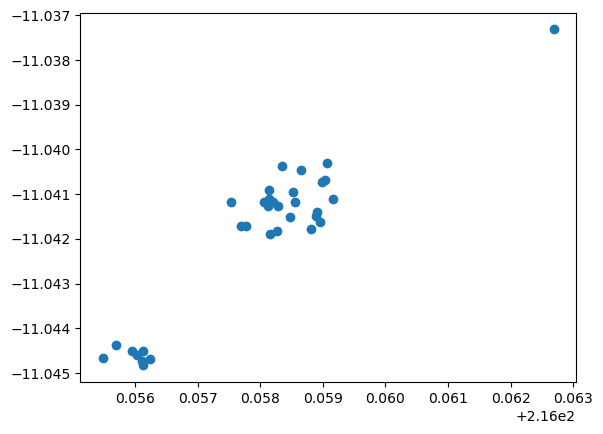

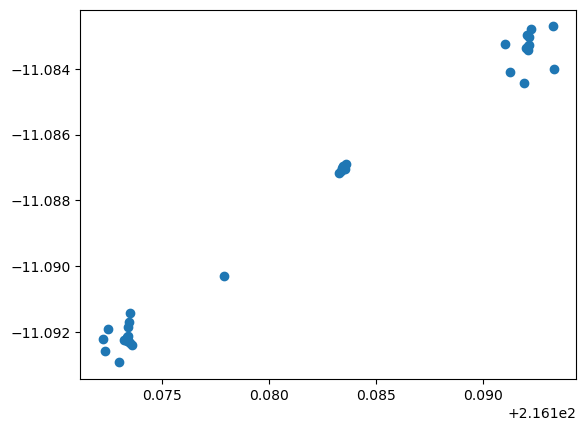

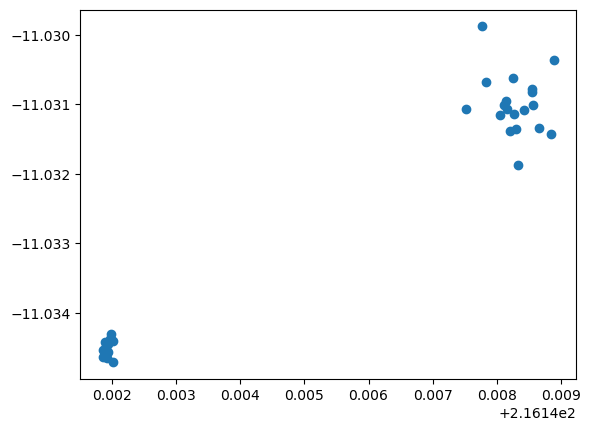

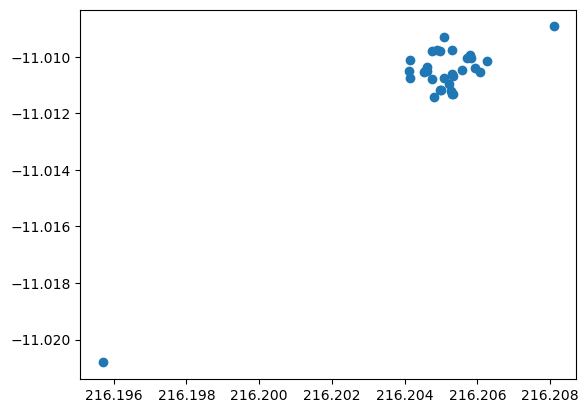

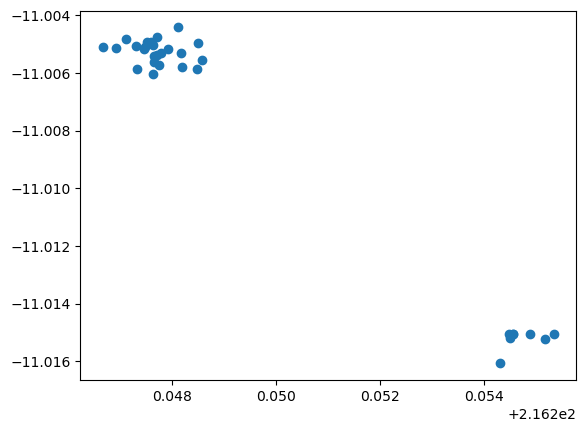

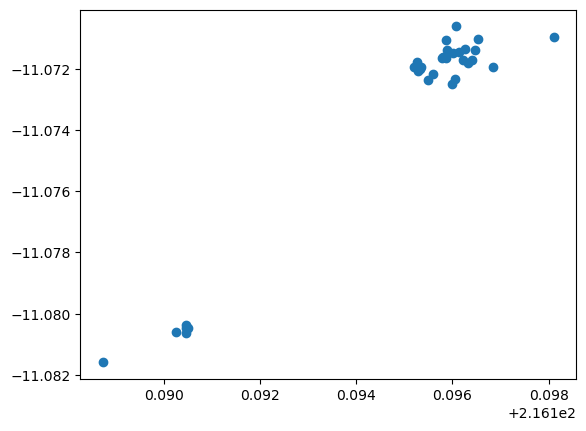

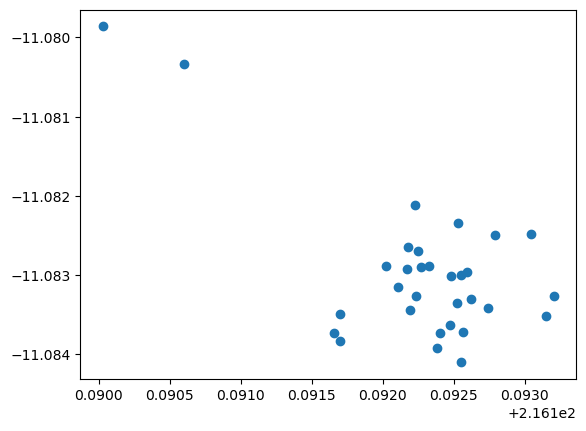

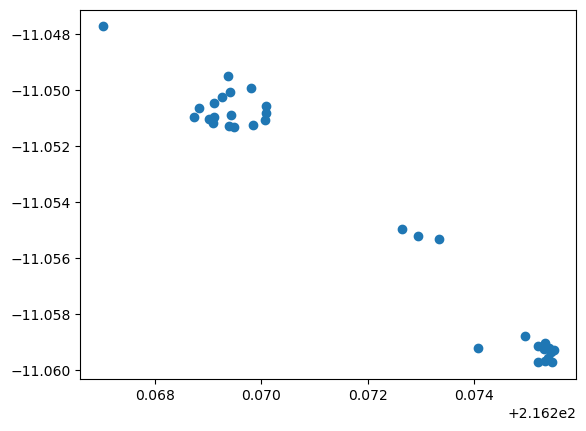

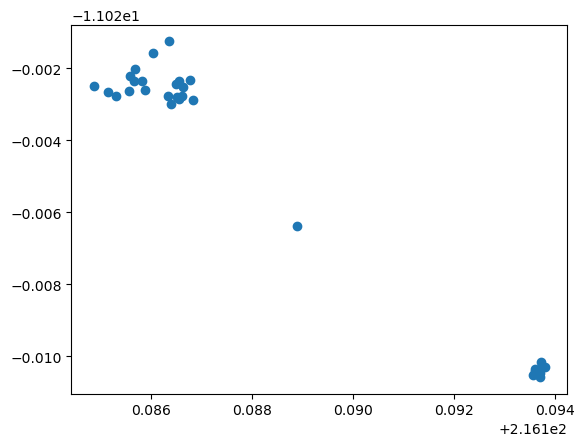

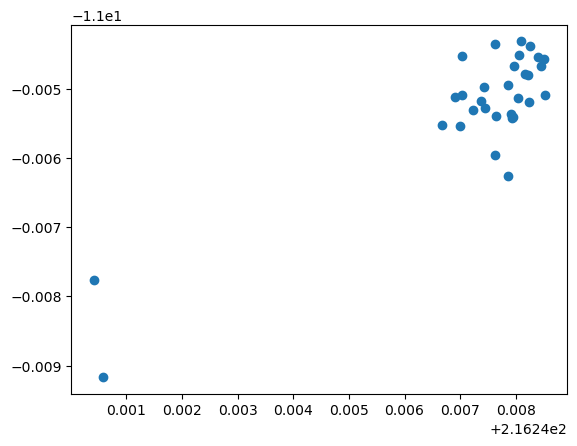

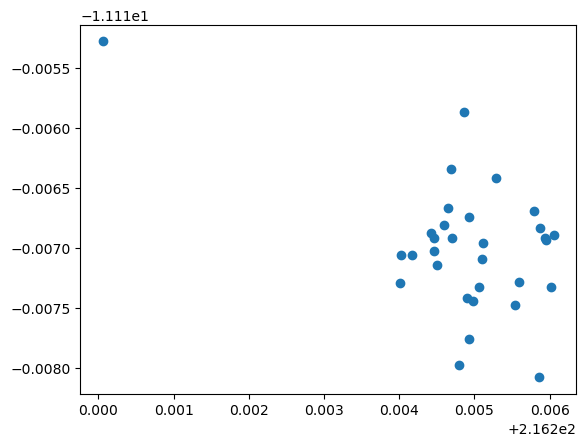

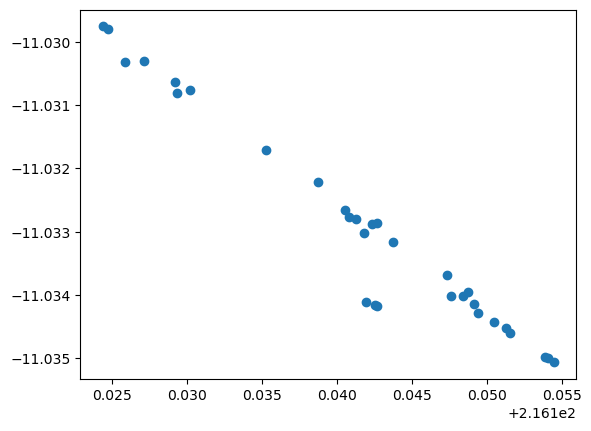

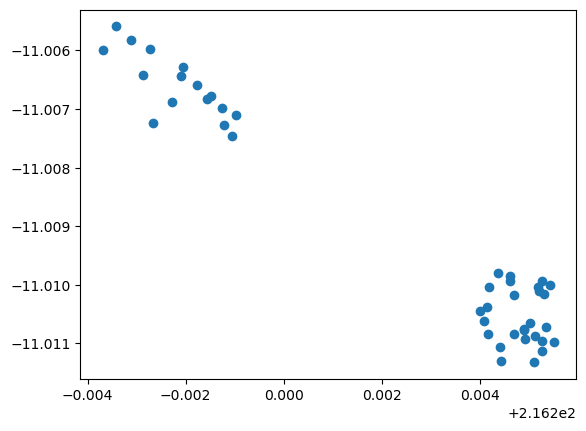

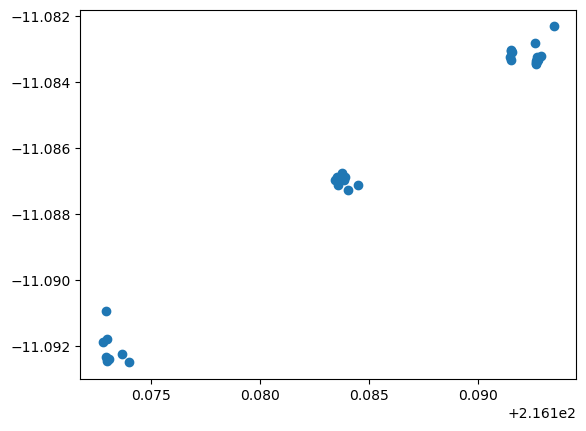

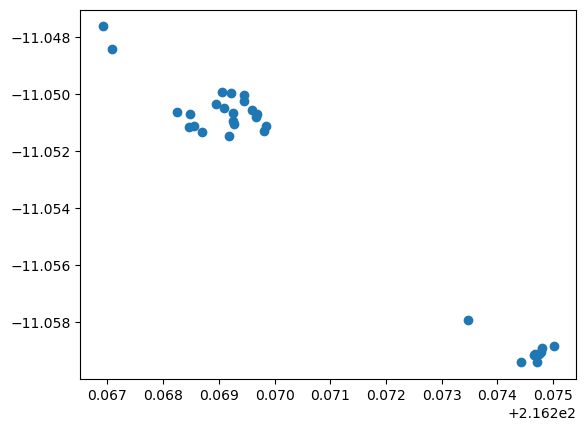

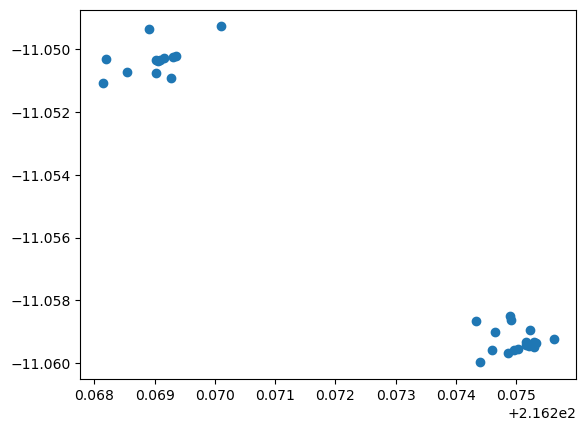

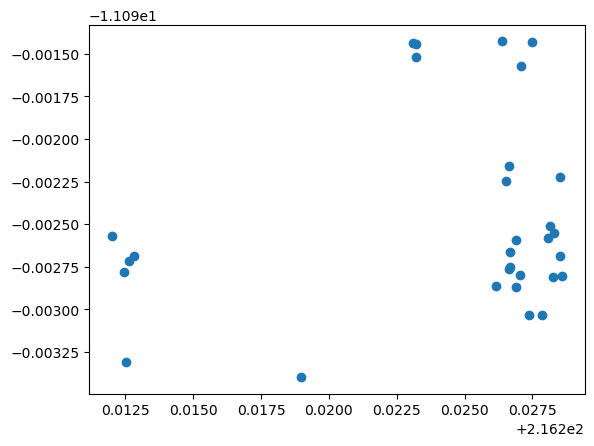

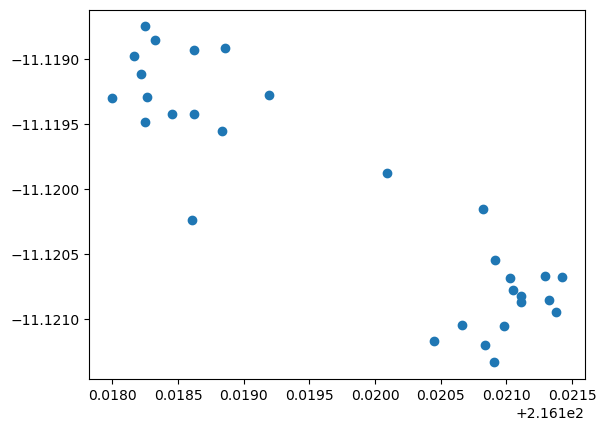

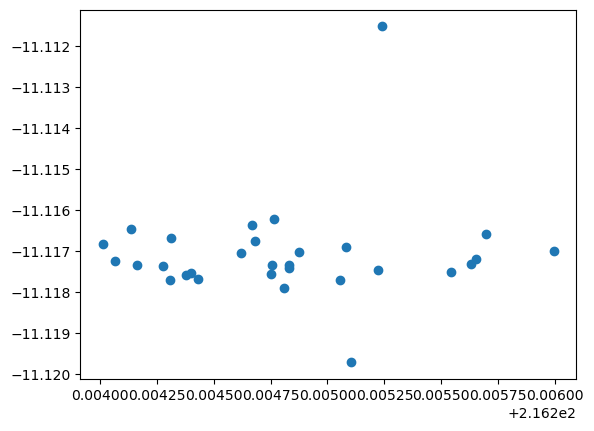

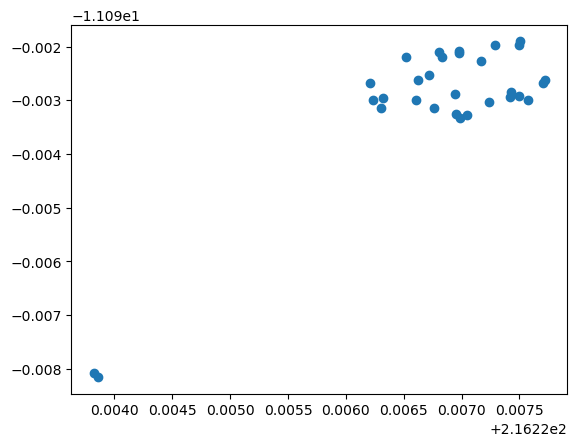

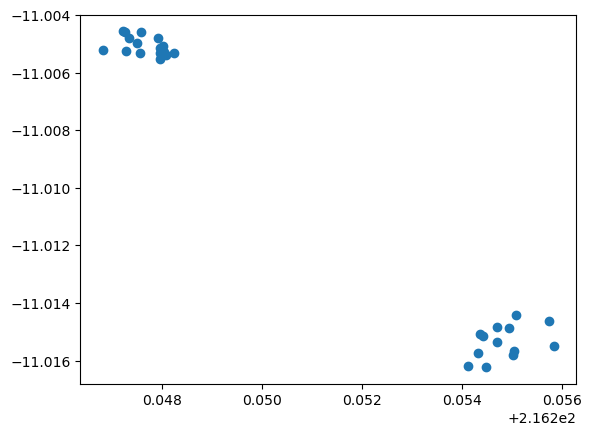

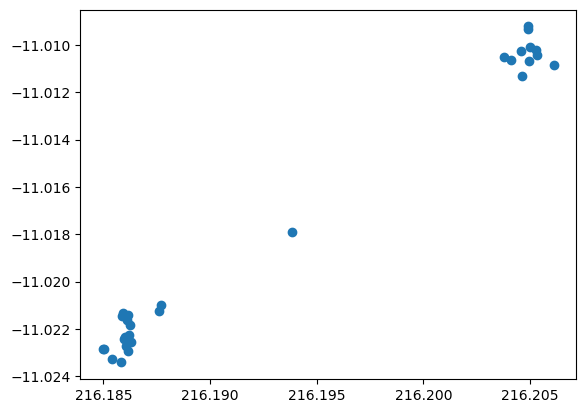

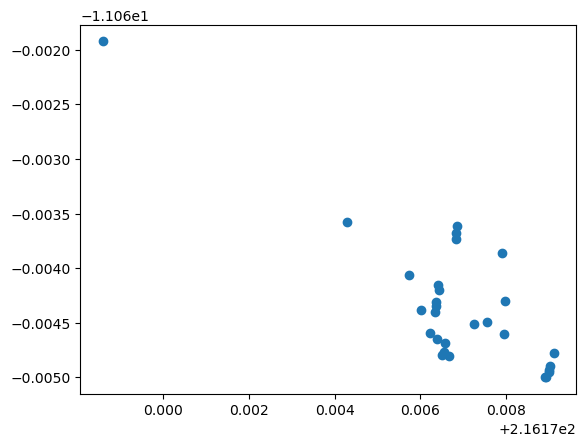

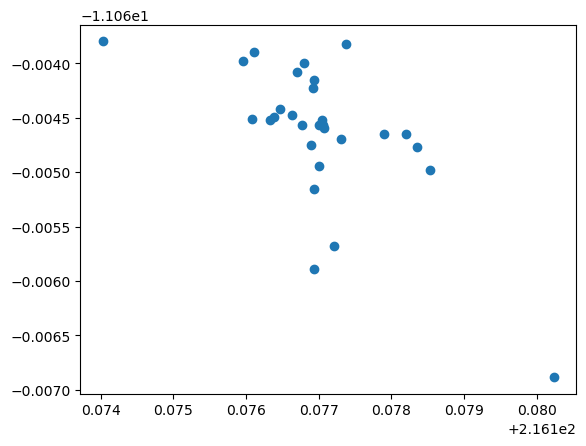

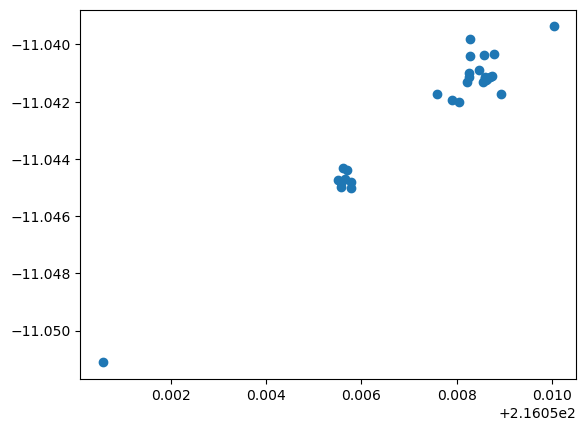

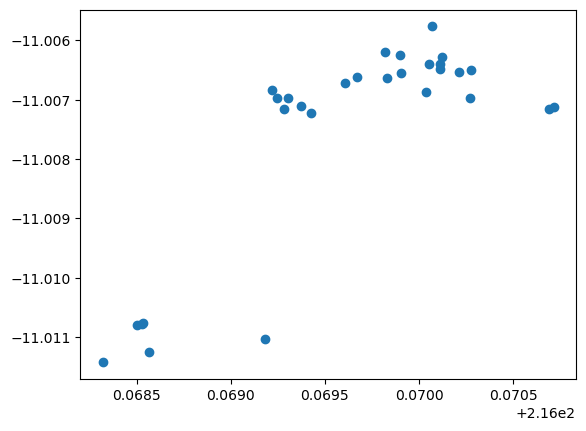

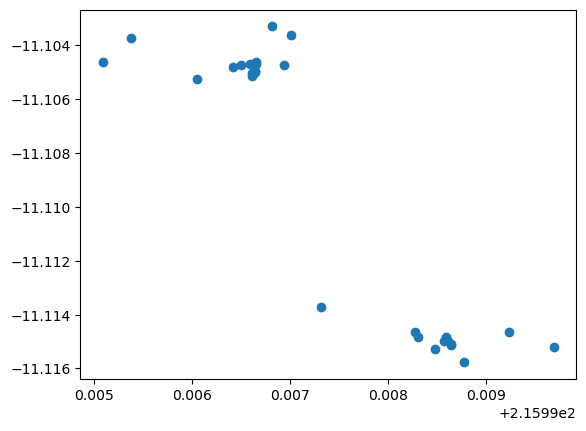

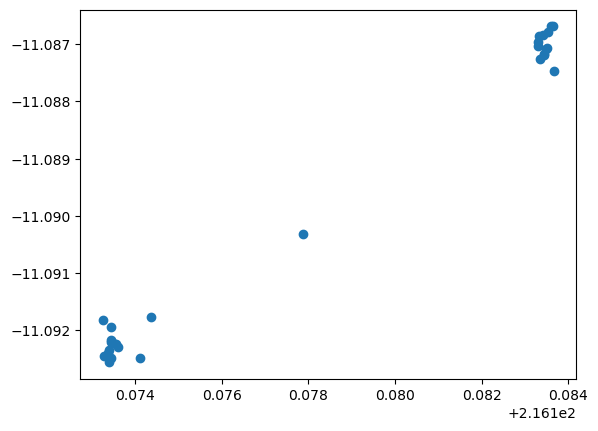

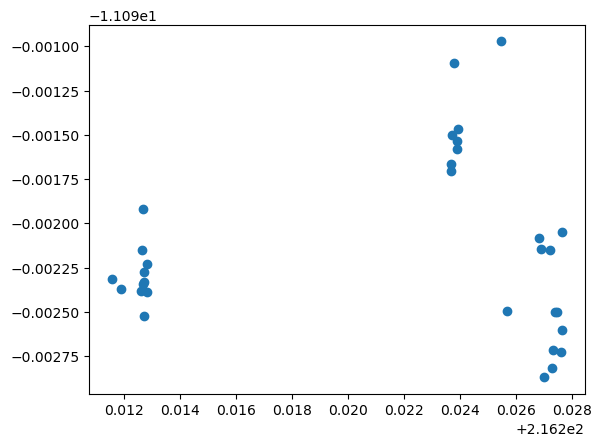

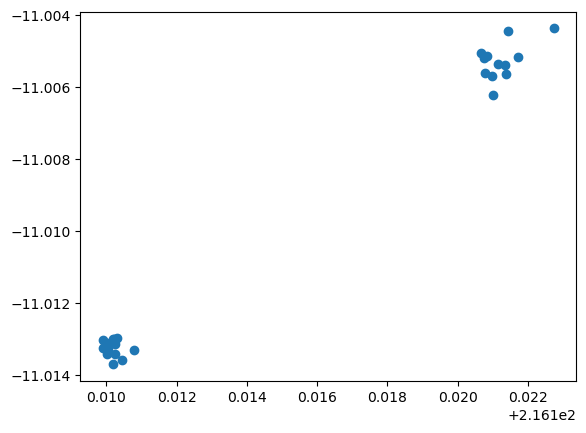

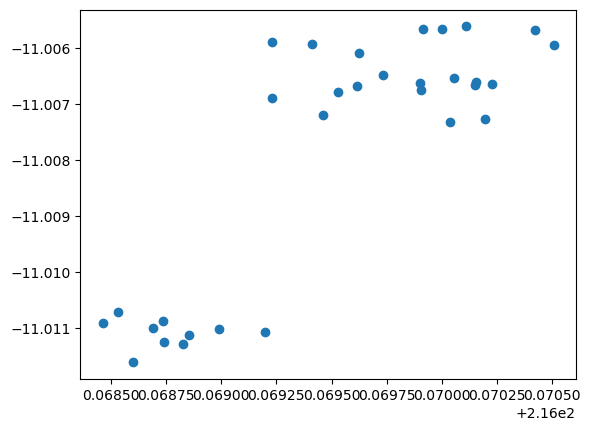

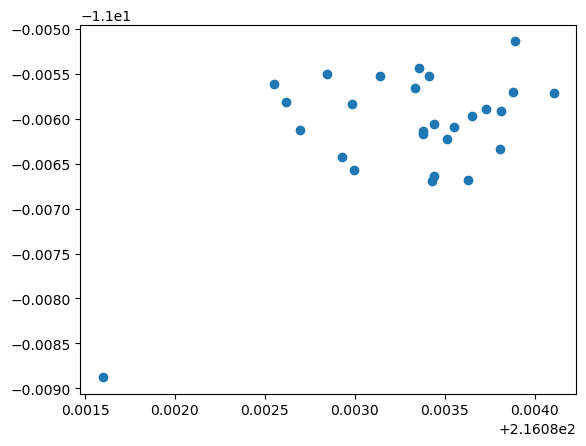

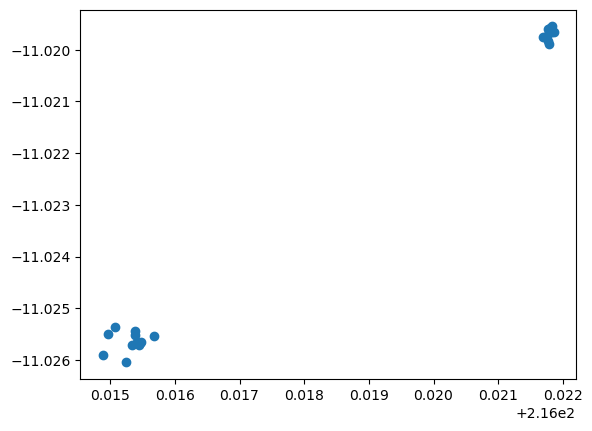

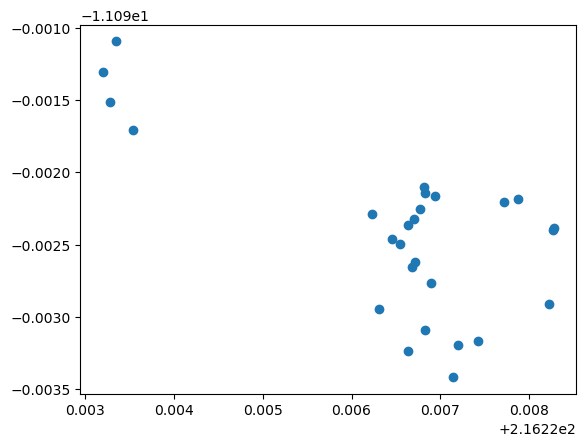

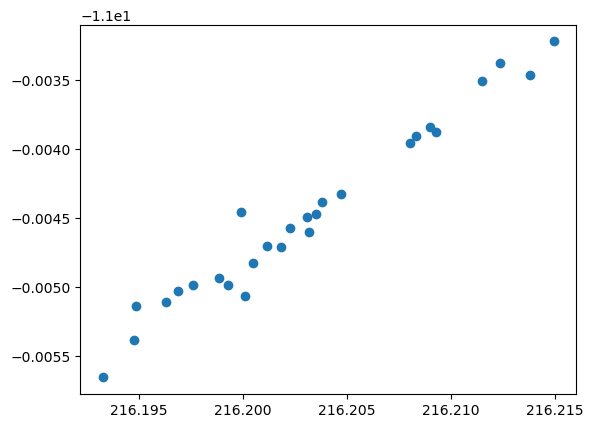

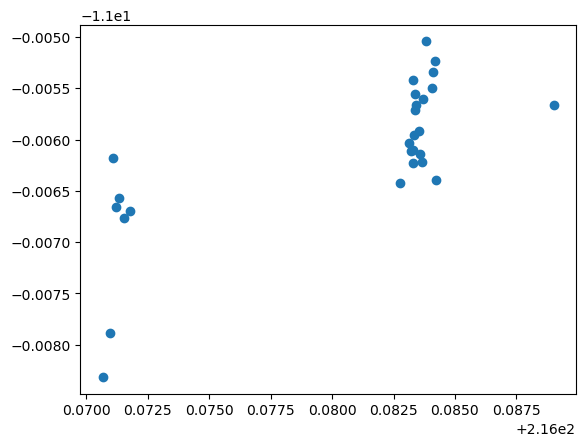

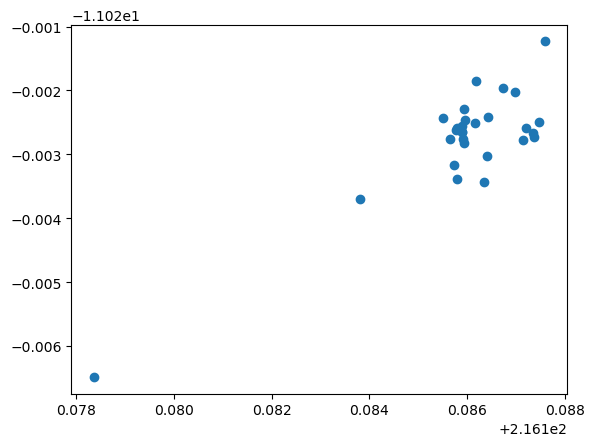

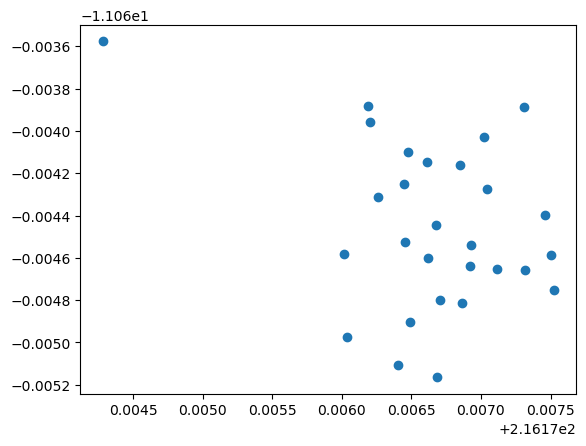

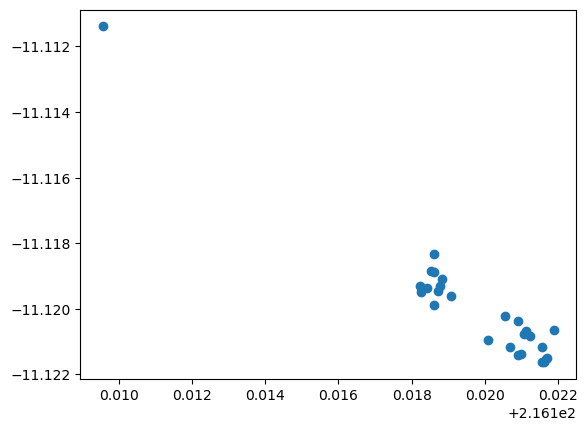

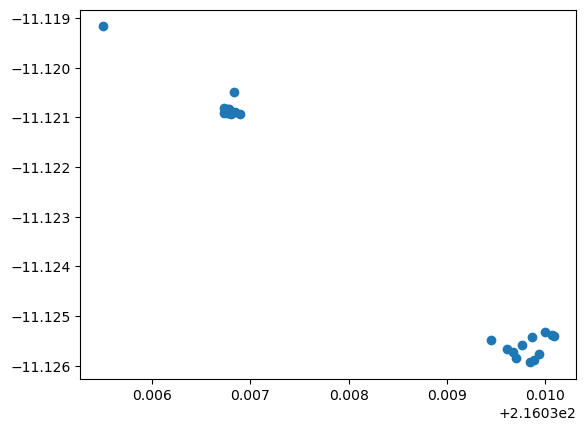

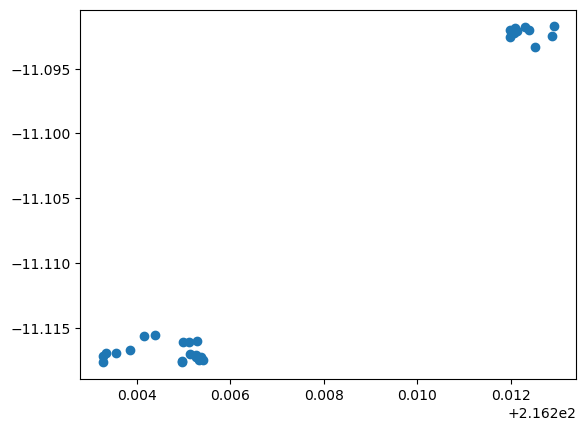

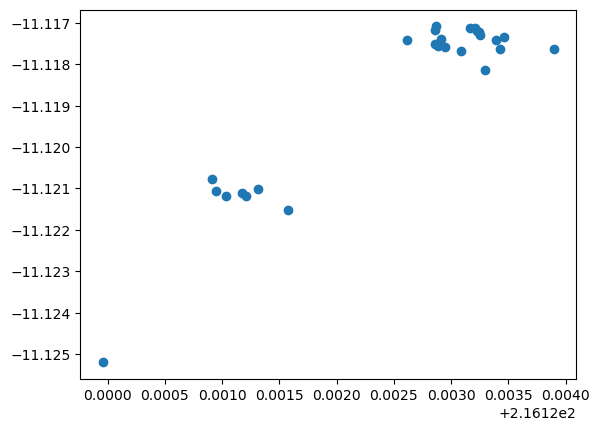

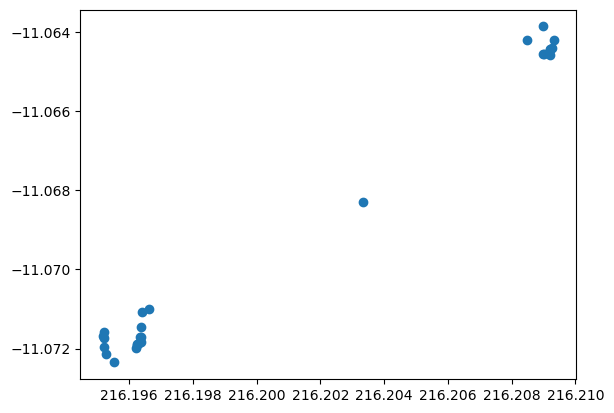

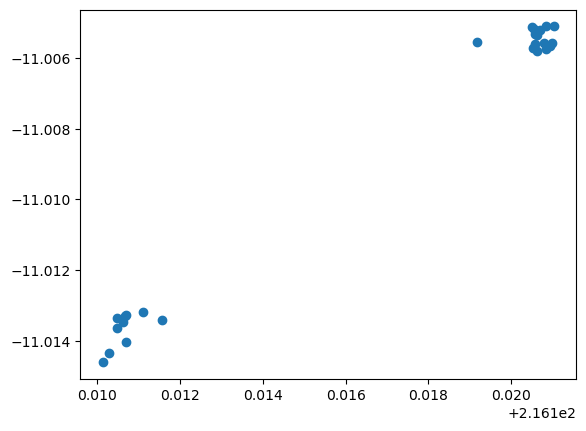

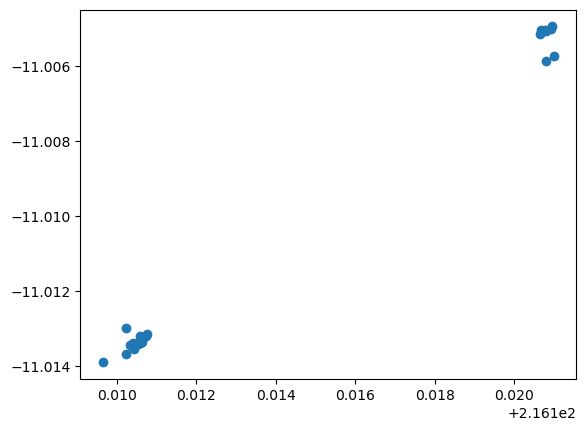

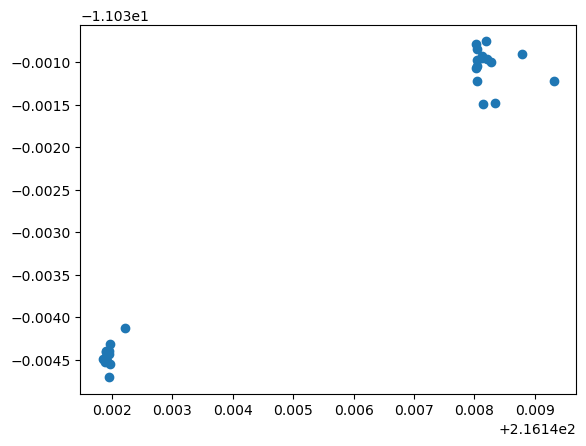

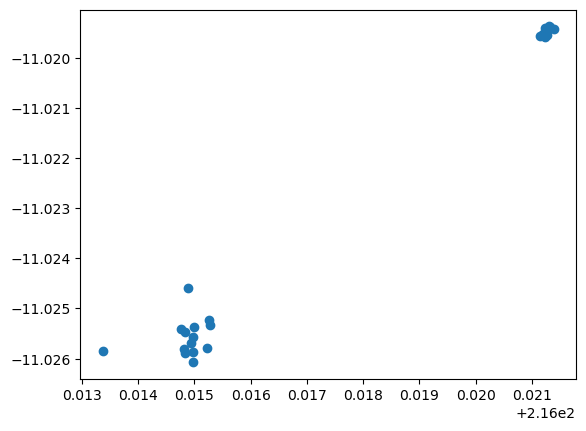

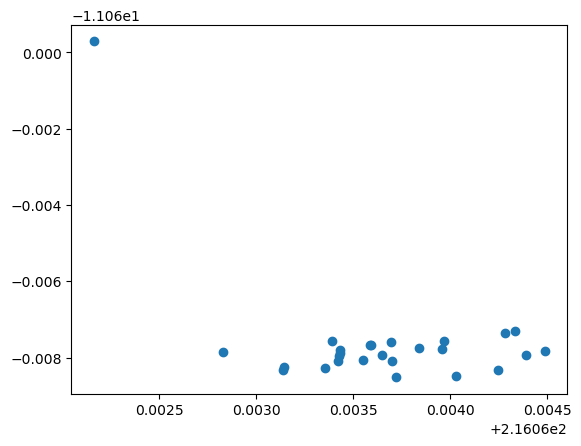

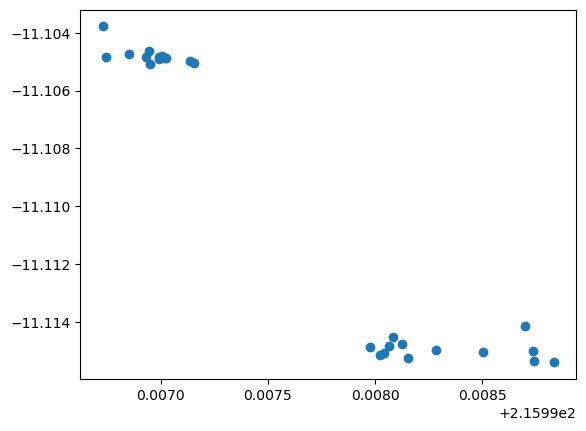

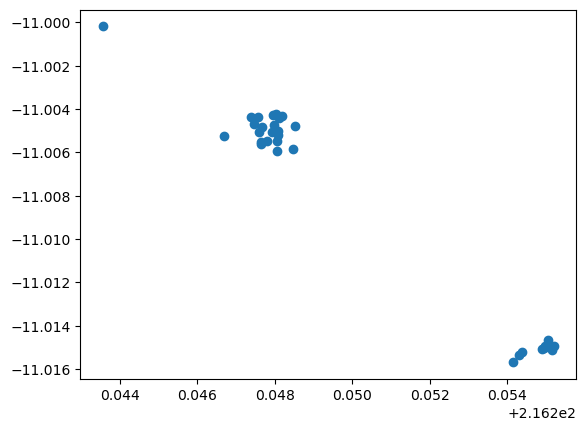

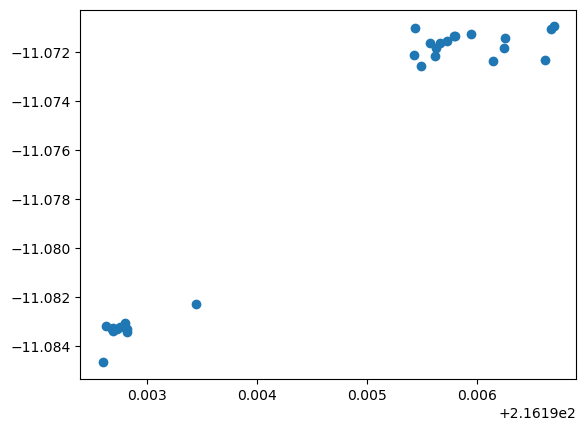

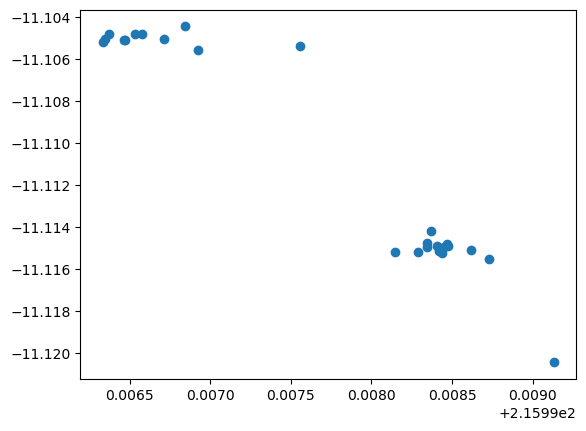

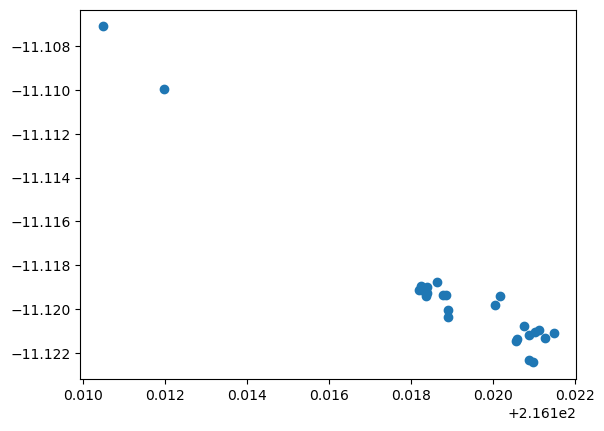

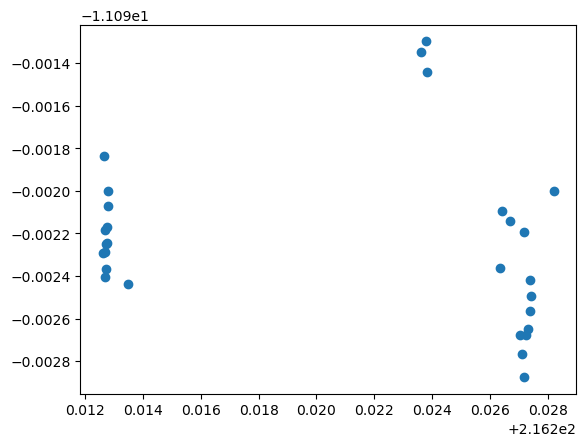

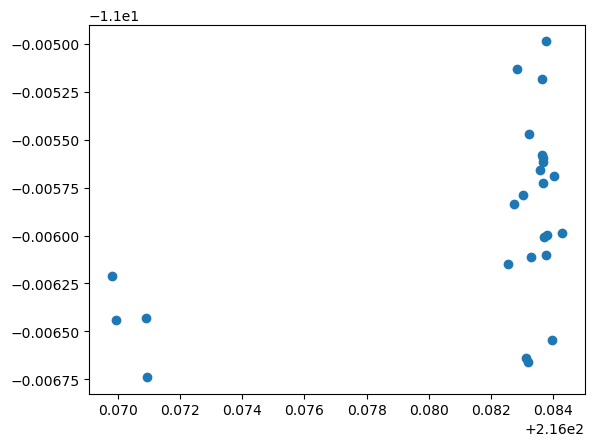

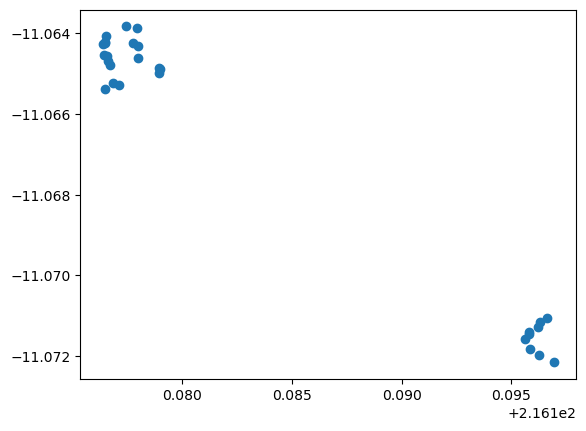

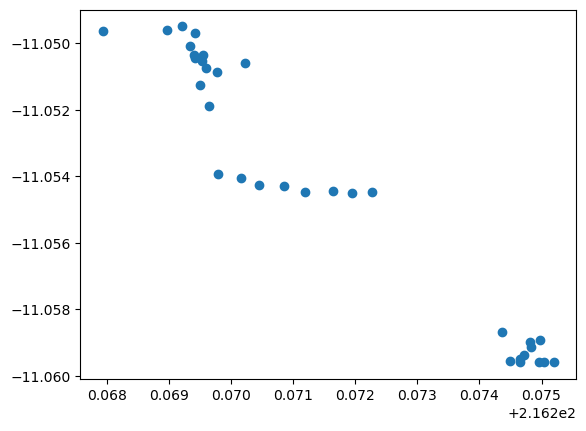

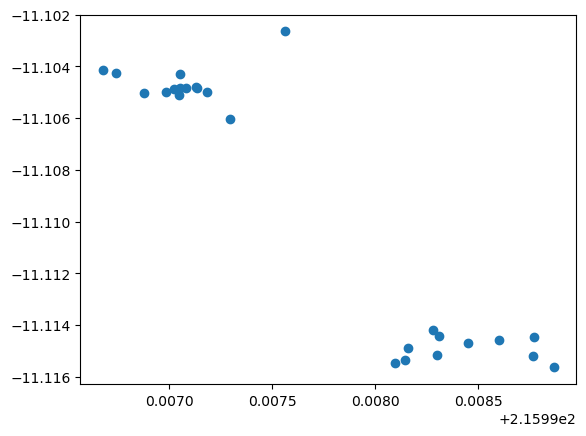

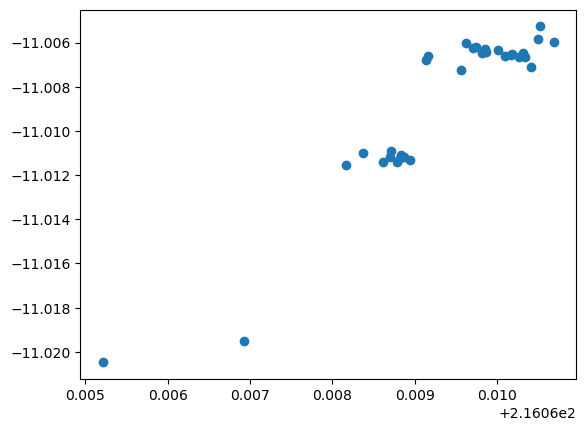

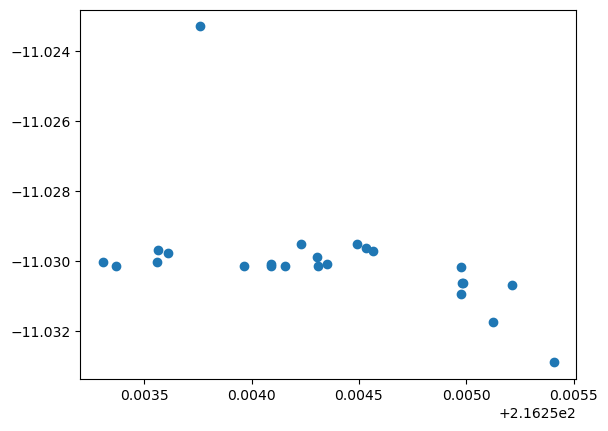

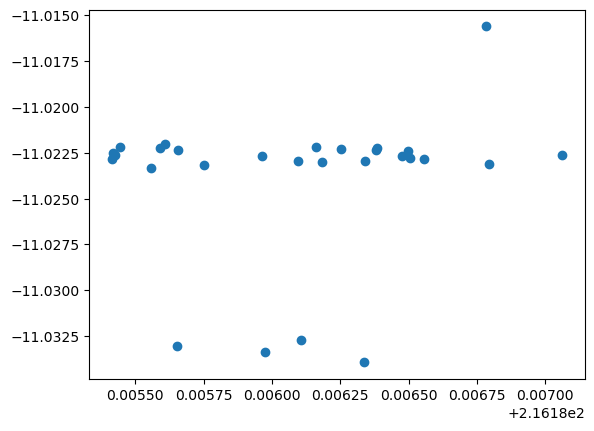

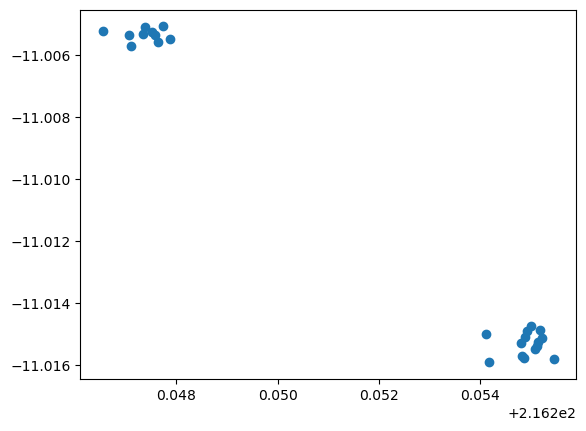


KeyboardInterrupt



In [93]:
for cluster in results:
    plot_cluster(cluster)
    plt.show()

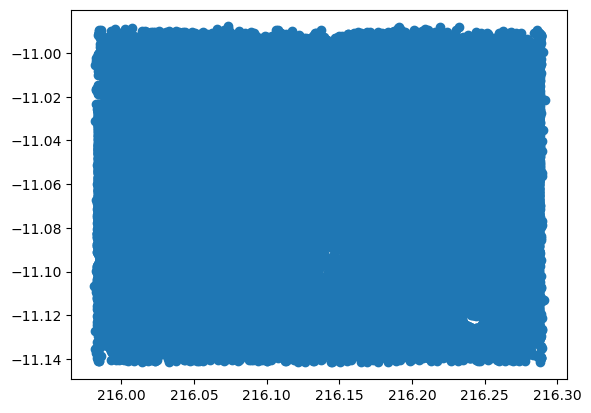

In [14]:
plt.scatter(X[:, 0], X[:, 1])
plt.show()

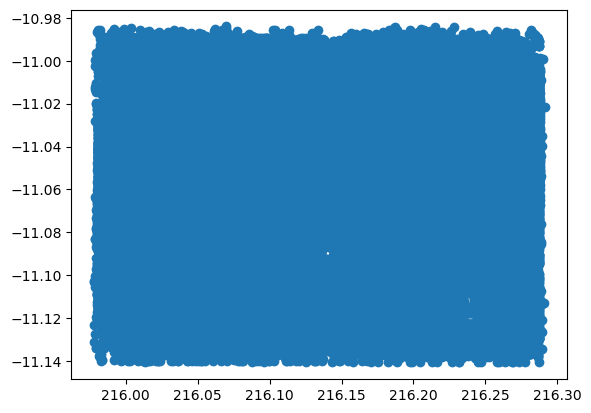

In [32]:
plt.scatter(projection.projected[0, :, 0], projection.projected[0, :, 1])
plt.show()

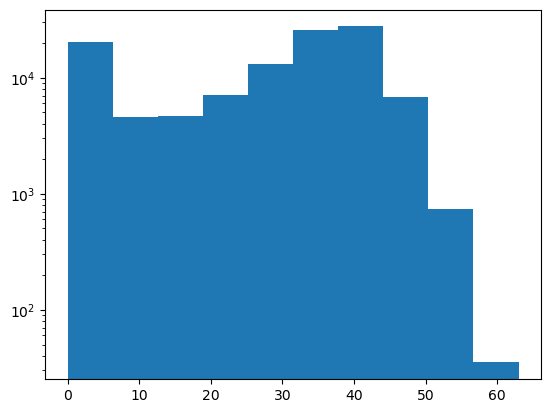

In [33]:
plt.hist(hough.array.flatten())
plt.yscale("log")
plt.show()

In [59]:
directions.b

<Quantity [[ -50.59414819, -118.01569137],
           [ -37.10983956, -118.01569137],
           [ -23.62553093, -118.01569137],
           [ -10.14122229, -118.01569137],
           [   3.34308634, -118.01569137],
           [  16.82739498, -118.01569137],
           [  30.31170361, -118.01569137],
           [  43.79601225, -118.01569137],
           [  57.28032088, -118.01569137],
           [ -77.56276546, -104.53138273],
           [ -64.07845683, -104.53138273],
           [ -50.59414819, -104.53138273],
           [ -37.10983956, -104.53138273],
           [ -23.62553093, -104.53138273],
           [ -10.14122229, -104.53138273],
           [   3.34308634, -104.53138273],
           [  16.82739498, -104.53138273],
           [  30.31170361, -104.53138273],
           [  43.79601225, -104.53138273],
           [  57.28032088, -104.53138273],
           [  70.76462951, -104.53138273],
           [ -91.0470741 ,  -91.0470741 ],
           [ -77.56276546,  -91.0470741 ],
           